In [1]:
import numpy as np
import pandas as pd
import altair as alt

import matplotlib
import matplotlib.pyplot as plt

from statsmodels.tsa import seasonal, stattools
from statsmodels.tsa.arima.model import ARIMA

%matplotlib inline
%config InlineBackend.figure_format='retina'
# matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [2]:
df = pd.read_csv('data/sweden_load_2005_2017.csv', parse_dates=['cet_cest_timestamp'])

In [3]:
df['cet_cest_timestamp'] = df['cet_cest_timestamp'].apply(lambda x: x.replace(tzinfo=None))
df = df.rename({'cet_cest_timestamp': 'time', 'SE_load_actual_tso': 'load'}, axis=1)
df = df.set_index('time')

## Identify seasonality

In [4]:
from scipy.fftpack import fft

four = fft((df.load - df.load.mean()).values)

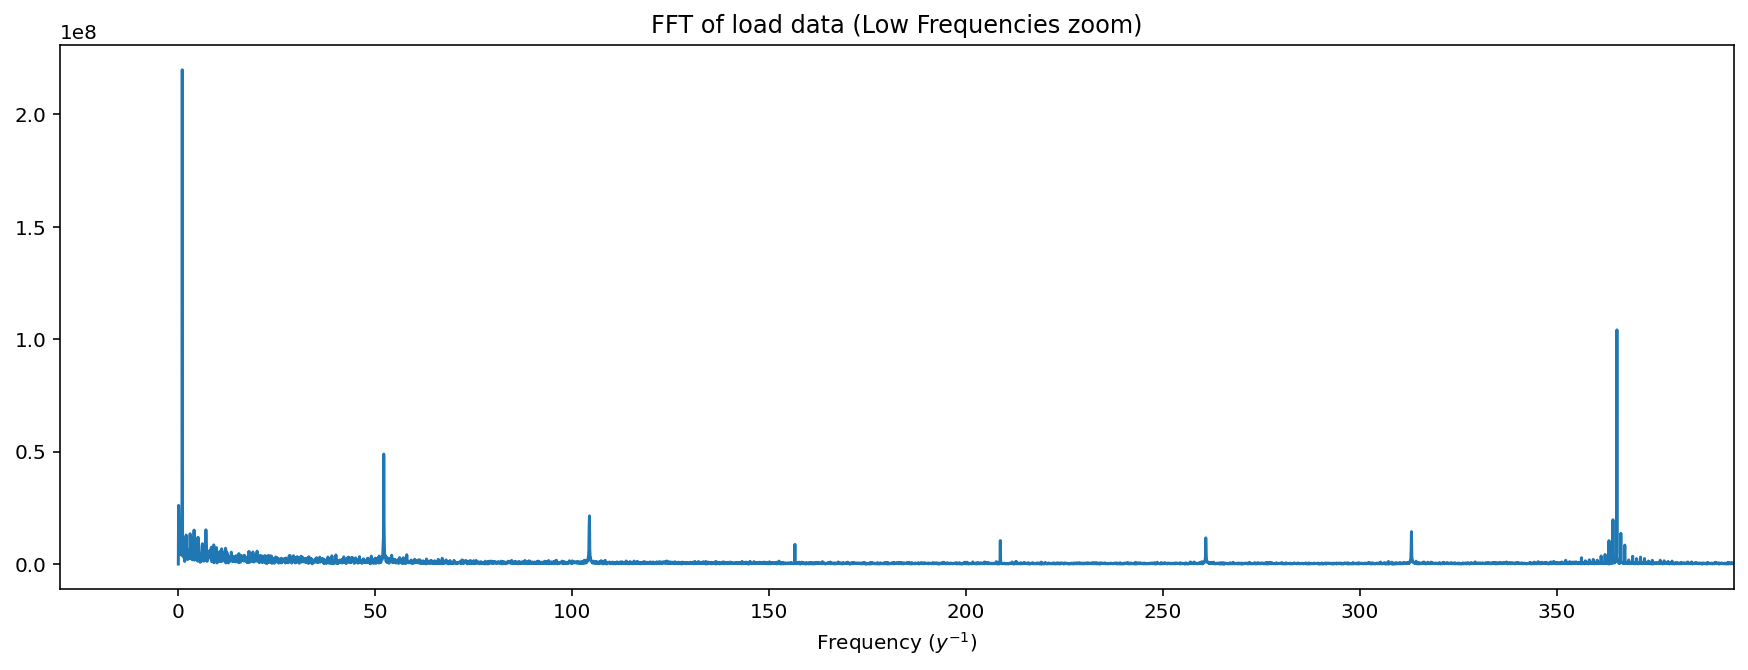

In [5]:
plt.plot(1./13 * np.arange(len(four)), np.abs(four))
plt.title("FFT of load data (Low Frequencies zoom)")
plt.xlim([-30, 365+30])
plt.xlabel('Frequency ($y^{-1}$)');

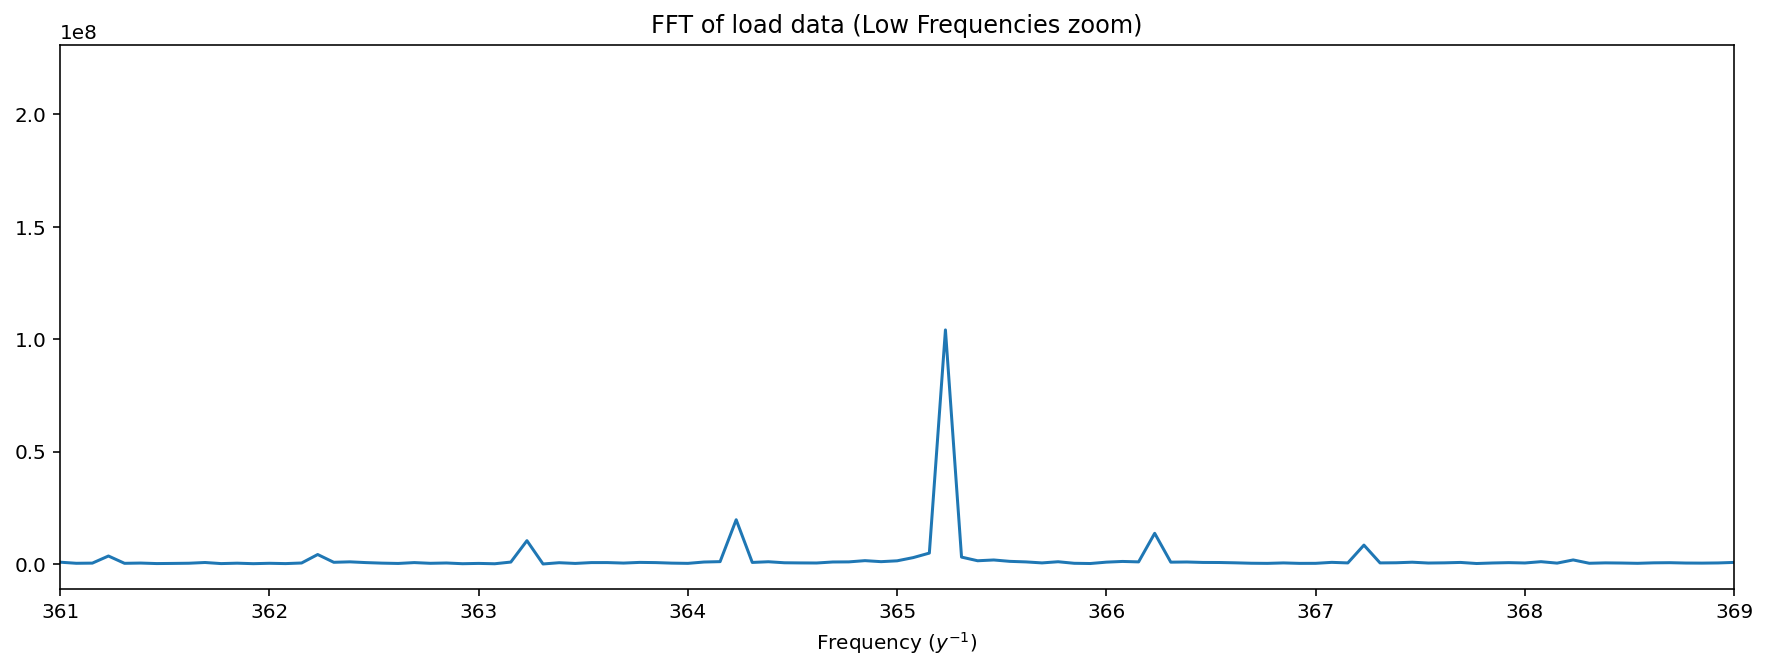

In [6]:
plt.plot(1./13 * np.arange(len(four)), np.abs(four))
plt.title("FFT of load data (Low Frequencies zoom)")
plt.xlim([365-4, 365+4])
plt.xlabel('Frequency ($y^{-1}$)');

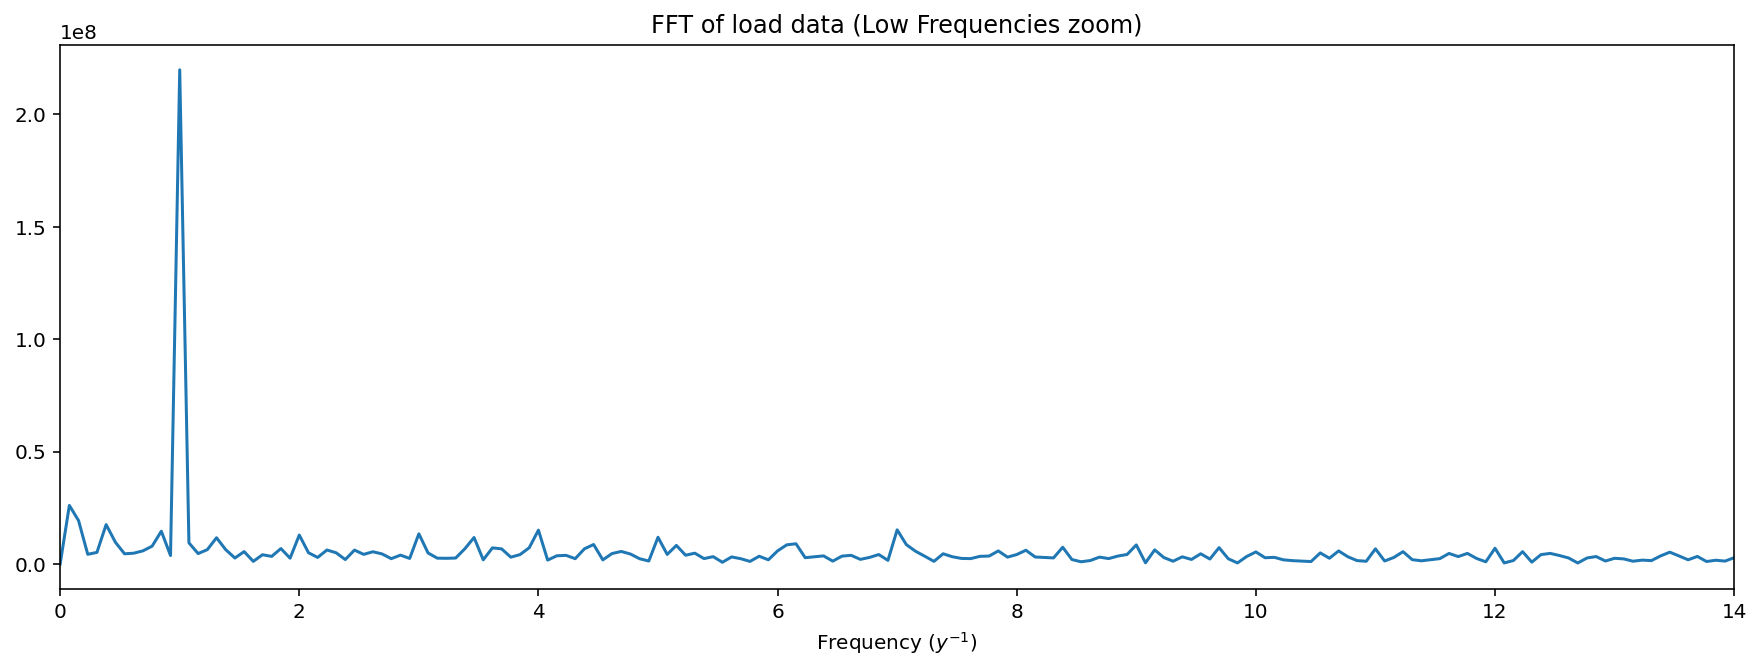

In [7]:
plt.plot(1./13 * np.arange(len(four)), np.abs(four))
plt.title("FFT of load data (Low Frequencies zoom)")
plt.xlim([0, 14])
plt.xlabel('Frequency ($y^{-1}$)');

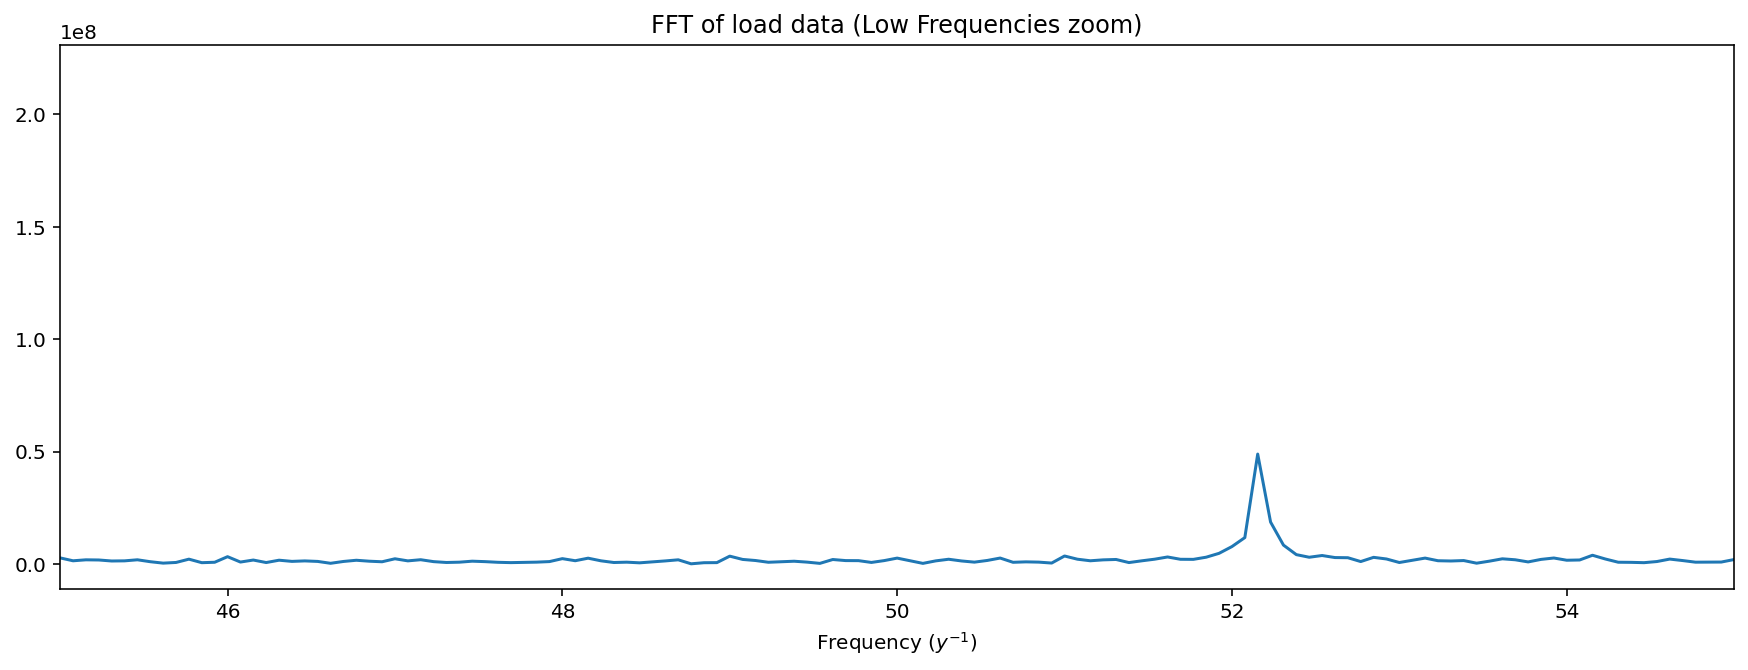

In [8]:
plt.plot(1./13 * np.arange(len(four)), np.abs(four))
plt.title("FFT of load data (Low Frequencies zoom)")
plt.xlim([50-5, 50+5])
plt.xlabel('Frequency ($y^{-1}$)');

## Remove seasonality

In [21]:
def _decompose(ts, period):
    decomposition = seasonal.seasonal_decompose(ts, period=period)

    trend = decomposition.trend
    trend.dropna(inplace=True)
    seas = decomposition.seasonal
    residual = decomposition.resid
    residual.dropna(inplace=True);
    
    # Original
    plt.subplot(411)
    plt.plot(ts, label='Original')
    plt.legend(loc='upper left')
    
    # Seasonality
    plt.subplot(413)
    plt.plot(seas, label='Seasonality')
    plt.legend(loc='upper left')
    
    # Trend
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    
    # Resudials
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    return seas, trend, residual

In [22]:
def strength_level(s, t, r, of='seasonality'):
    ts = t
    if of == 'seasonality':
        ts = s
    elif of == 'trend':
        ts = t
    else:
        raise RuntimeError("of should be 'seasonality' of 'trend' ")
    return max(0, 1 - np.var(ts)/ np.var(ts + r))

In [23]:
def test_stationary(ts):
    result = stattools.adfuller(ts)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
    result = stattools.kpss(ts, nlags='auto')
    print('KPSS Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[3].items():
        print('\t%s: %.3f' % (key, value))

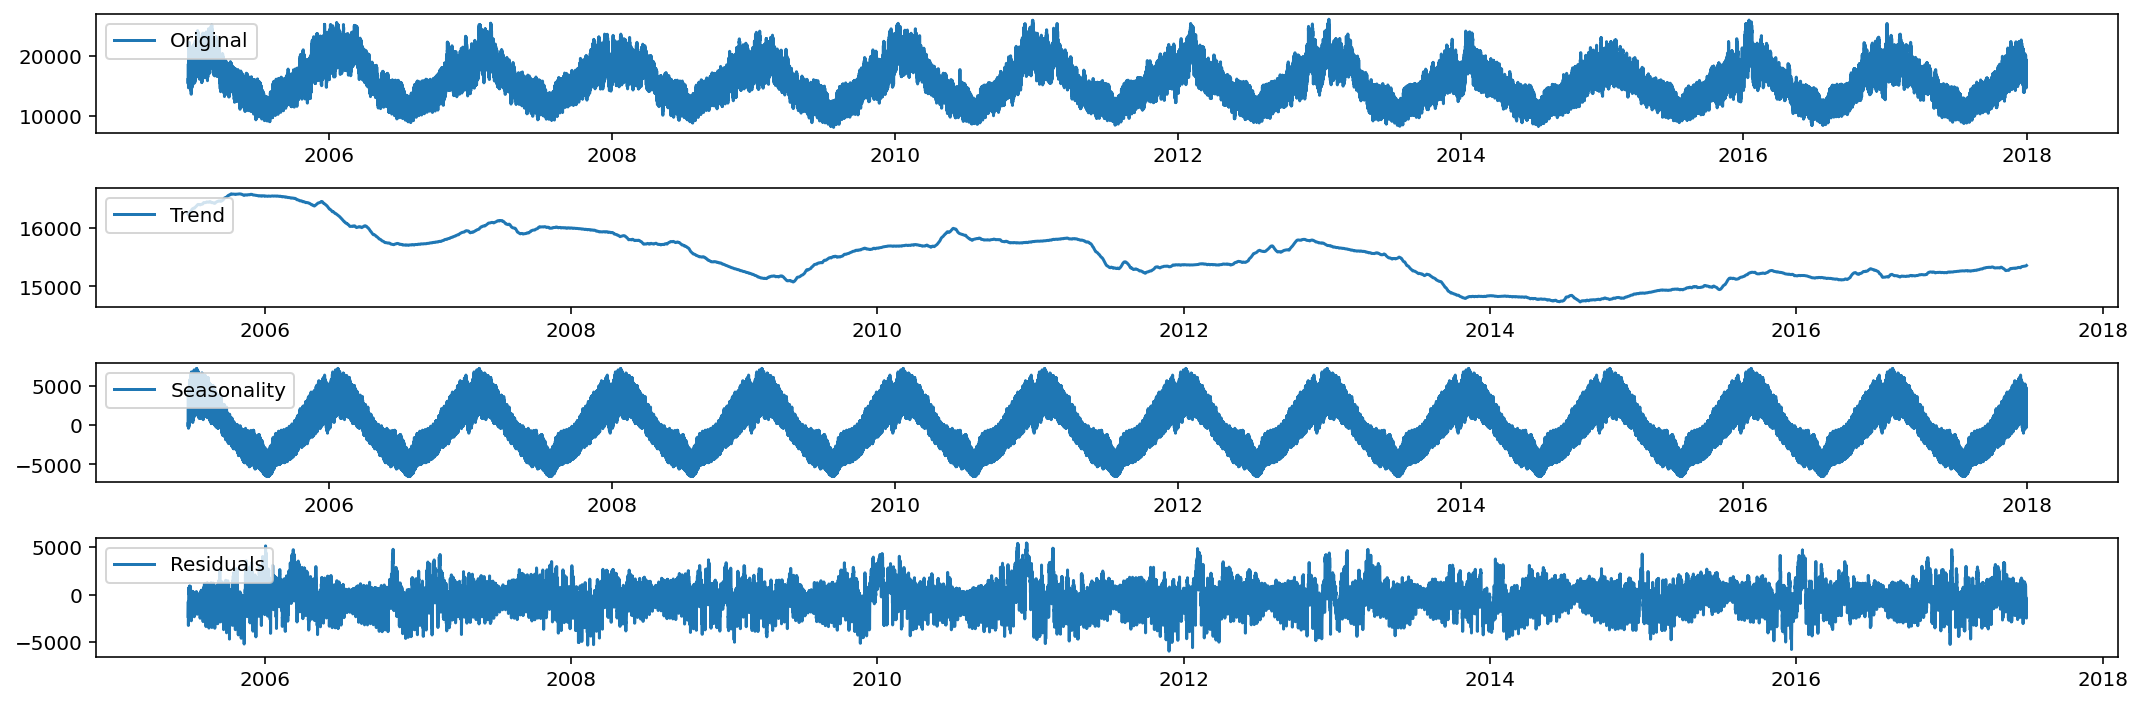

In [24]:
year_seasonal, year_trend, year_res = _decompose(df, 24*365)

In [25]:
print(f"Strength of seasonality: {strength_level(year_seasonal, year_trend, year_res, of='seasonality'):.2f}")
print(f"Strength of trend: {strength_level(year_seasonal, year_trend, year_res, of='trend'):.2f}")

Strength of seasonality: 0.14
Strength of trend: 0.89


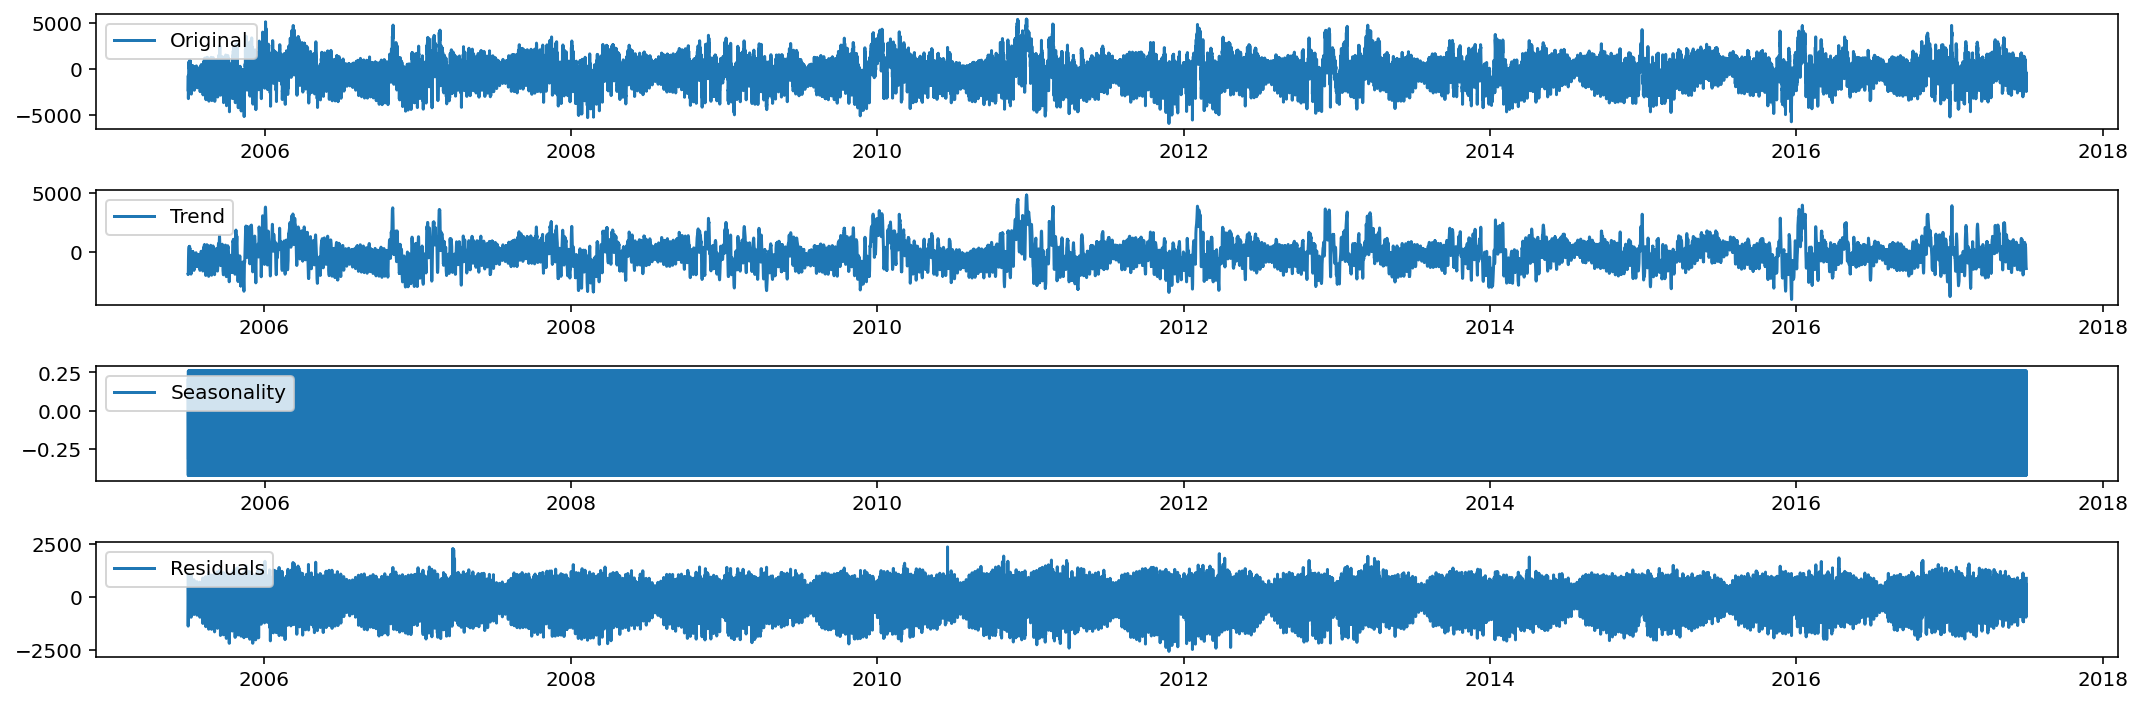

In [26]:
day_seasonal, day_trend, day_res = _decompose(year_res, 24)

In [27]:
print(f"Strength of seasonality: {strength_level(day_seasonal, day_trend, day_res, of='seasonality'):.2f}")
print(f"Strength of trend: {strength_level(day_seasonal, day_trend, day_res, of='trend'):.2f}")

Strength of seasonality: 1.00
Strength of trend: 0.20


### Check for stationarity

In [28]:
test_stationary(df)

ADF Statistic: -7.962428
p-value: 0.000000
	1%: -3.430
	5%: -2.862
	10%: -2.567
KPSS Statistic: 1.327718
p-value: 0.010000
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/home/developer/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2011: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [29]:
test_stationary(year_res)

ADF Statistic: -28.645039
p-value: 0.000000
	1%: -3.430
	5%: -2.862
	10%: -2.567
KPSS Statistic: 0.028551
p-value: 0.100000
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/home/developer/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [30]:
test_stationary(day_res)

ADF Statistic: -69.584254
p-value: 0.000000
	1%: -3.430
	5%: -2.862
	10%: -2.567
KPSS Statistic: 0.009576
p-value: 0.100000
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/home/developer/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## Data preprocessing

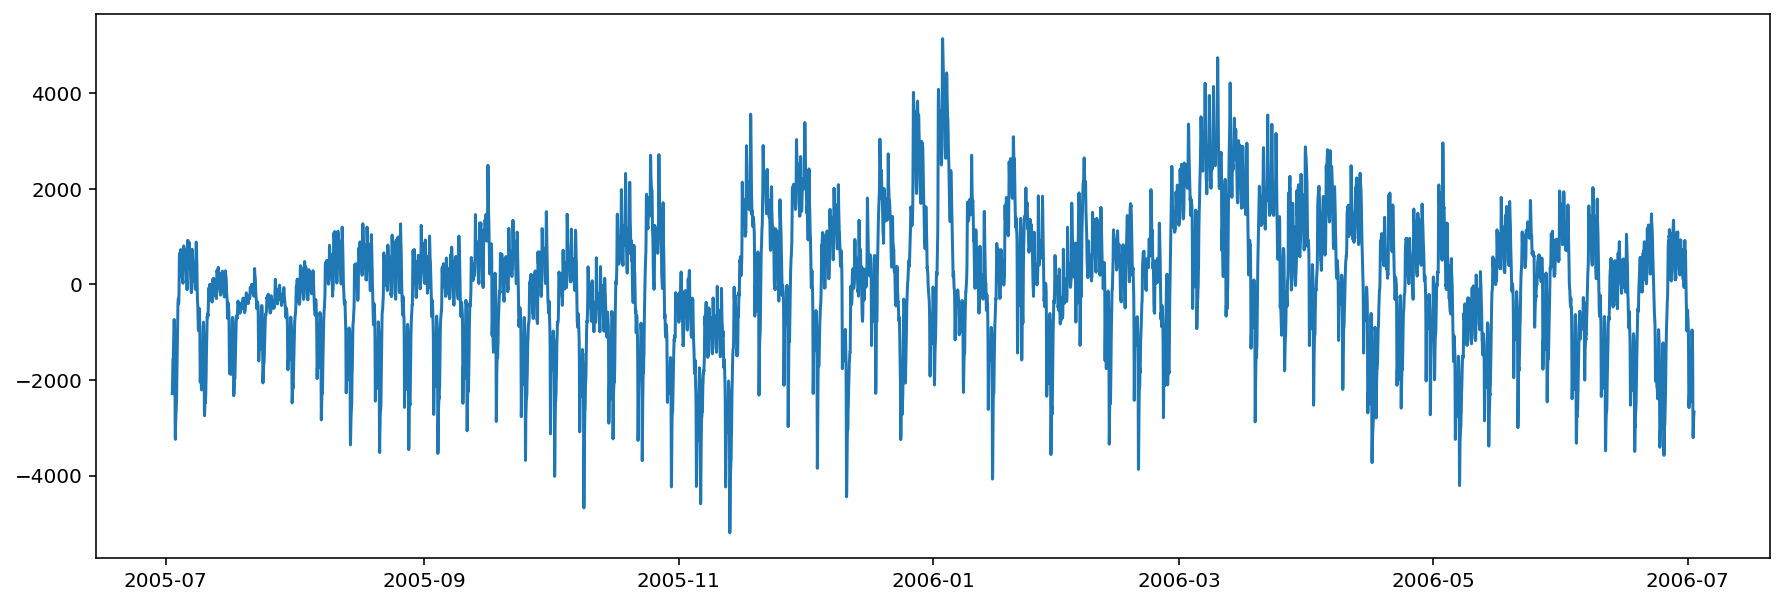

In [59]:
plt.plot(year_res[:24*365])

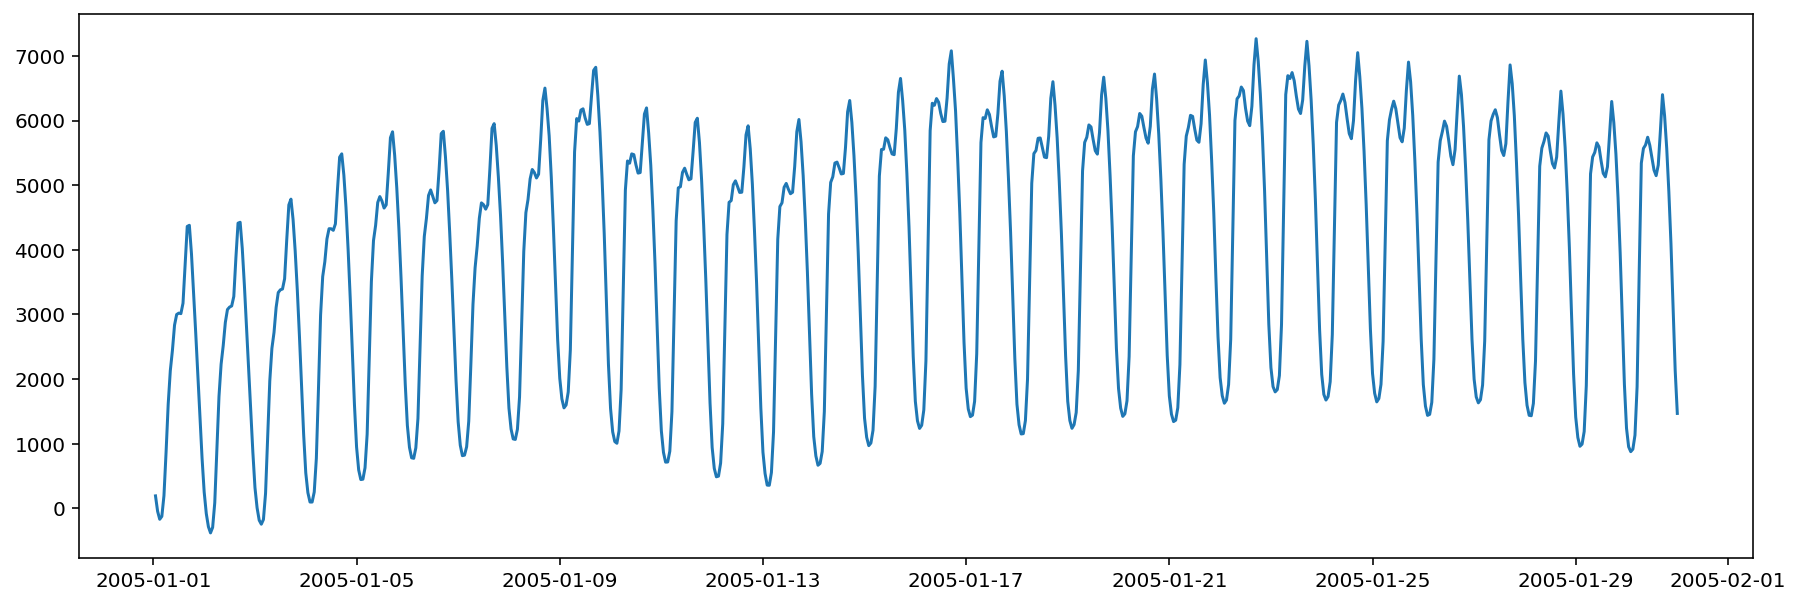

In [32]:
plt.plot(year_seasonal[:24*30])

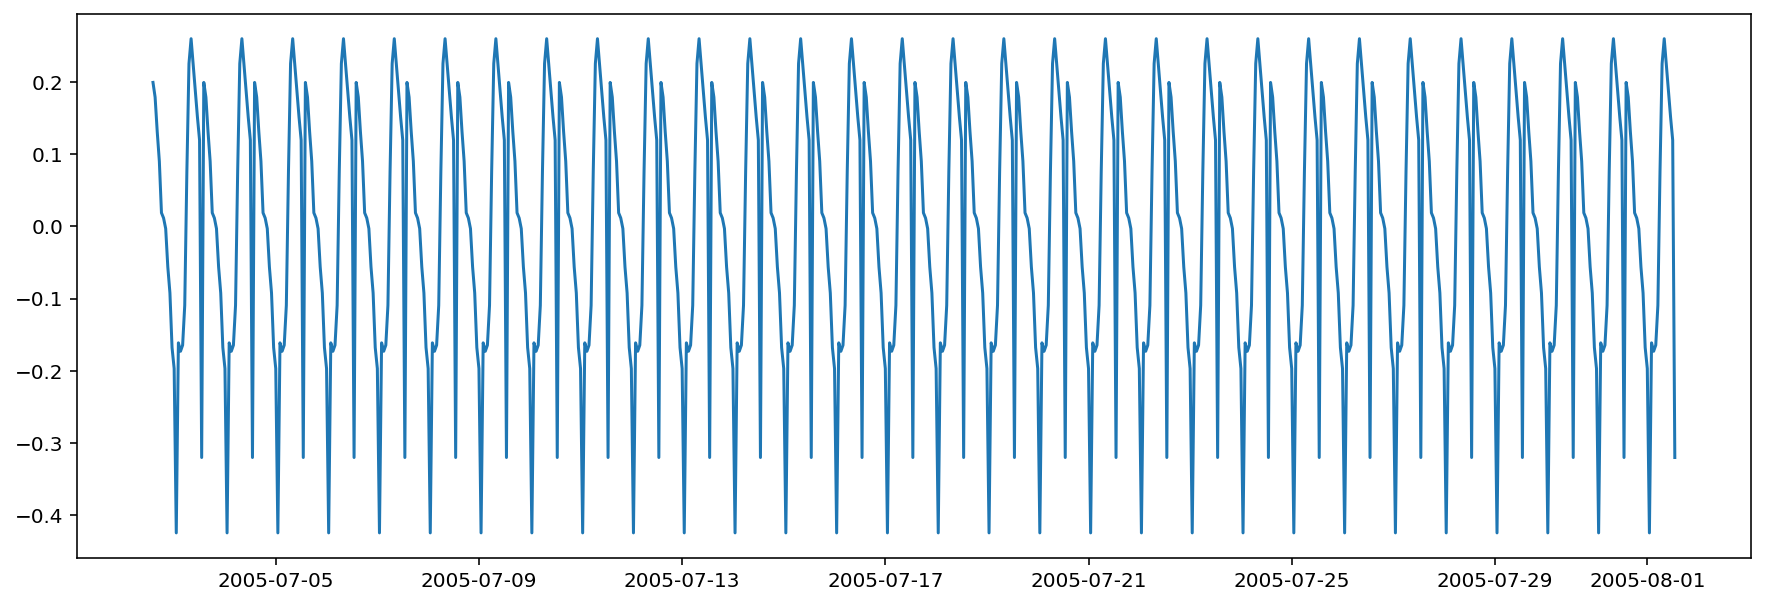

In [33]:
plt.plot(day_seasonal[:24*30])

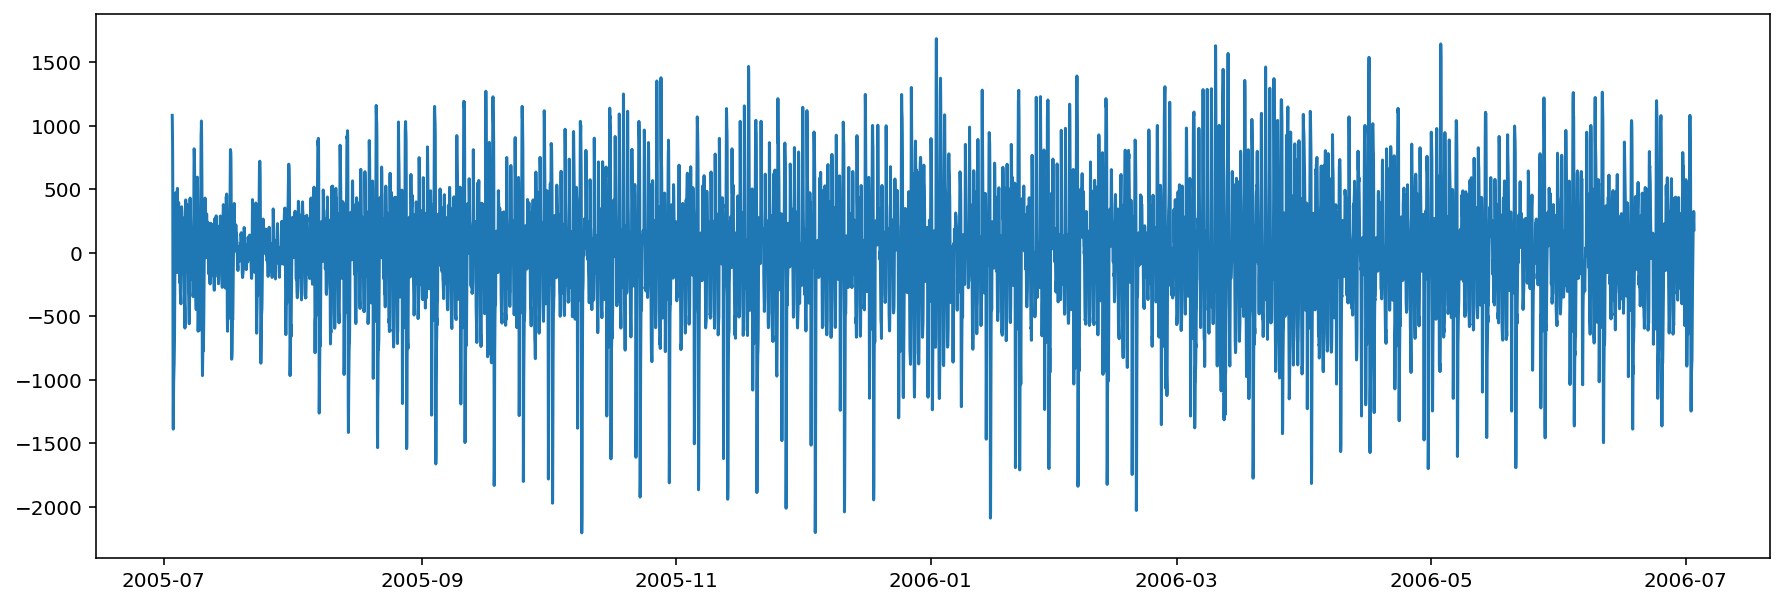

In [62]:
plt.plot(day_res[:24*365])

In [35]:
# remove part of data for easier additivity
year_seasonal = year_seasonal[366*24//2:-366*24//2]
year_trend = year_trend[24//2:-24//2]
day_seasonal = day_seasonal[24//2:-24//2]

In [36]:
res = (year_seasonal + year_trend + day_seasonal + day_trend + day_res).values

np.all((df[366*24//2:-366*24//2].load.values - res) < 1e-9)

True

In [37]:
# get test set

val_indeces = slice(-365*24, None)
train_test_indeces = slice(0, -365*24)

In [38]:
day_res.shape

(105167,)

### ARIMA model

In [39]:
def acf_plot(lag_acf, ts):
    #Plot ACF: 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function');
    plt.show()

In [40]:
def pacf_plot(lag_pacf, ts):
    #Plot PACF:
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout();
    plt.show()

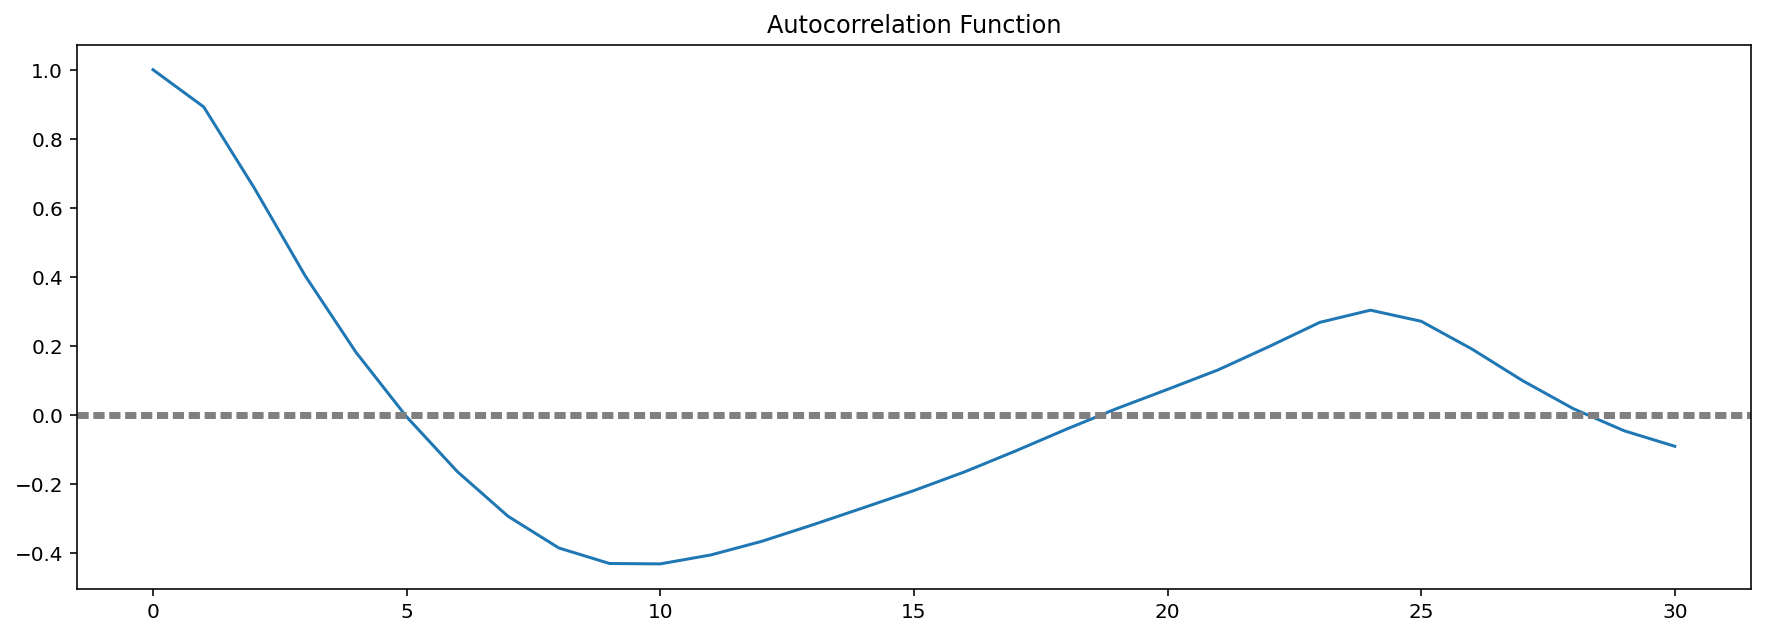

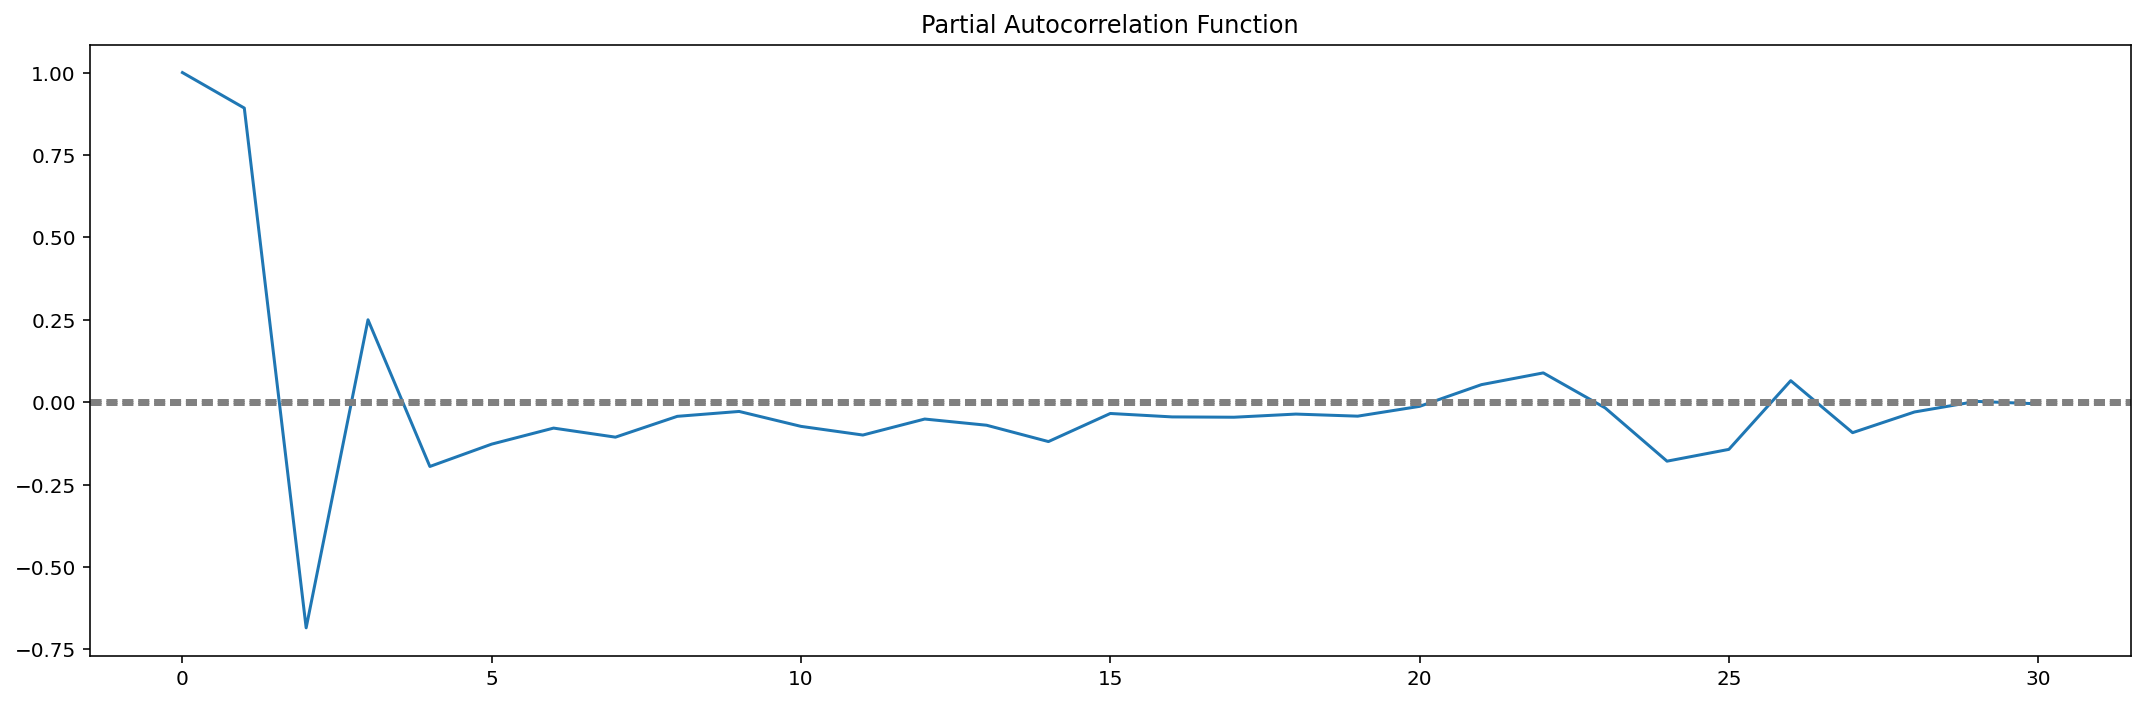

In [43]:
acf_plot(stattools.acf(day_res, nlags=30, fft=True), day_res)
pacf_plot(stattools.pacf(day_res, nlags=30, method='ols'), day_res)

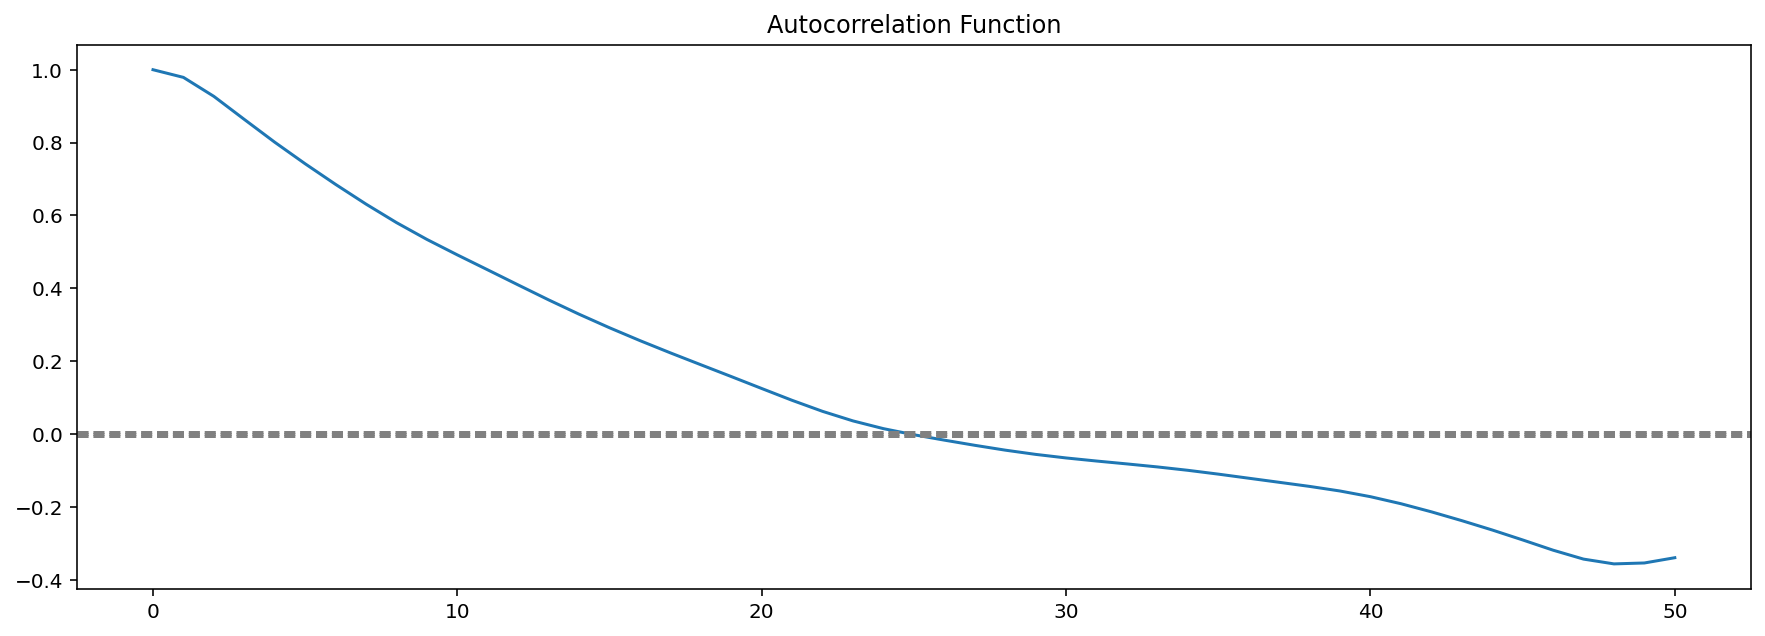

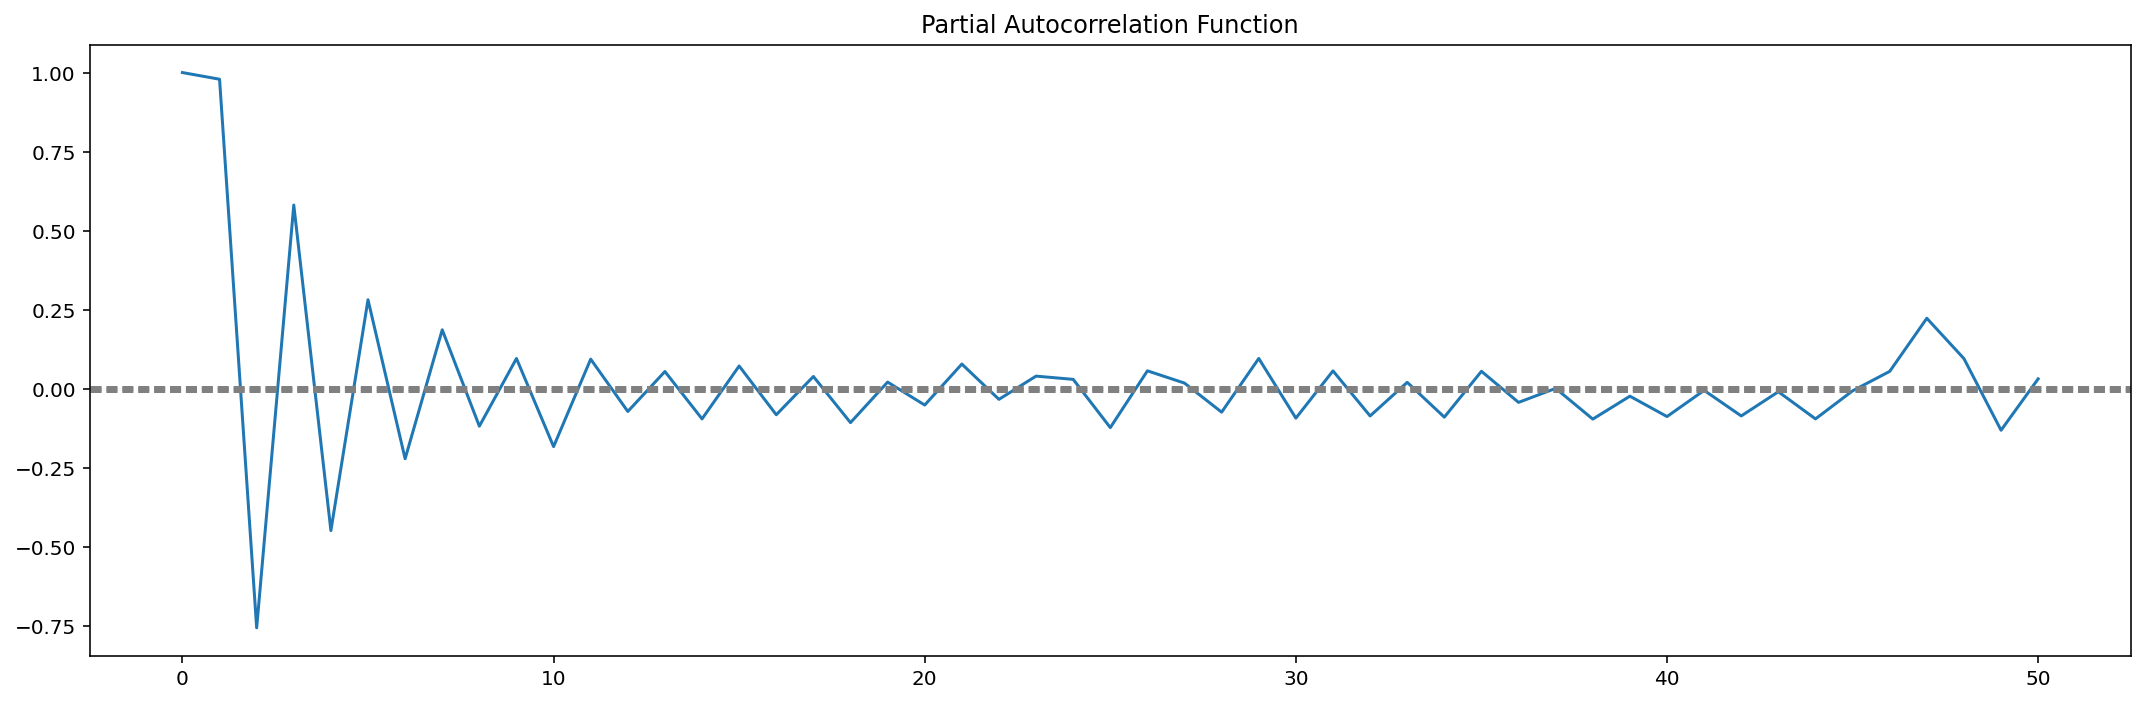

In [50]:
day_trend_diff = day_trend.diff(1)[1:]

acf_plot(stattools.acf(day_trend_diff, nlags=50, fft=True), day_res)
pacf_plot(stattools.pacf(day_trend_diff, nlags=50, method='ols'), day_res)

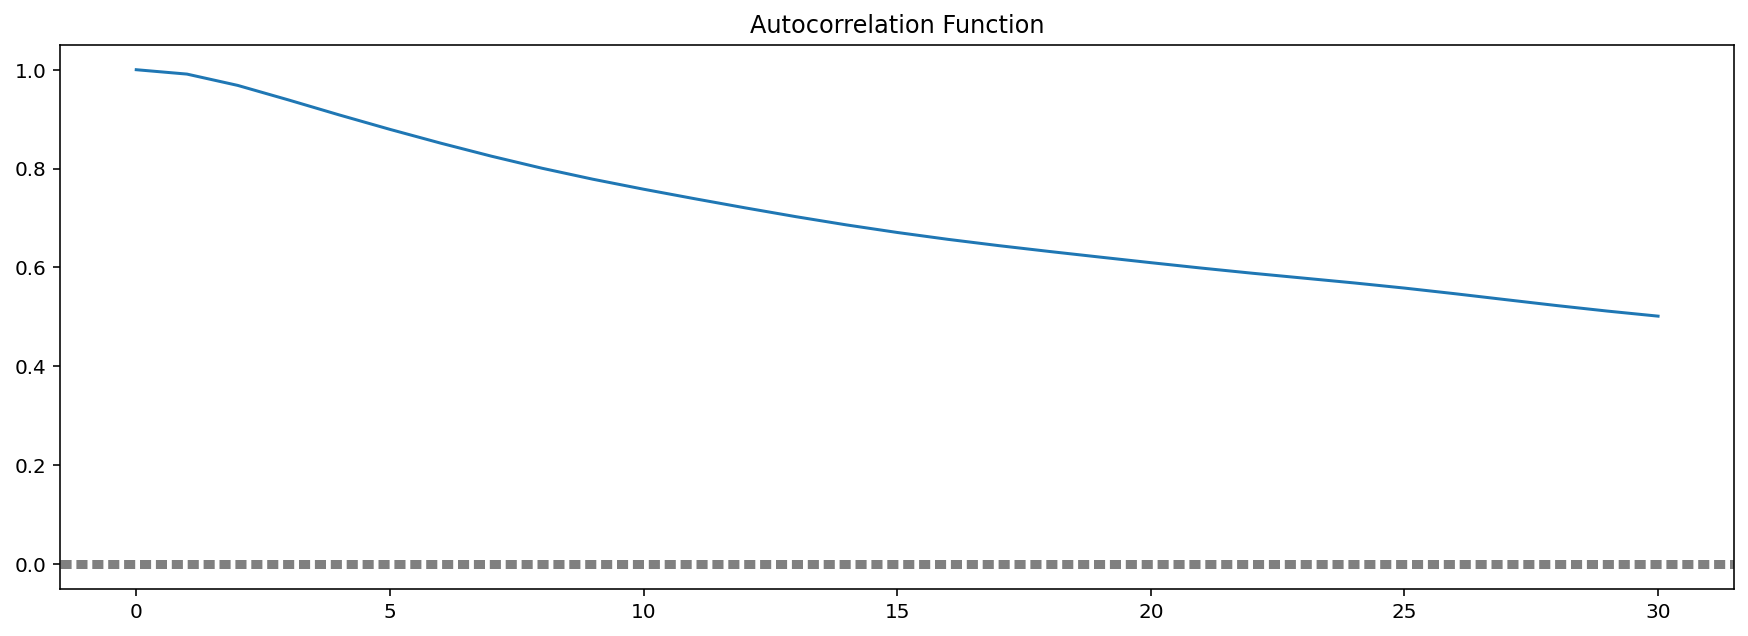

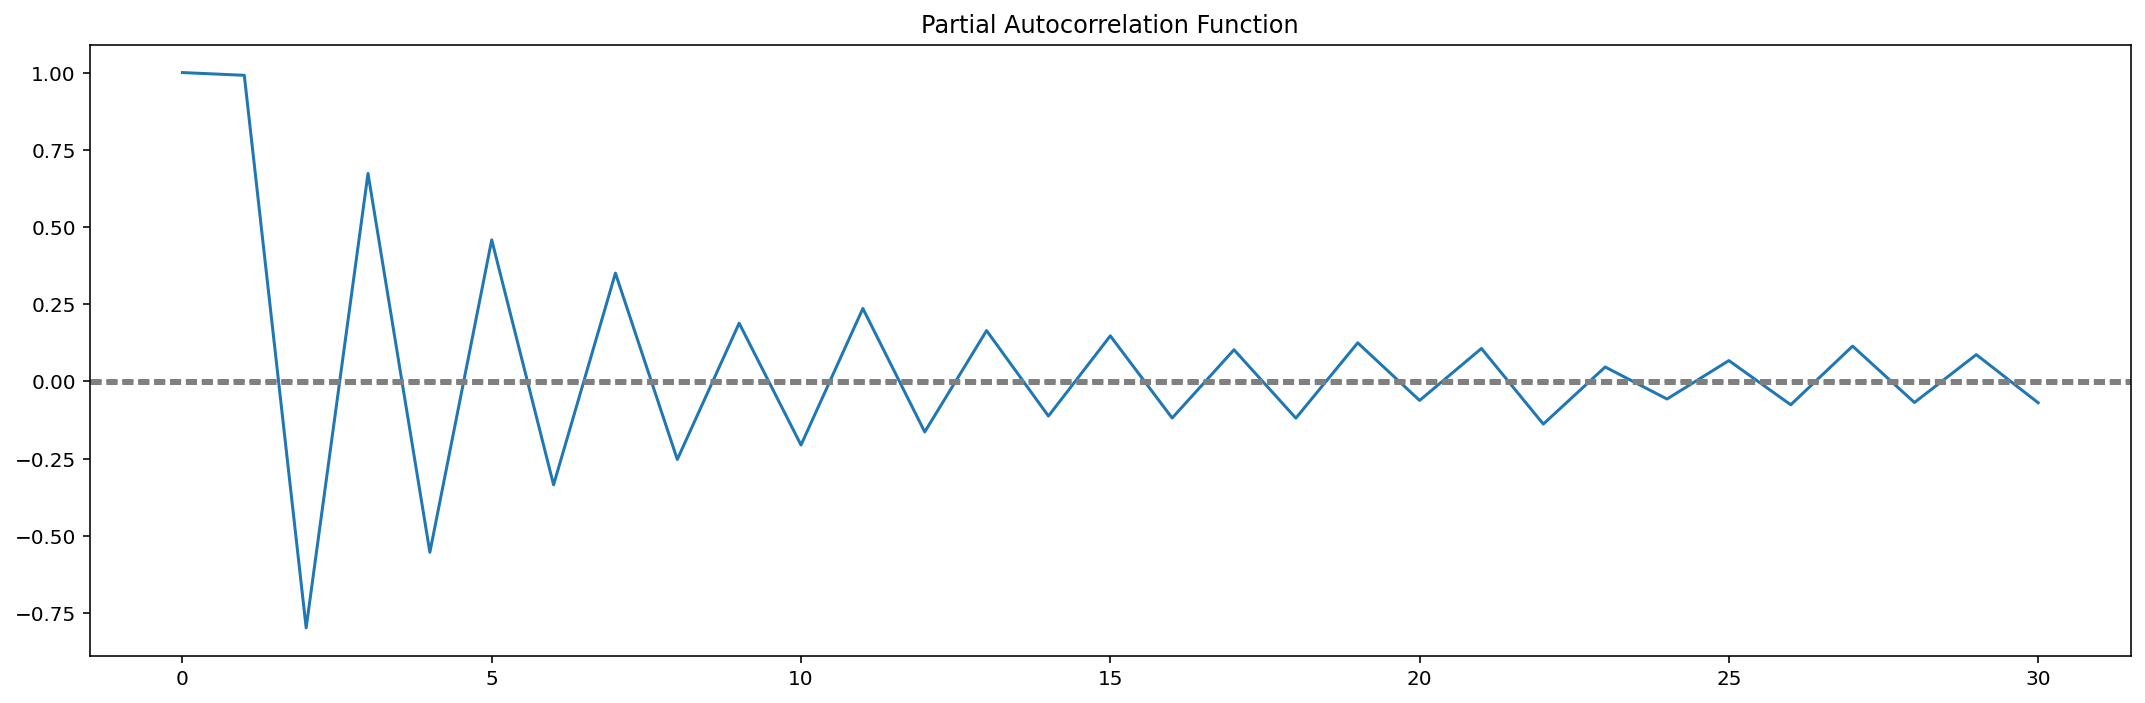

In [54]:
year_trend_diff = year_trend.diff(2)[2:]

acf_plot(stattools.acf(year_trend_diff, nlags=30, fft=True), day_res)
pacf_plot(stattools.pacf(year_trend_diff, nlags=30, method='ols'), day_res)

  0%|          | 0/24 [00:00<?, ?it/s]/home/developer/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
  0%|          | 0/24 [00:00<?, ?it/s]/home/developer/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
100%|██████████| 24/24 [03:31<00:00,  8.79s/it]


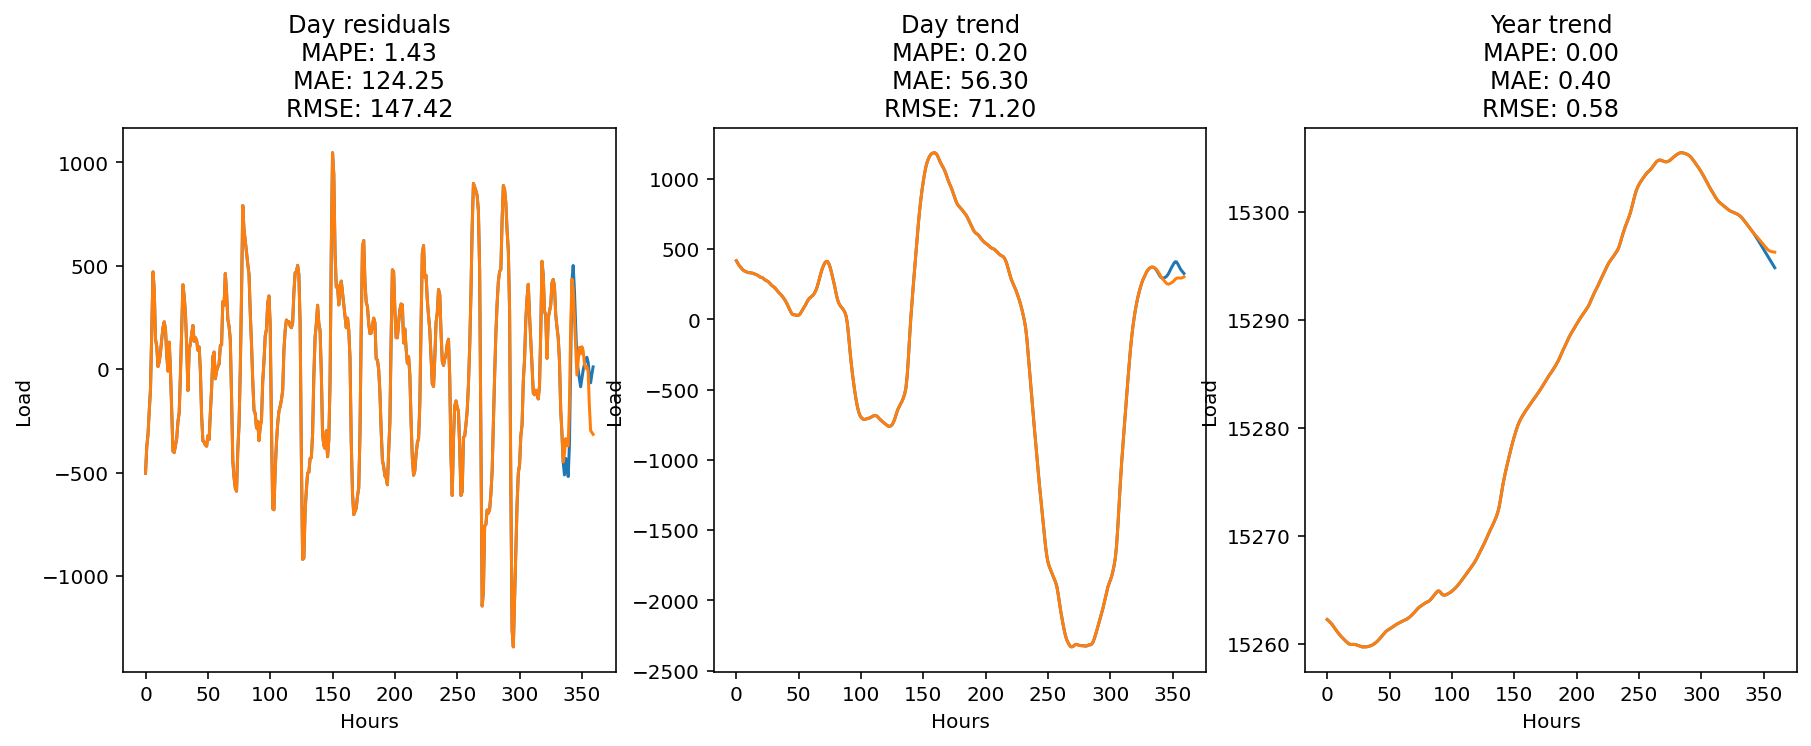

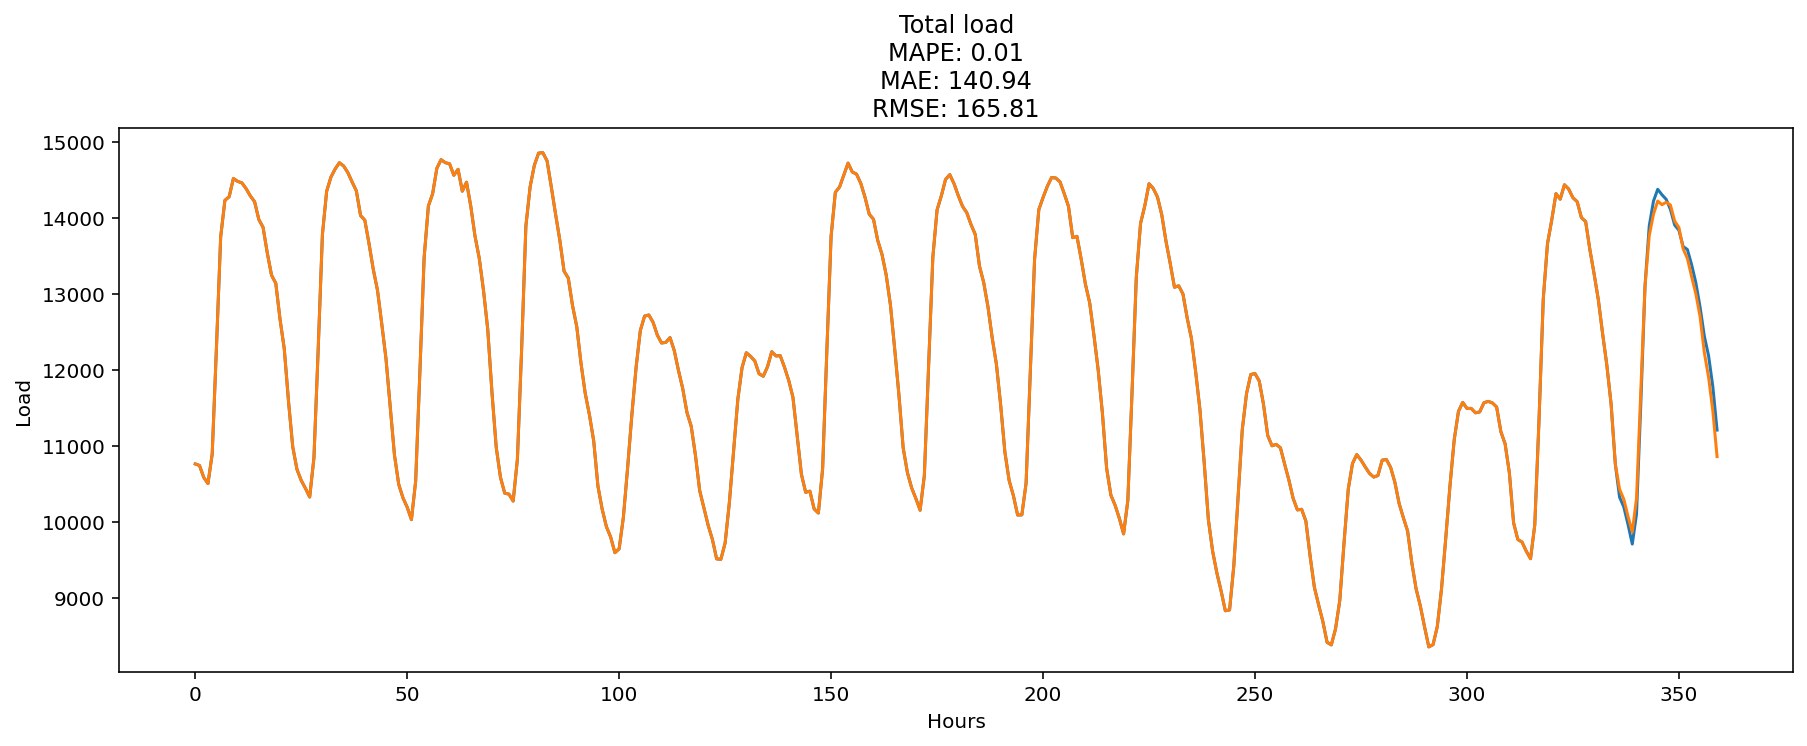

  0%|          | 0/24 [00:00<?, ?it/s]/home/developer/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
  0%|          | 0/24 [00:00<?, ?it/s]/home/developer/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
100%|██████████| 24/24 [03:01<00:00,  7.56s/it]


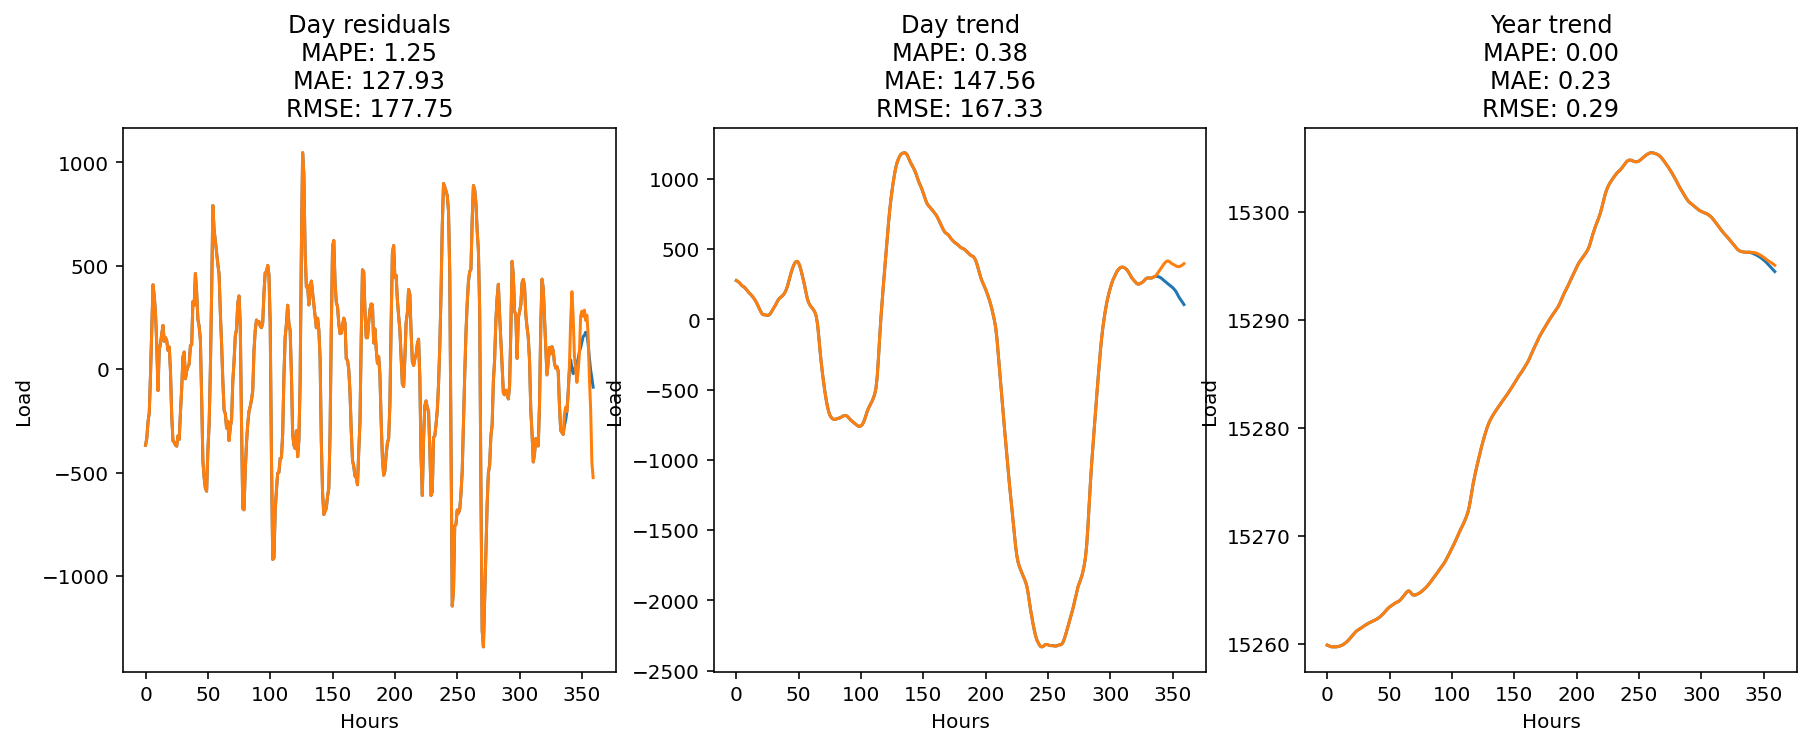

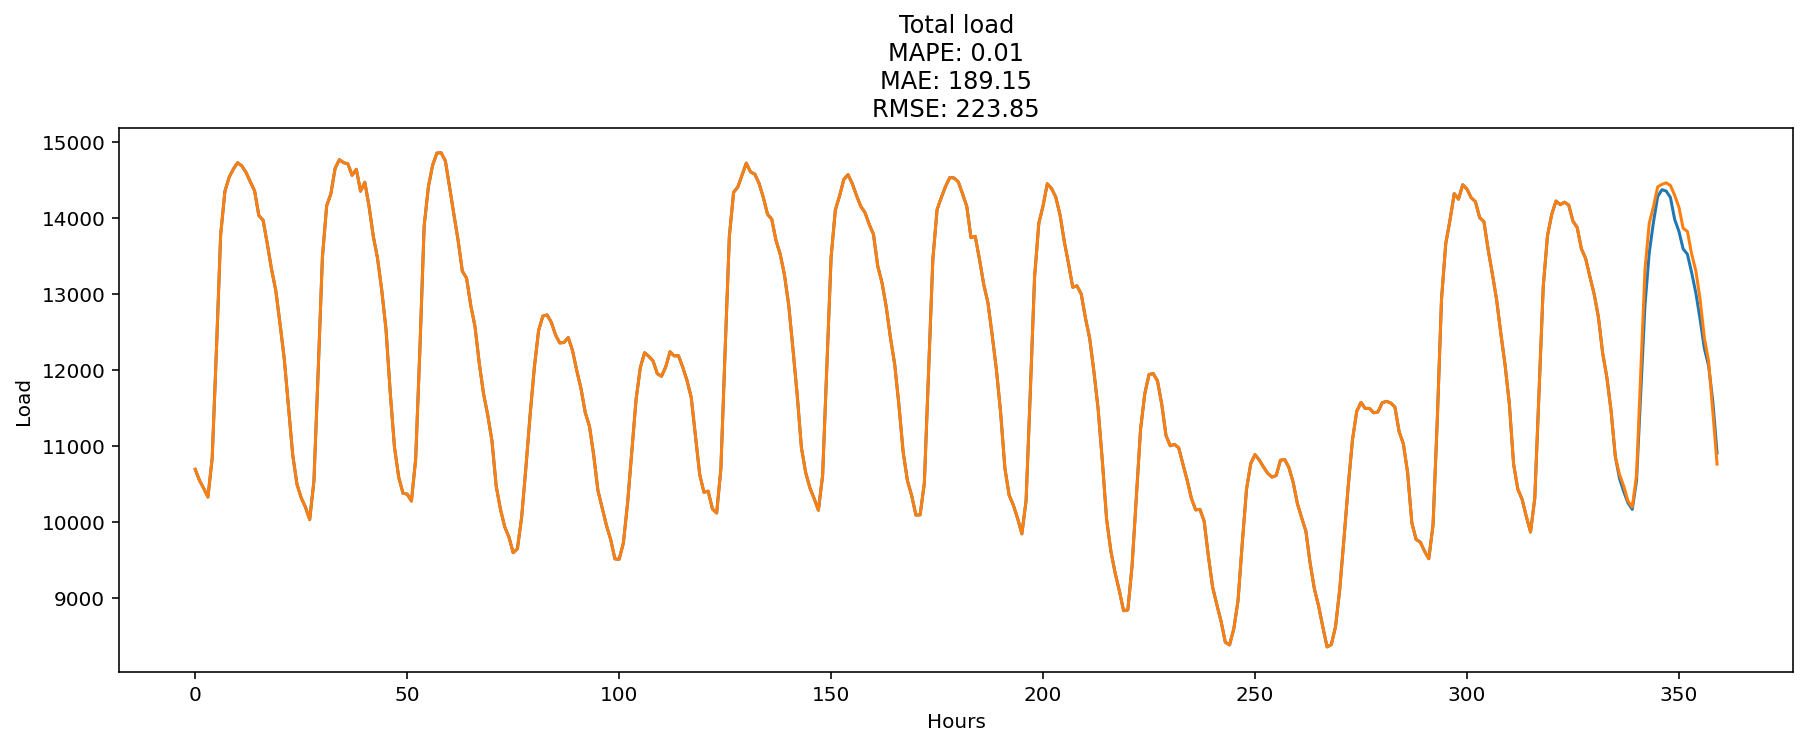

  0%|          | 0/24 [00:00<?, ?it/s]/home/developer/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
  0%|          | 0/24 [00:00<?, ?it/s]/home/developer/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
  0%|          | 0/24 [00:00<?, ?it/s]/home/developer/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
100%|██████████| 24/24 [03:44<00:00,  9.37s/it]


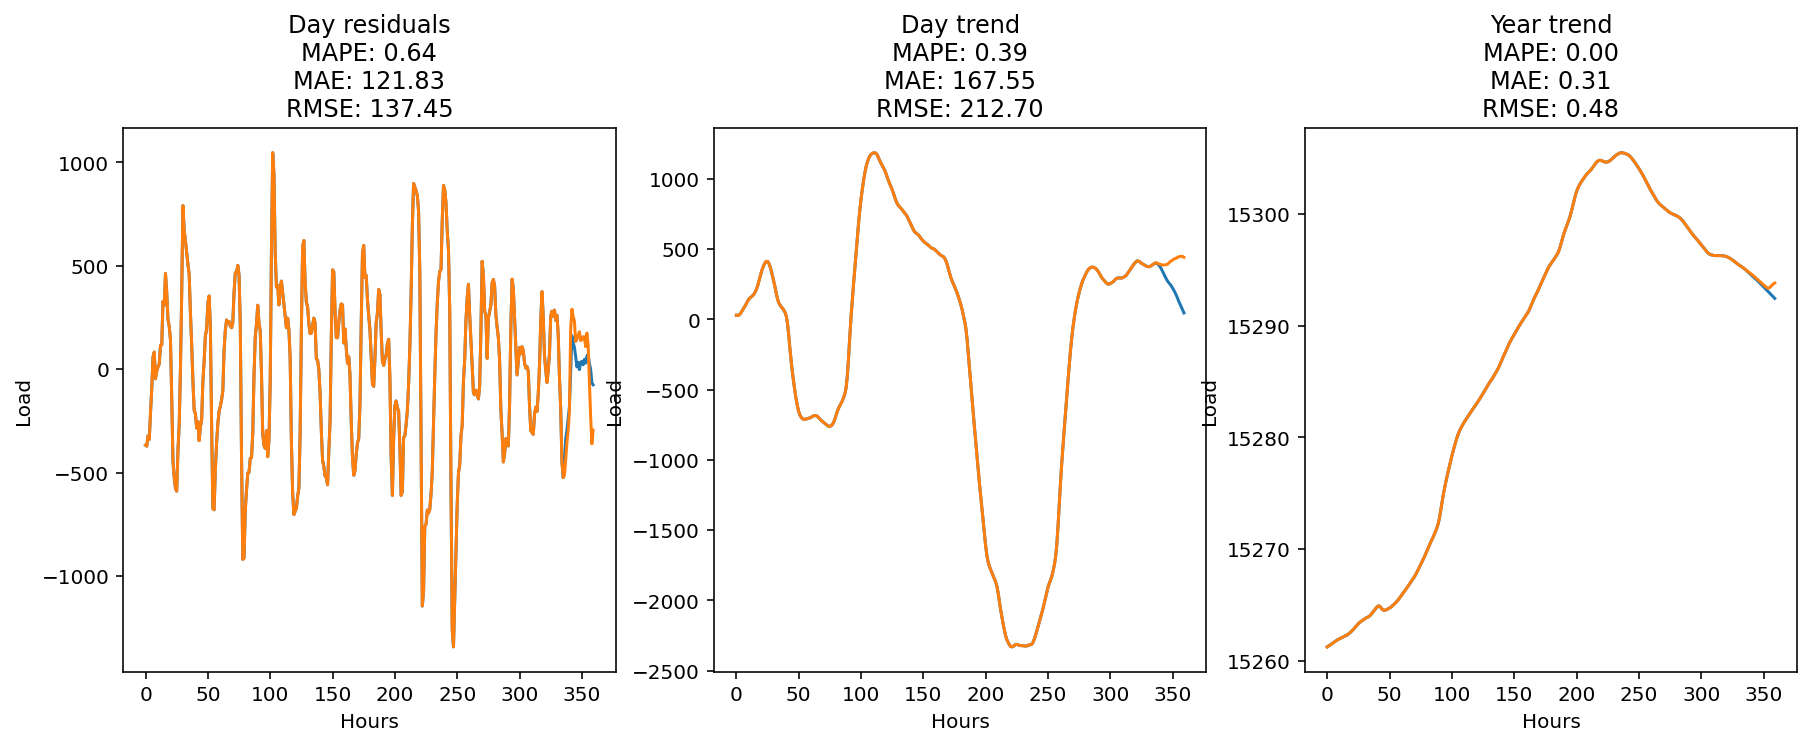

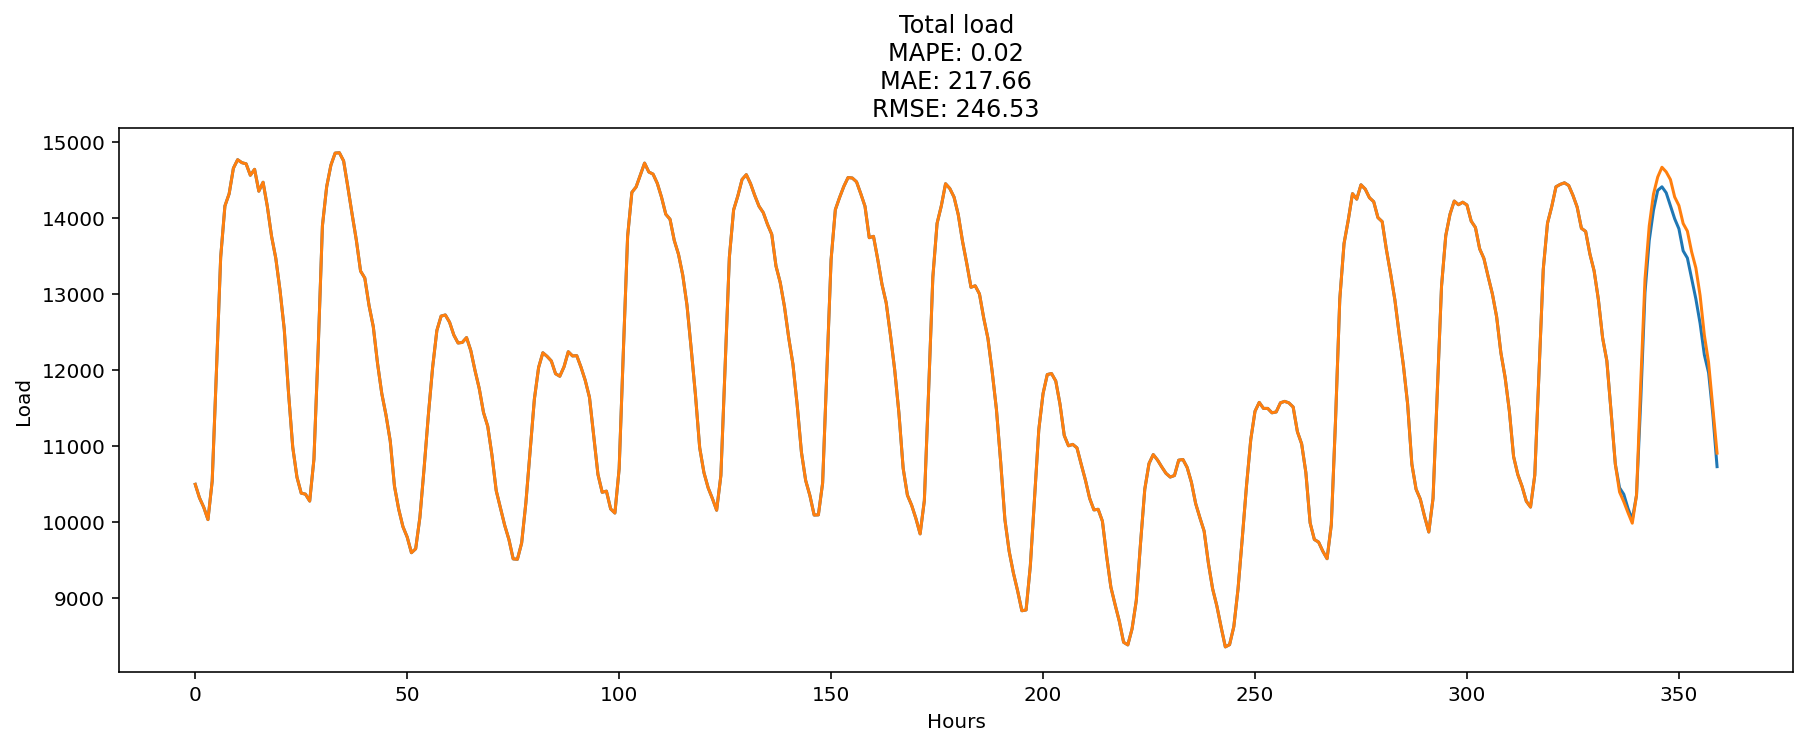

  0%|          | 0/24 [00:00<?, ?it/s]/home/developer/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
  0%|          | 0/24 [00:00<?, ?it/s]/home/developer/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
100%|██████████| 24/24 [03:50<00:00,  9.62s/it]


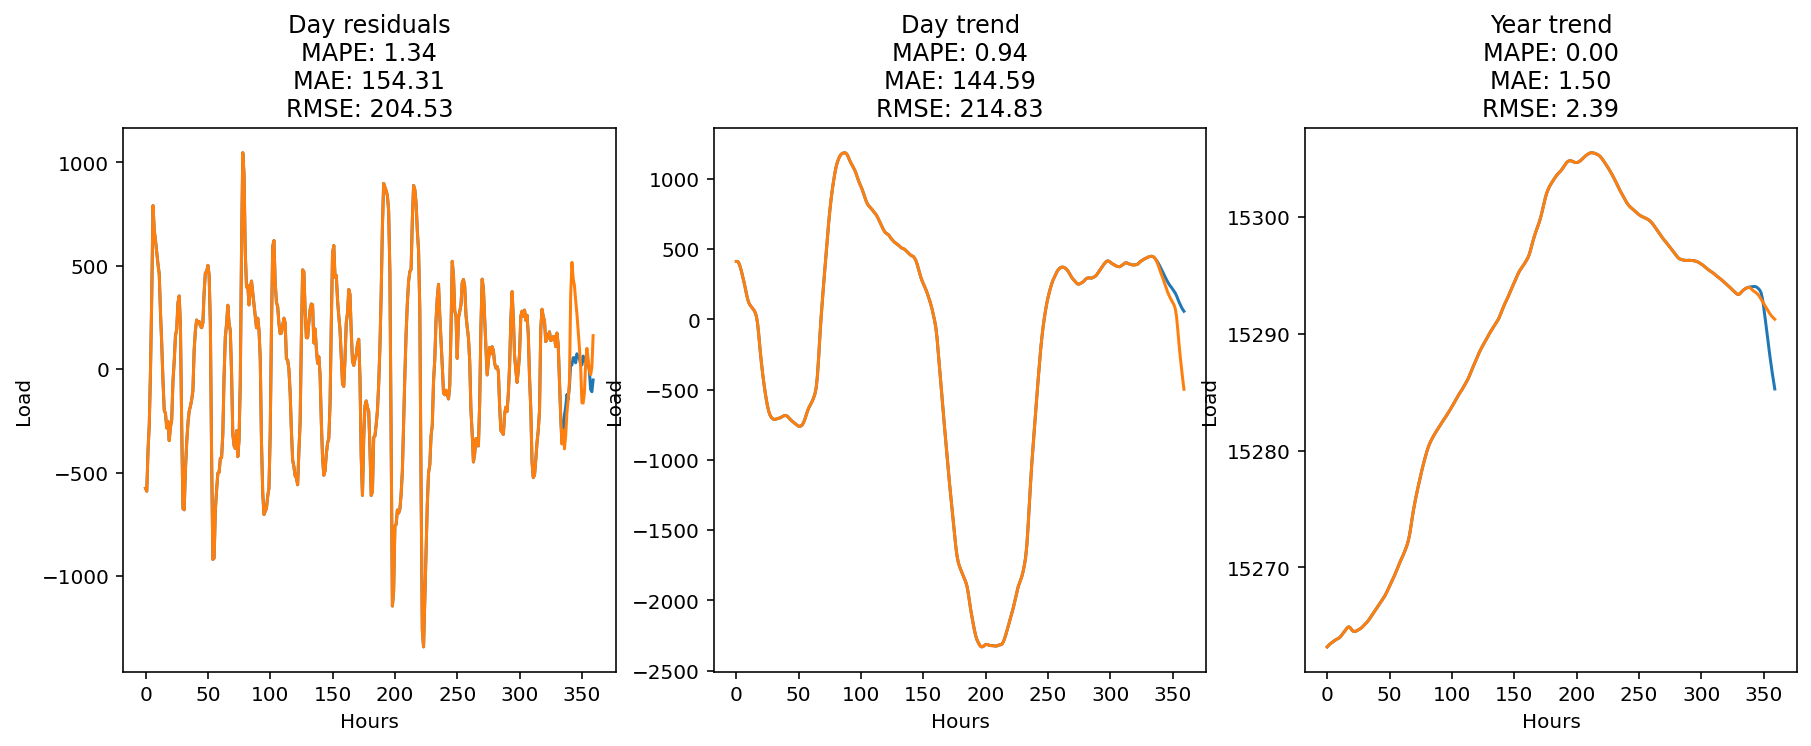

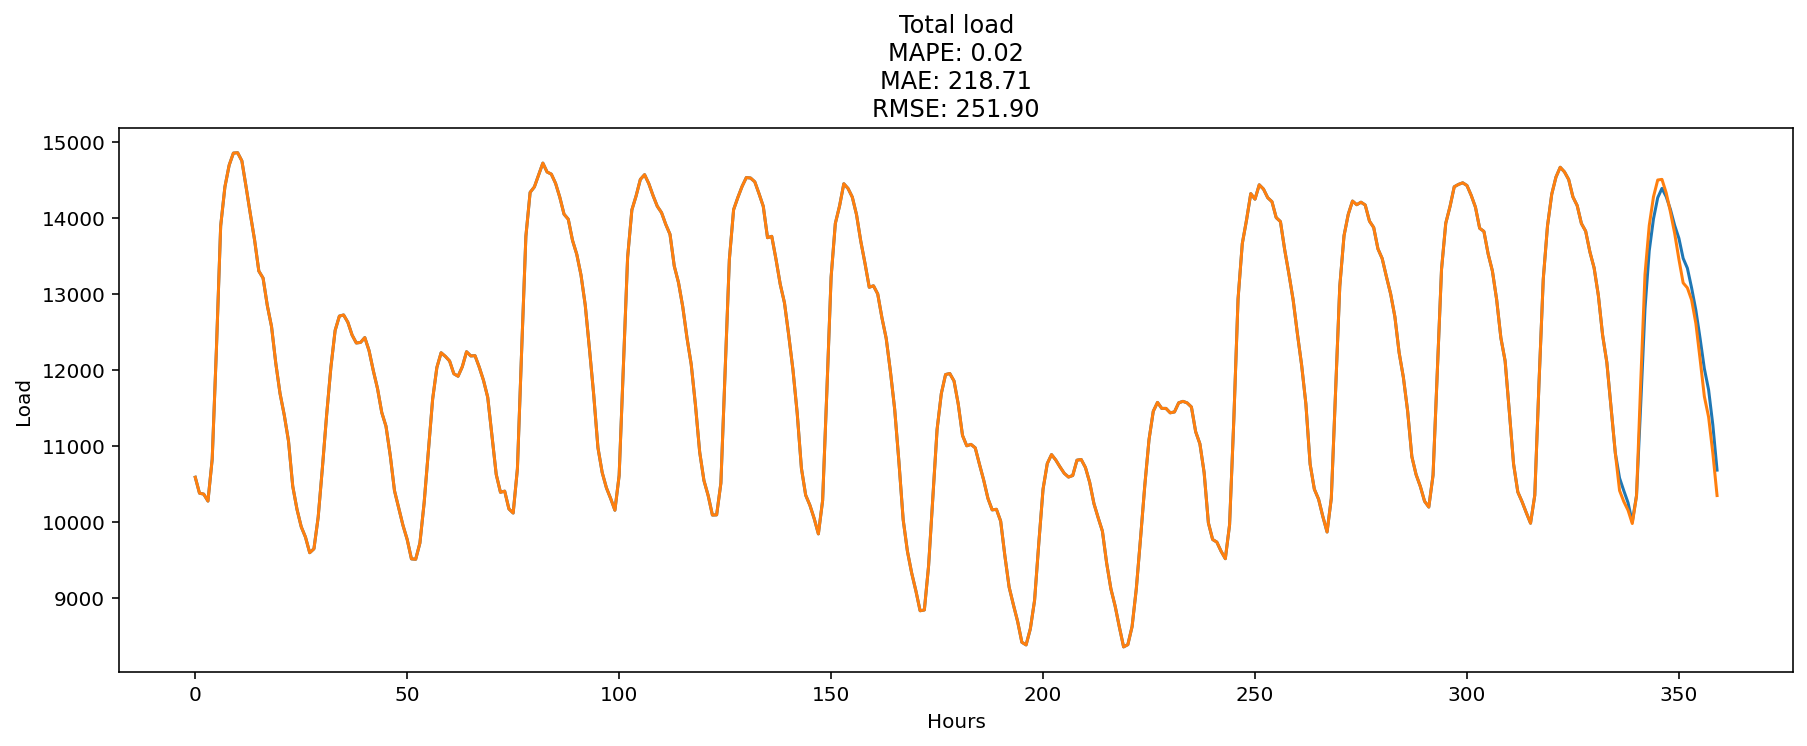

In [123]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from tqdm import tqdm

def predict_arima(Model, model_params, ts, train_indeces, val_indeces):
    train_val = ts[train_indeces].values
    predicted = np.array([])
    for val_index in tqdm(val_indeces):
        model = Model(np.append(train_val, predicted), **model_params)
#         model = ARIMA(train_val, order=(9, 0, 24))
        model_fit = model.fit(method_kwargs={"warn_convergence": False})
        res = model_fit.forecast(1)
        train_indeces = np.append(train_indeces, val_index)
        predicted = np.append(predicted, res[0])
        
    return np.array(predicted)

def plot_predicted(ts, predicted, train_indeces, val_indeces, ax, title):
    ax.plot(np.append(ts[train_indeces], predicted))
    ax.plot(ts[np.append(train_indeces, val_indeces)].values)
    ax.set_ylabel('Load')
    ax.set_xlabel('Hours')
    ax.set_title(title)
    

week = 24*7
day = 24
tscv = TimeSeriesSplit(max_train_size=2*week, n_splits=4, test_size=day)
ts = day_res
for train_indeces, val_indeces in tscv.split(ts[train_test_indeces]):
    fig, axs = plt.subplots(1, 3, sharex=True)
    
    predicted_day_r = predict_arima(ARIMA, {'order': (9, 0, 24)}, day_res, train_indeces, val_indeces)
    rmse = mean_squared_error(day_res[val_indeces], predicted_day_r, squared=False)
    mae = mean_absolute_error(day_res[val_indeces], predicted_day_r)
    mape = mean_absolute_percentage_error(day_res[val_indeces], predicted_day_r)
    plot_predicted(day_res, predicted_day_r, train_indeces, val_indeces, axs[0], f'Day residuals\nMAPE: {mape:.2f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}')
    
    predicted_day_t = predict_arima(ARIMA, {'order': (9, 0, 24)}, day_trend, train_indeces, val_indeces)
    mape = mean_absolute_percentage_error(day_trend[val_indeces], predicted_day_t)
    mae = mean_absolute_error(day_trend[val_indeces], predicted_day_t)
    rmse = mean_squared_error(day_trend[val_indeces], predicted_day_t, squared=False)
    plot_predicted(day_trend, predicted_day_t, train_indeces, val_indeces, axs[1], f'Day trend\nMAPE: {mape:.2f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}')
    
    predicted_year_t = predict_arima(ARIMA, {'order': (9, 0, 24)}, year_trend, train_indeces, val_indeces)
    mape = mean_absolute_percentage_error(year_trend[val_indeces], predicted_year_t)
    mae = mean_absolute_error(year_trend[val_indeces], predicted_year_t)
    rmse = mean_squared_error(year_trend[val_indeces], predicted_year_t, squared=False)
    plot_predicted(year_trend, predicted_year_t, train_indeces, val_indeces, axs[2], f'Year trend\nMAPE: {mape:.2f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}')
    
    plt.show()
    
    
    fig, ax = plt.subplots()
    #total
    total = year_seasonal + year_trend + day_seasonal + day_trend + day_res
    predicted_t = year_seasonal[val_indeces] + predicted_year_t + day_seasonal[val_indeces] + predicted_day_t + predicted_day_r
    mape = mean_absolute_percentage_error(total[val_indeces], predicted_t)
    mae = mean_absolute_error(total[val_indeces], predicted_t)
    rmse = mean_squared_error(total[val_indeces], predicted_t, squared=False)
    plot_predicted(total, predicted_t, train_indeces, val_indeces, ax, f'Total load\nMAPE: {mape:.2f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}')
    
    plt.show()

### LSTM

### Using same value from previous year

In [117]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def predict_lstm(ts, train_indeces, val_indeces):
    
    n_steps = 24
    X_train, y_train = split_sequence(ts.iloc[train_indeces].values, n_steps)
    X_val, y_val = split_sequence(ts.iloc[val_indeces].values, n_steps)
    
    n_features = 1
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
    
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    model.fit(X_train, y_train, epochs=50, verbose=0)

    predicted = np.array([])
    for _ in tqdm(range(X_val.shape[1]+1)):
        res = model.predict(X_val)
        pred_res = model.predict(X_val)
        pred_res = pred_res.reshape(X_val.shape[0], 1, 1)
        X_val = np.concatenate([X_val, pred_res], axis=1)[:, 1:, :]
        
        predicted = np.append(predicted, res[0][0])
        
    return np.array(predicted)

100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


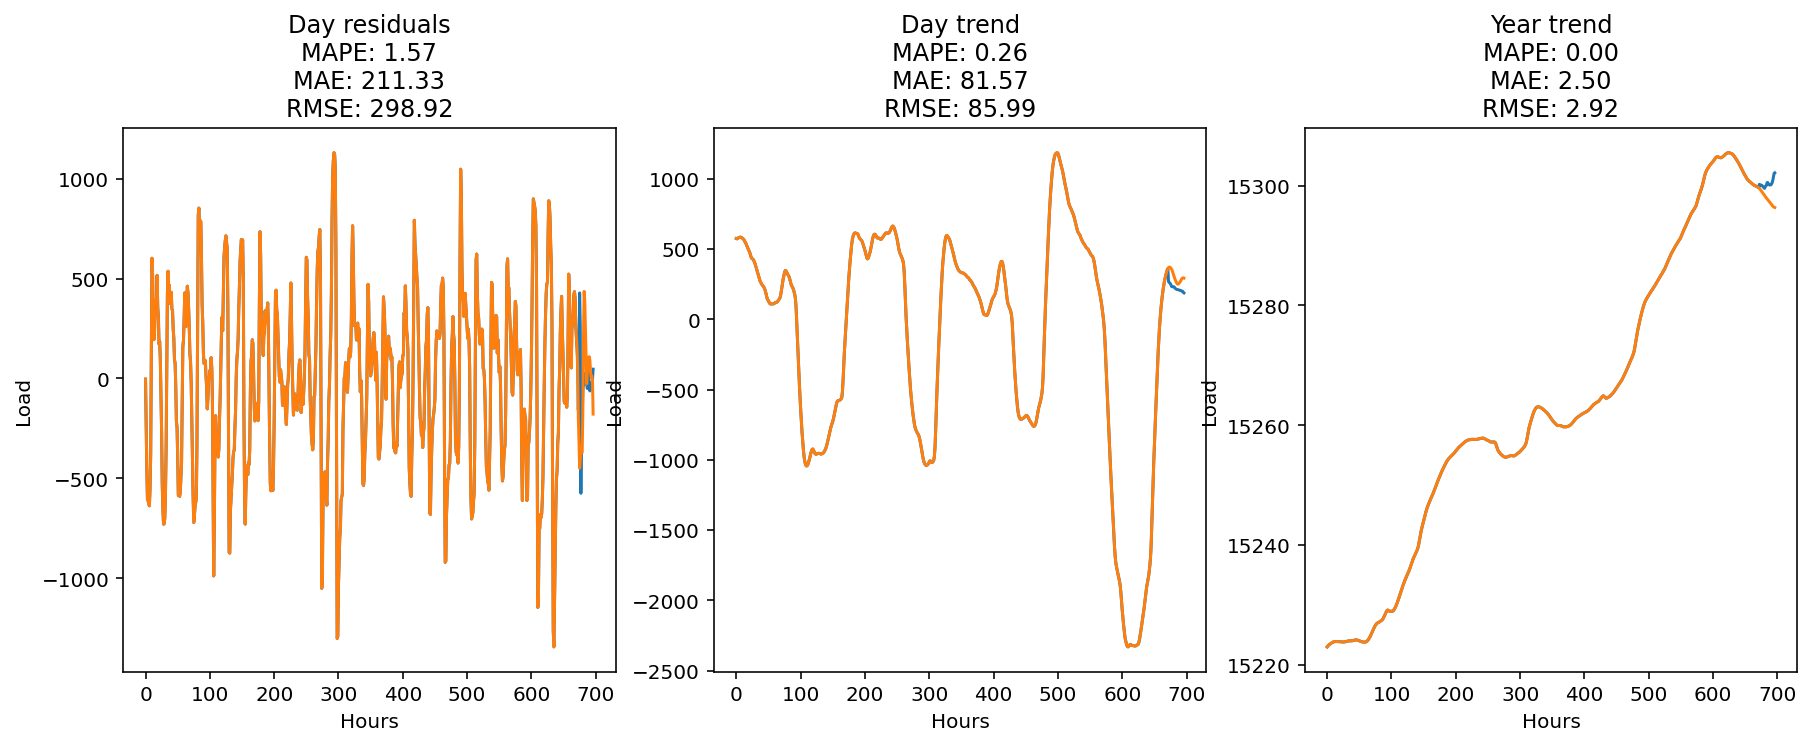

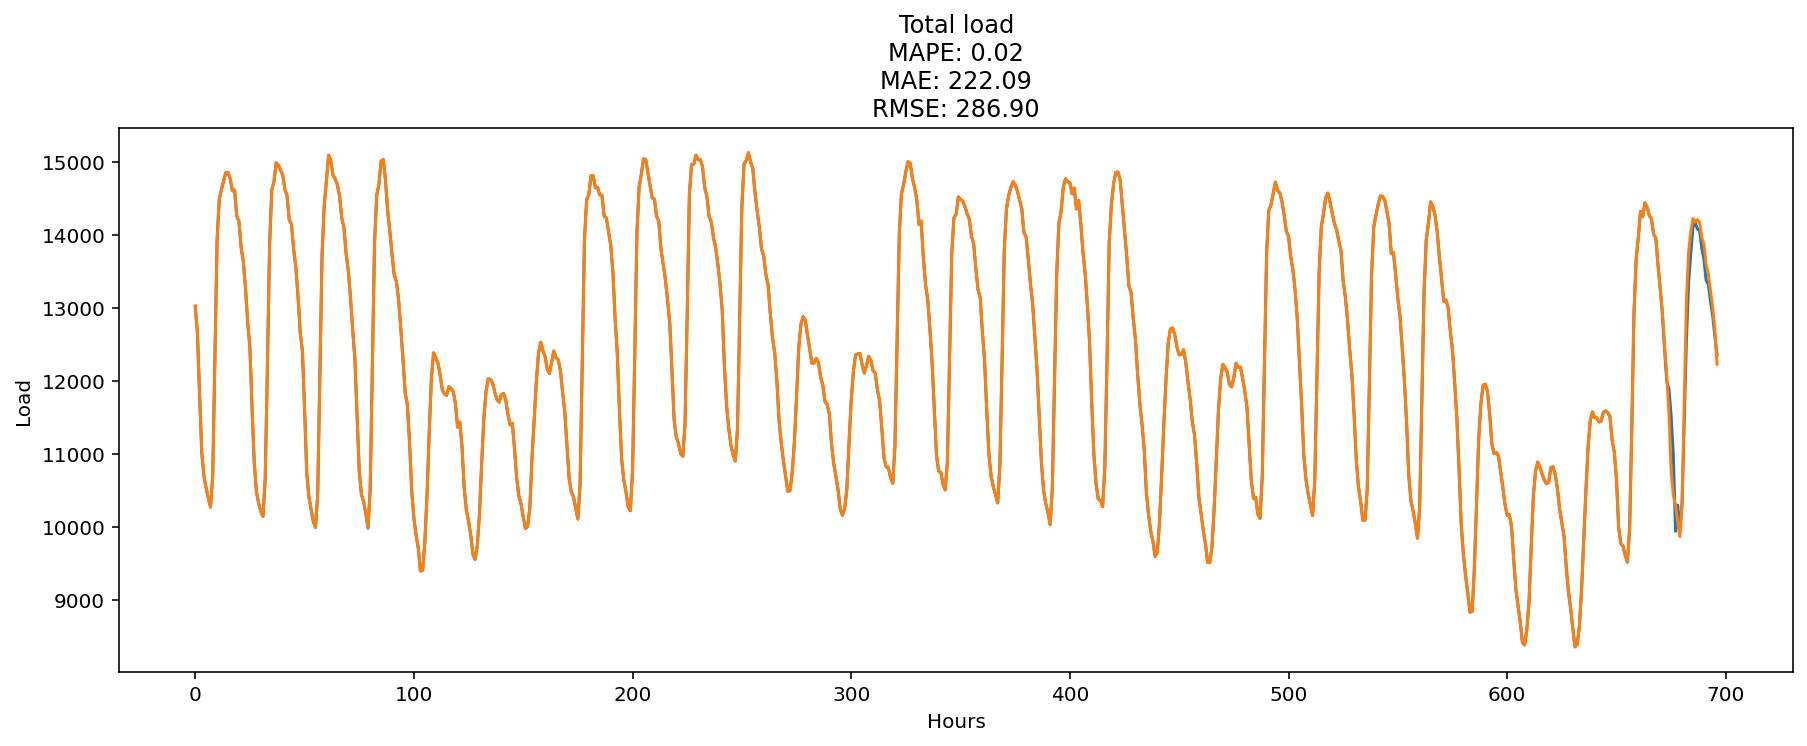

100%|██████████| 25/25 [00:02<00:00, 11.09it/s]


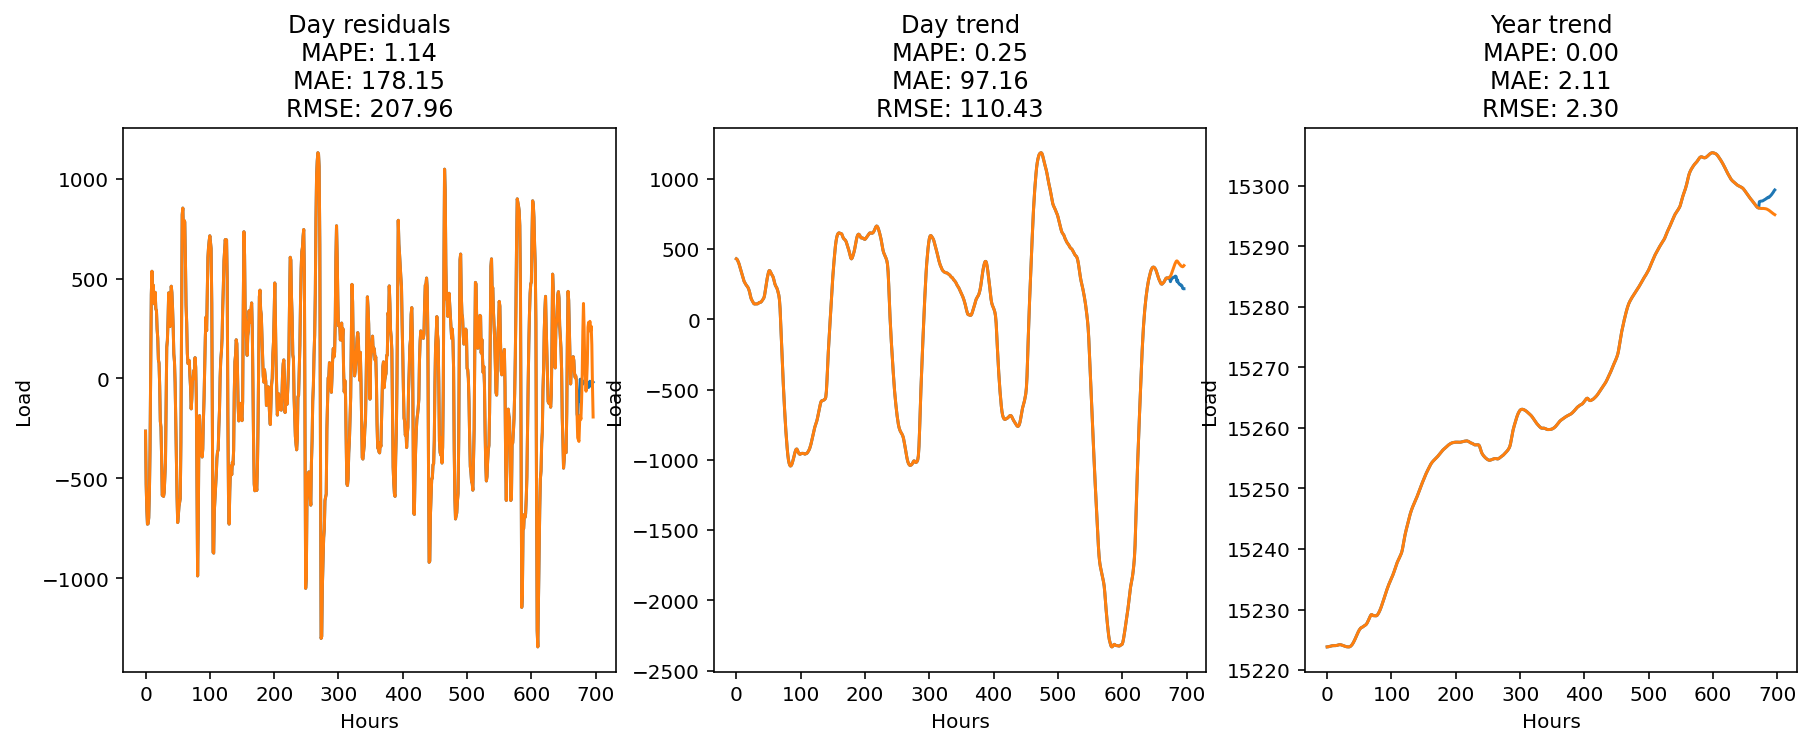

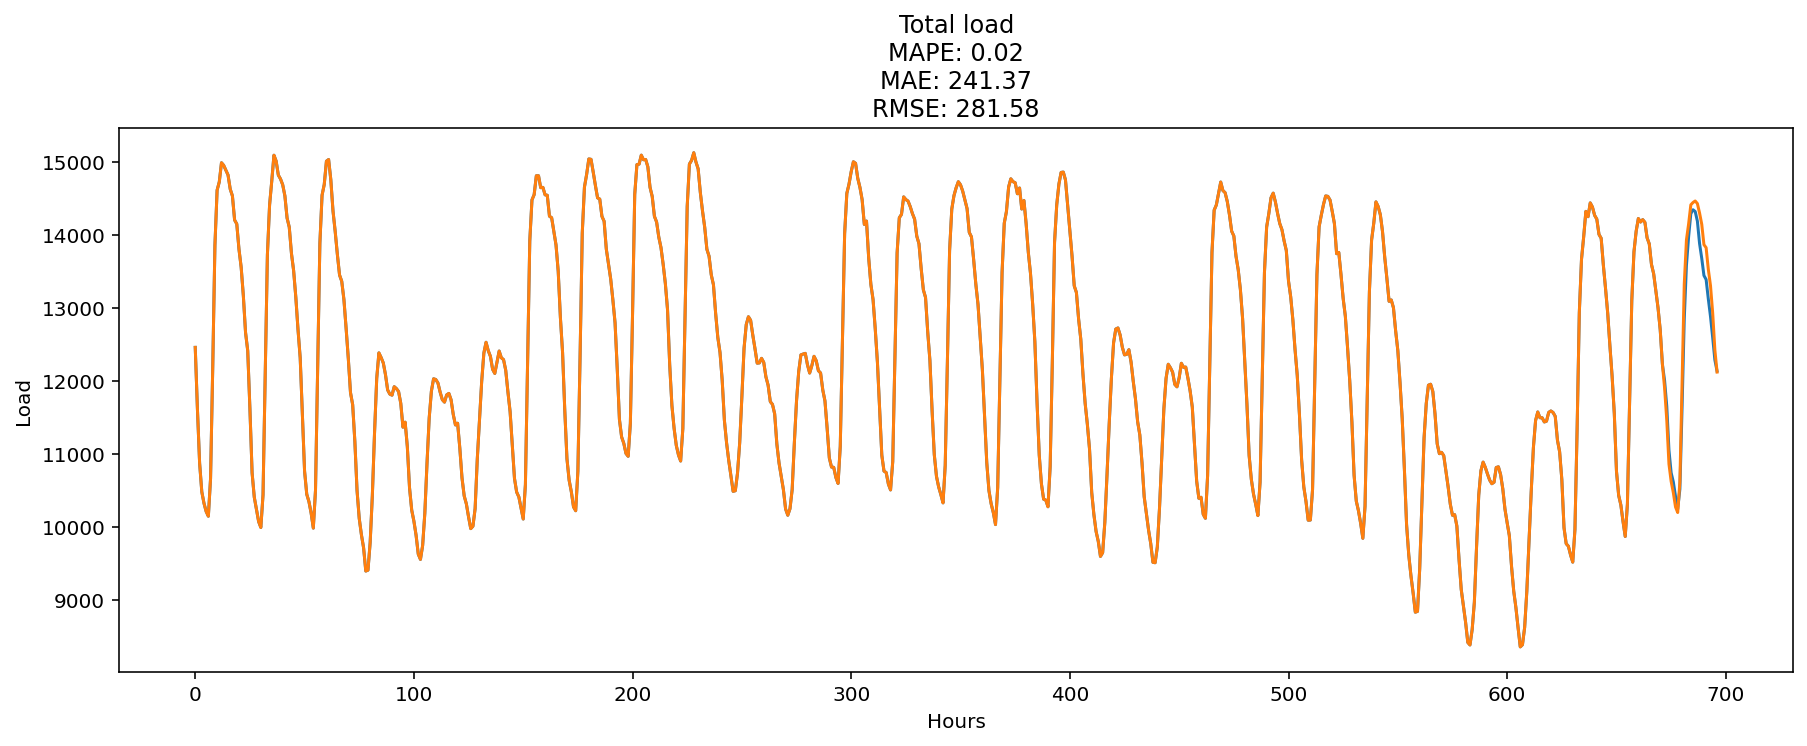

100%|██████████| 25/25 [00:02<00:00, 10.39it/s]


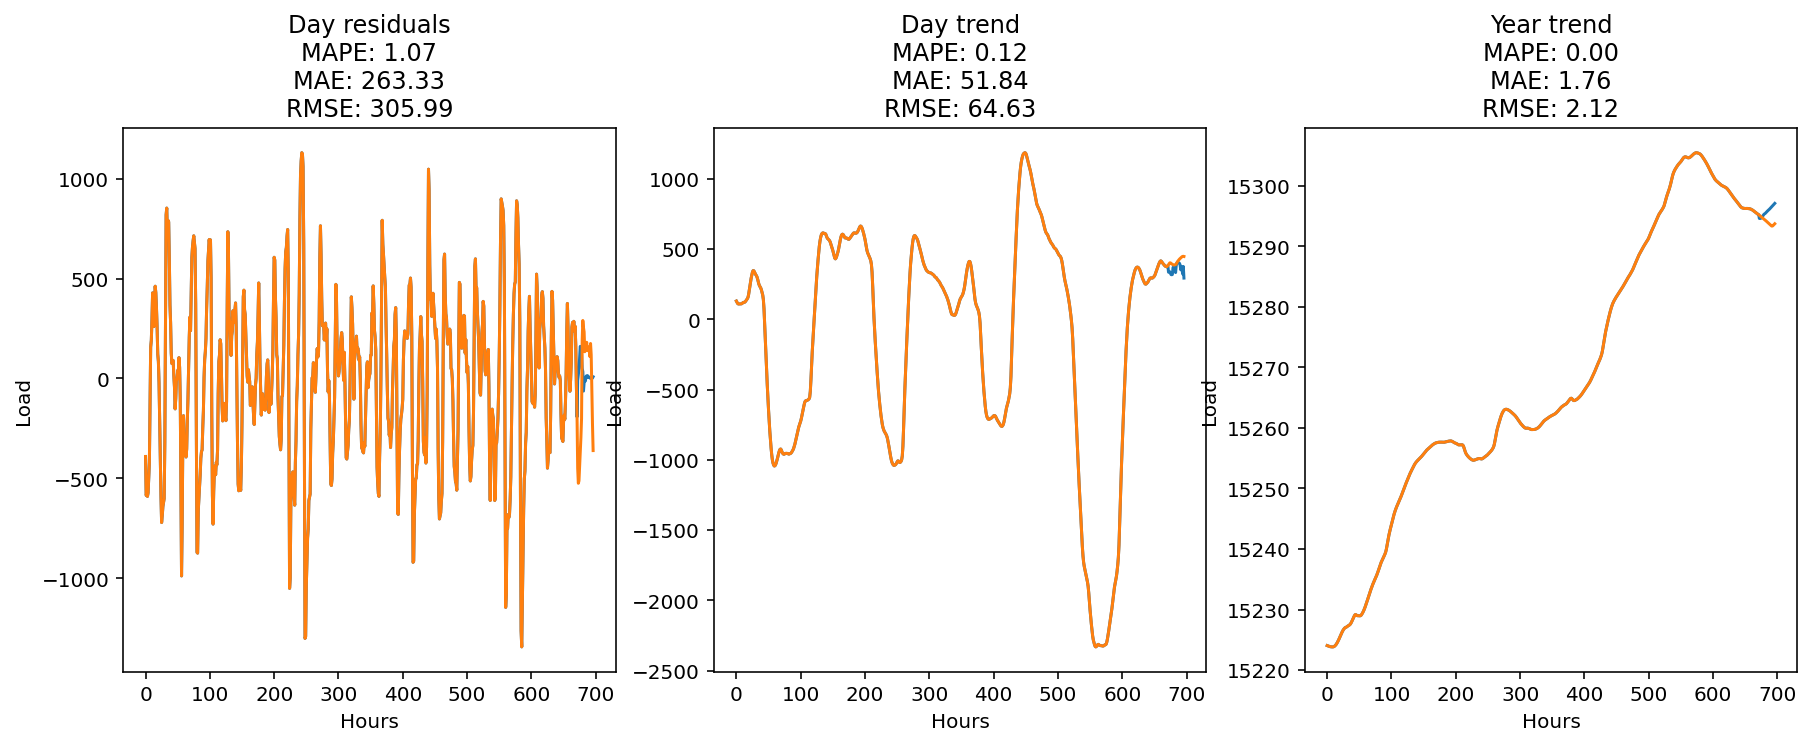

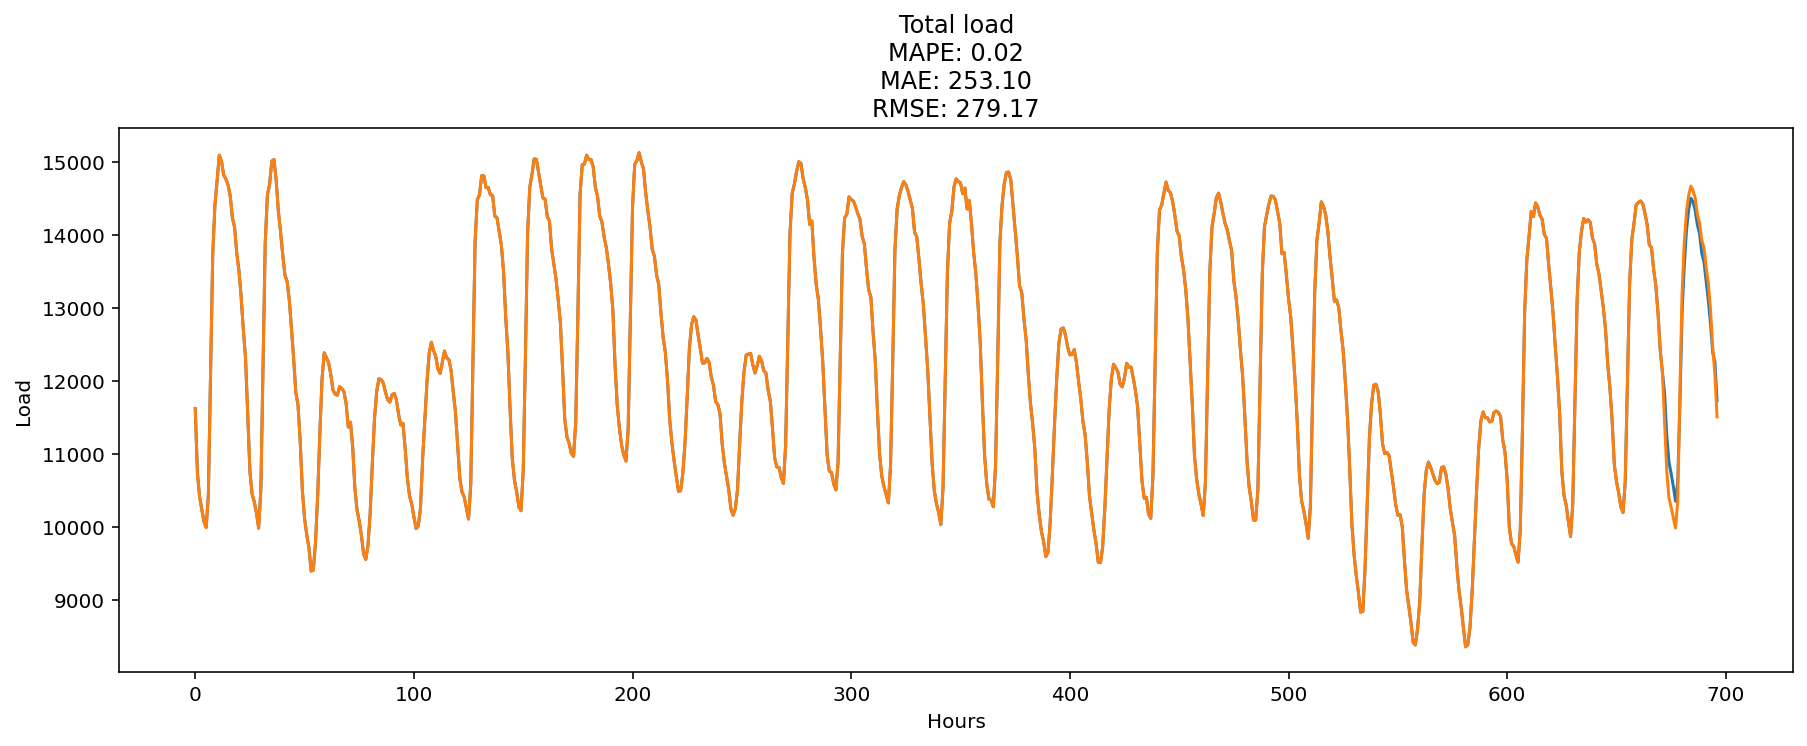

100%|██████████| 25/25 [00:03<00:00,  7.67it/s]


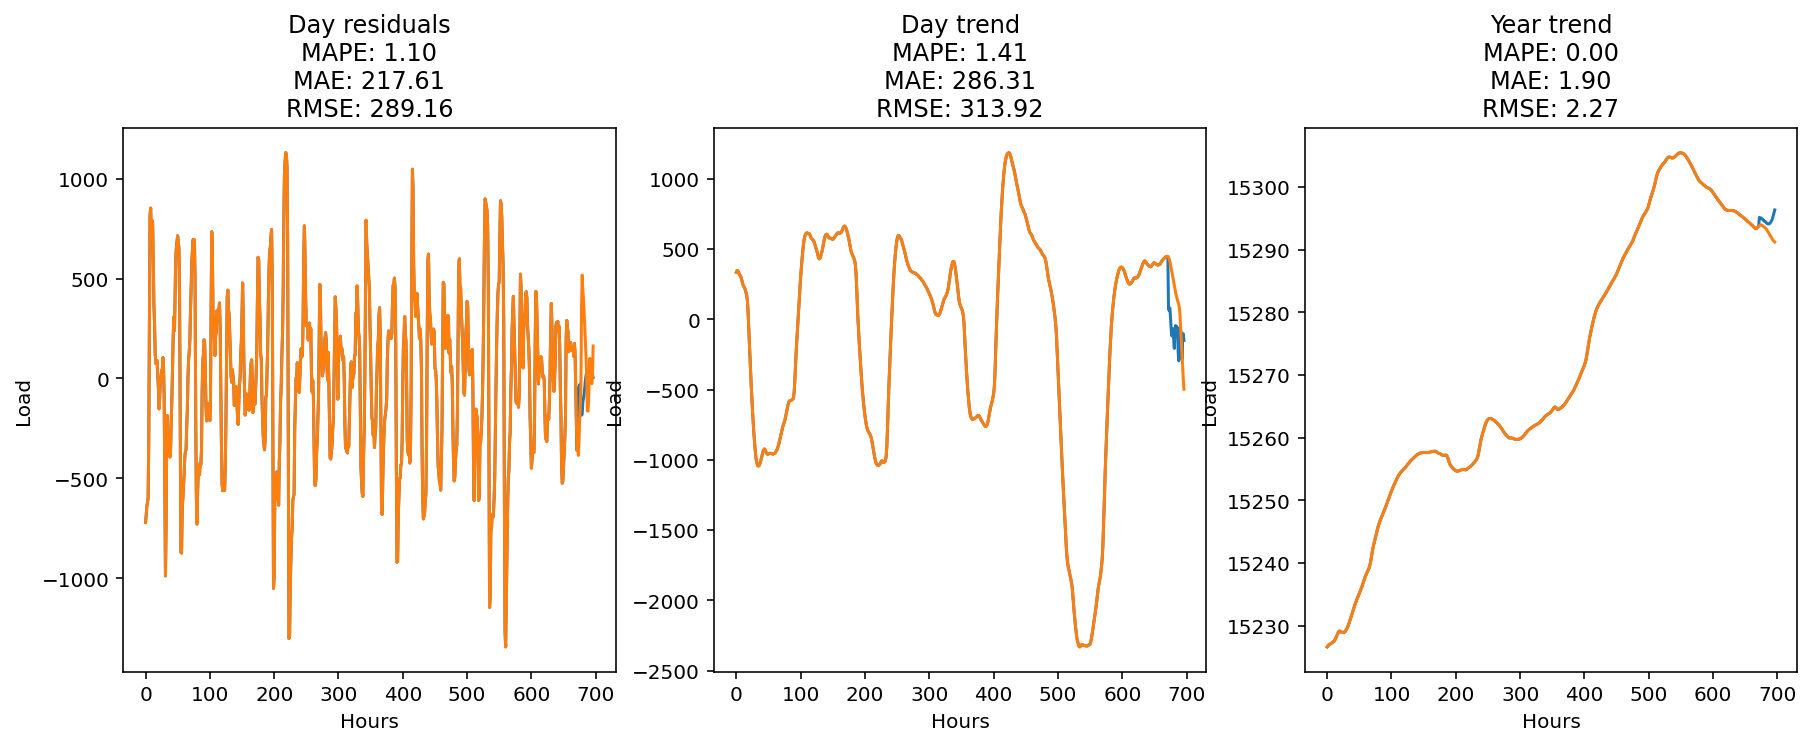

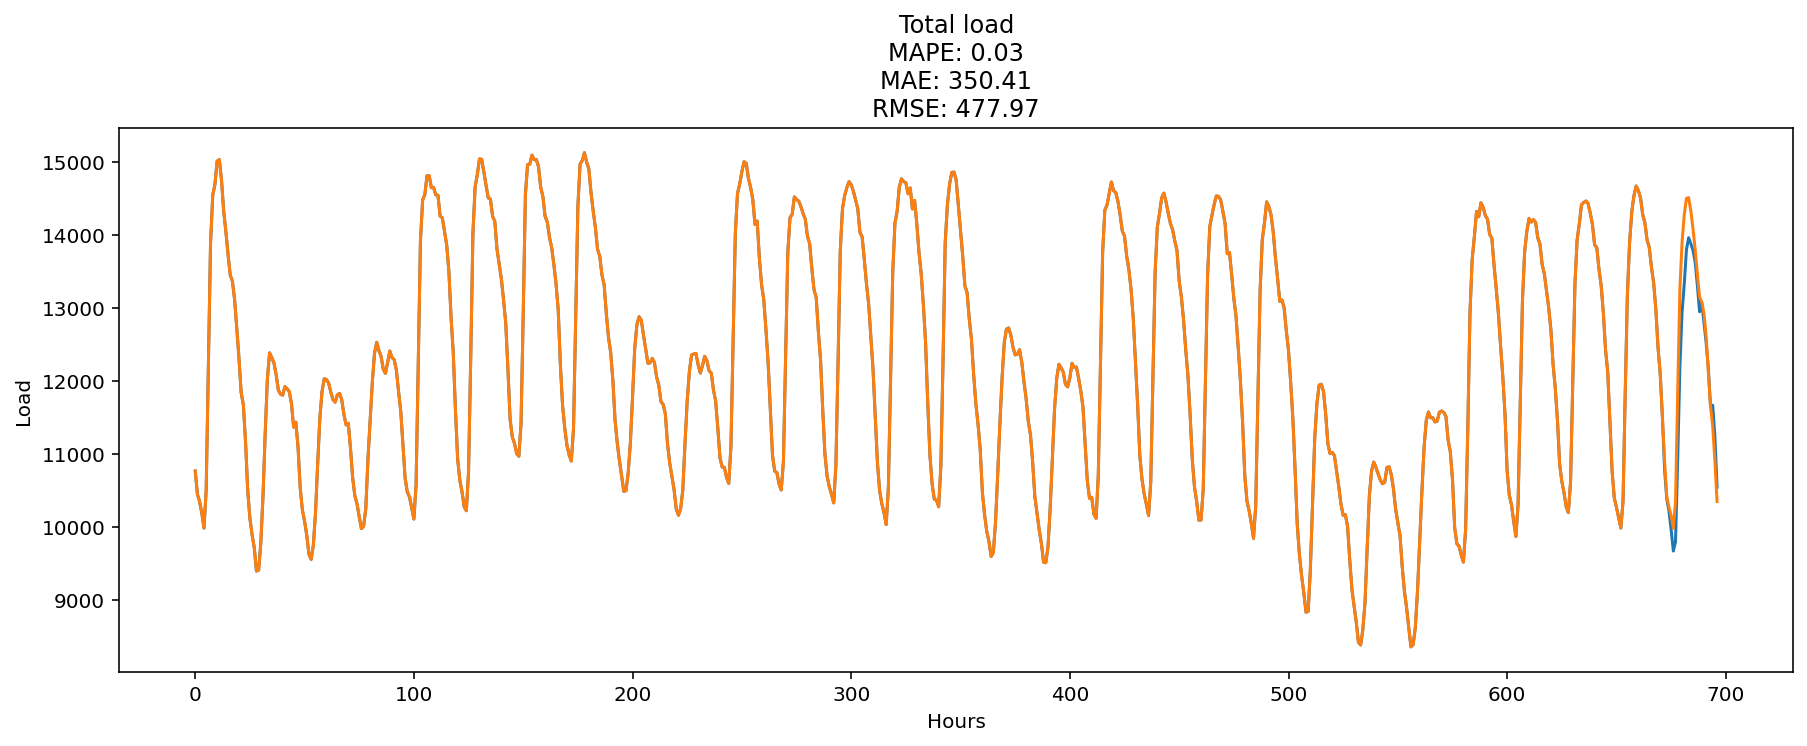

In [122]:
week = 24*7
day = 24
tscv = TimeSeriesSplit(max_train_size=4*week, n_splits=4, test_size=day+1)
ts = day_res
for train_indeces, val_indeces in tscv.split(ts[train_test_indeces]):
    fig, axs = plt.subplots(1, 3, sharex=True)
    
    predicted_day_r = predict_lstm(day_res, train_indeces, val_indeces)
    rmse = mean_squared_error(day_res[val_indeces], predicted_day_r, squared=False)
    mae = mean_absolute_error(day_res[val_indeces], predicted_day_r)
    mape = mean_absolute_percentage_error(day_res[val_indeces], predicted_day_r)
    plot_predicted(day_res, predicted_day_r, train_indeces, val_indeces, axs[0], f'Day residuals\nMAPE: {mape:.2f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}')
    
    predicted_day_t = predict_lstm(day_trend, train_indeces, val_indeces)
    mape = mean_absolute_percentage_error(day_trend[val_indeces], predicted_day_t)
    mae = mean_absolute_error(day_trend[val_indeces], predicted_day_t)
    rmse = mean_squared_error(day_trend[val_indeces], predicted_day_t, squared=False)
    plot_predicted(day_trend, predicted_day_t, train_indeces, val_indeces, axs[1], f'Day trend\nMAPE: {mape:.2f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}')
    
    predicted_year_t = predict_lstm(year_trend, train_indeces, val_indeces)
    mape = mean_absolute_percentage_error(year_trend[val_indeces], predicted_year_t)
    mae = mean_absolute_error(year_trend[val_indeces], predicted_year_t)
    rmse = mean_squared_error(year_trend[val_indeces], predicted_year_t, squared=False)
    plot_predicted(year_trend, predicted_year_t, train_indeces, val_indeces, axs[2], f'Year trend\nMAPE: {mape:.2f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}')
    
    plt.show()
   
    
    fig, ax = plt.subplots()
    
    #total
    total = year_seasonal + year_trend + day_seasonal + day_trend + day_res
    predicted_t = year_seasonal[val_indeces] + predicted_year_t + day_seasonal[val_indeces] + predicted_day_t + predicted_day_r
    mape = mean_absolute_percentage_error(total[val_indeces], predicted_t)
    mae = mean_absolute_error(total[val_indeces], predicted_t)
    rmse = mean_squared_error(total[val_indeces], predicted_t, squared=False)
    plot_predicted(total, predicted_t, train_indeces, val_indeces, ax, f'Total load\nMAPE: {mape:.2f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}')
    
    plt.show()

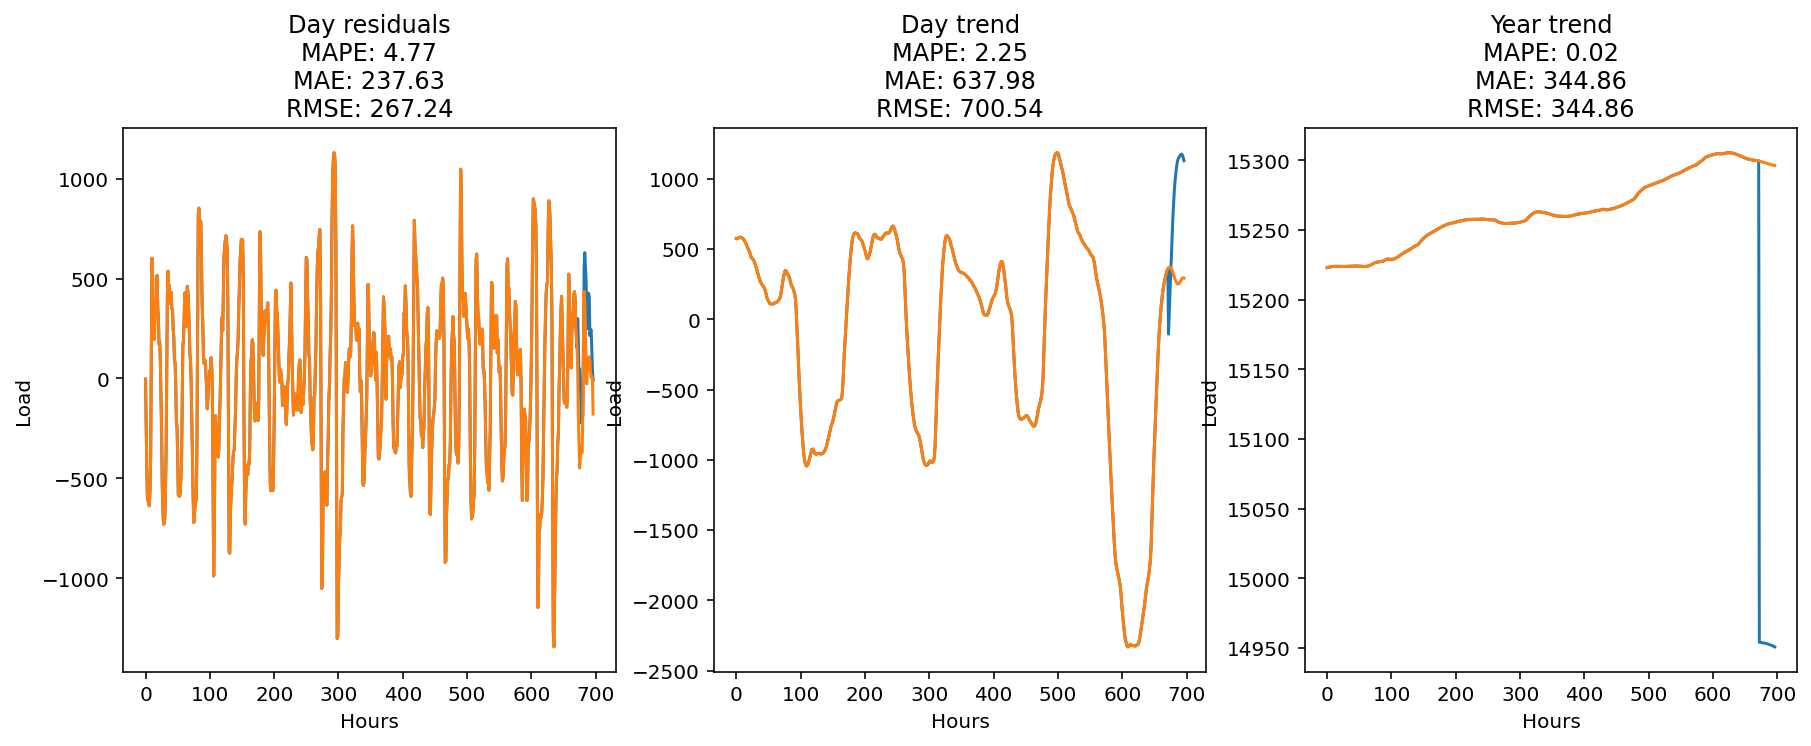

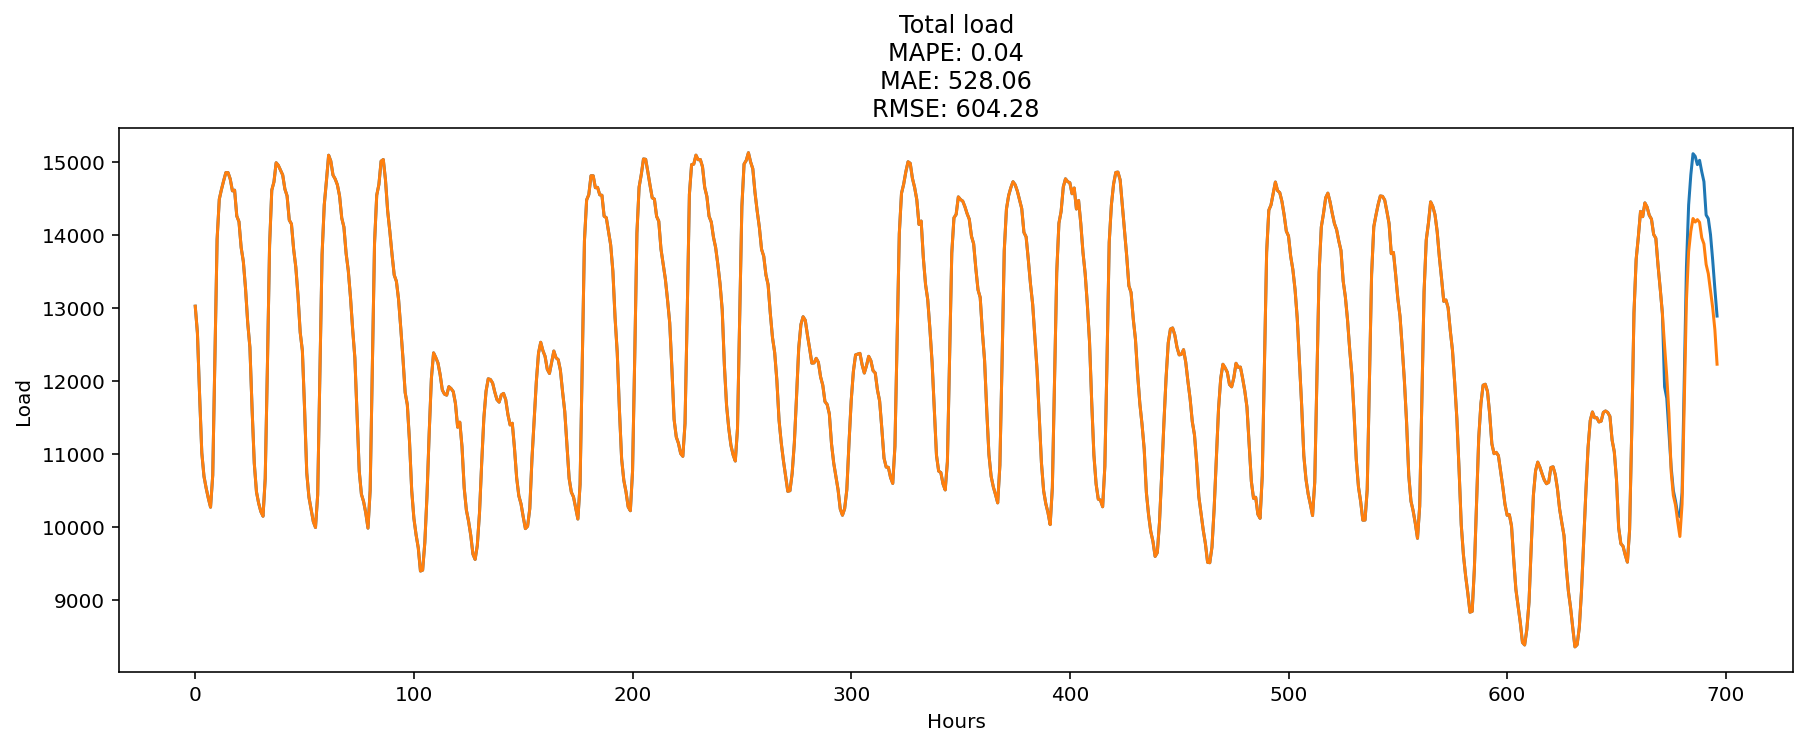

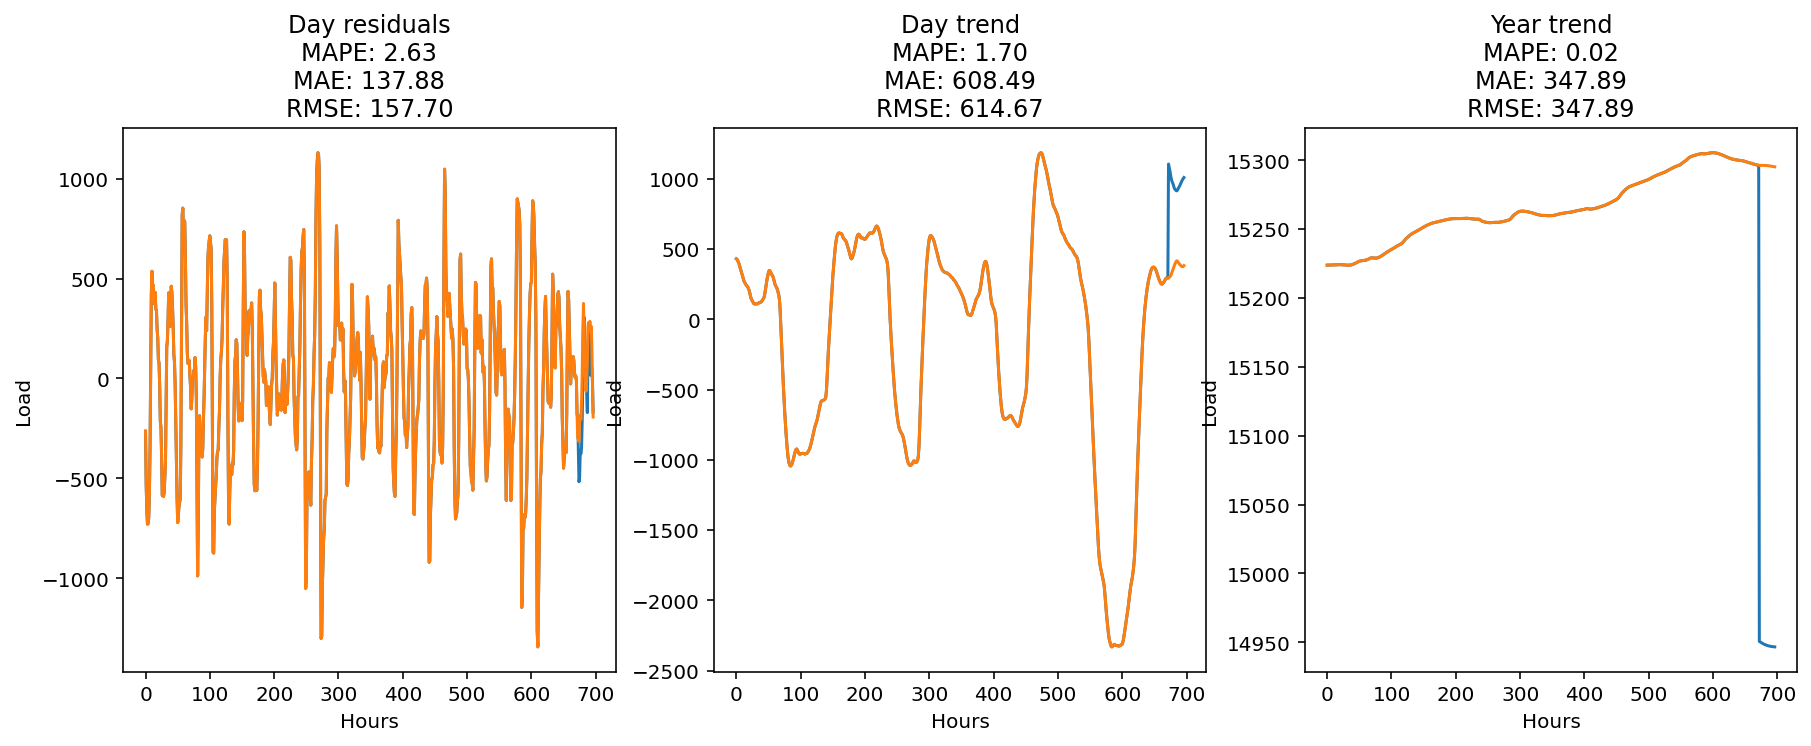

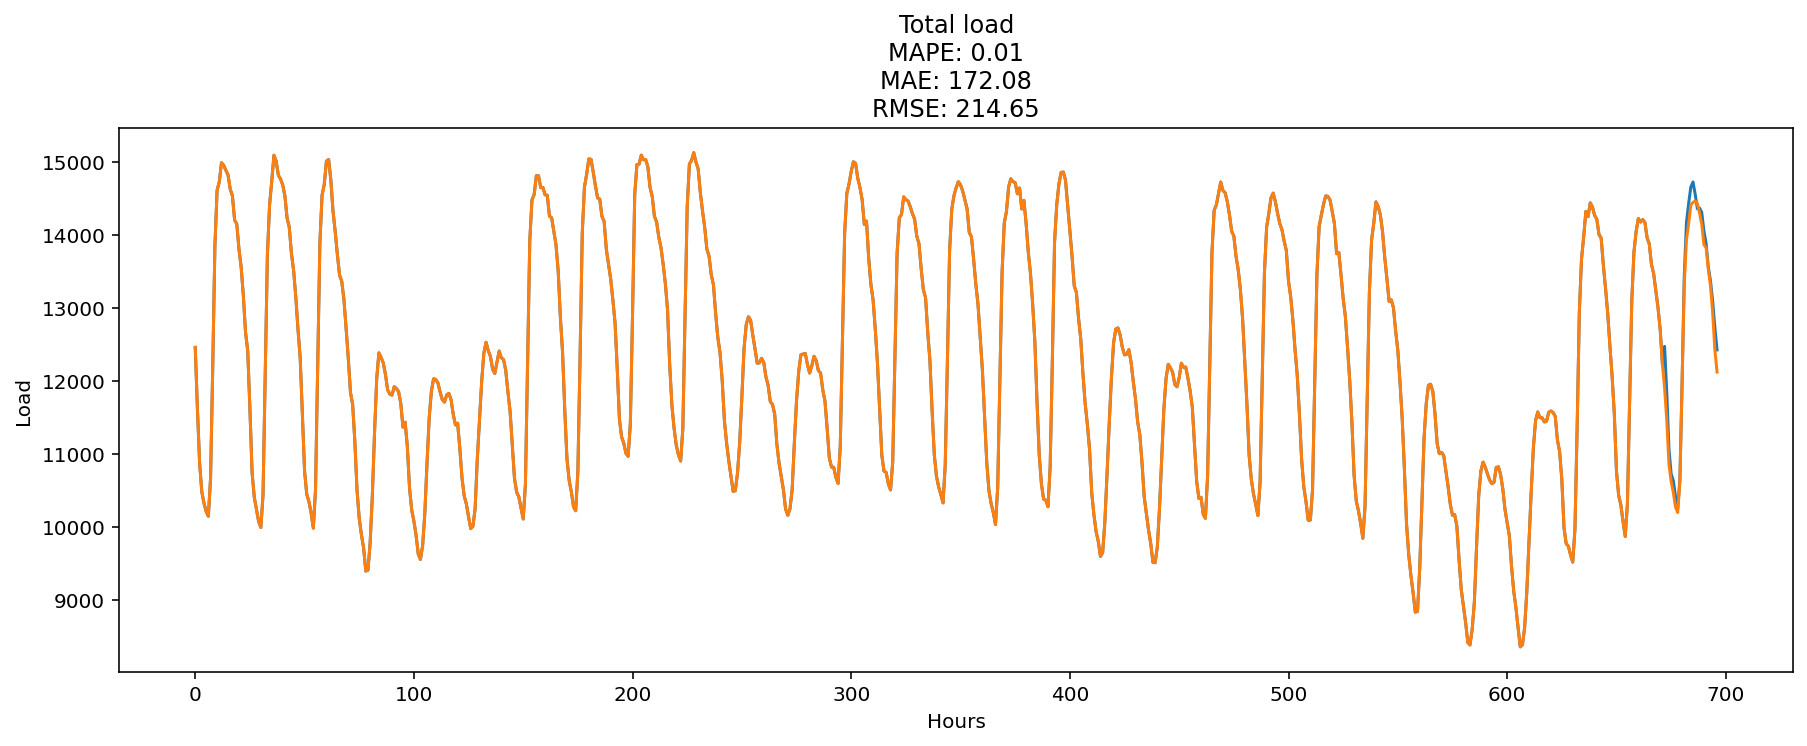

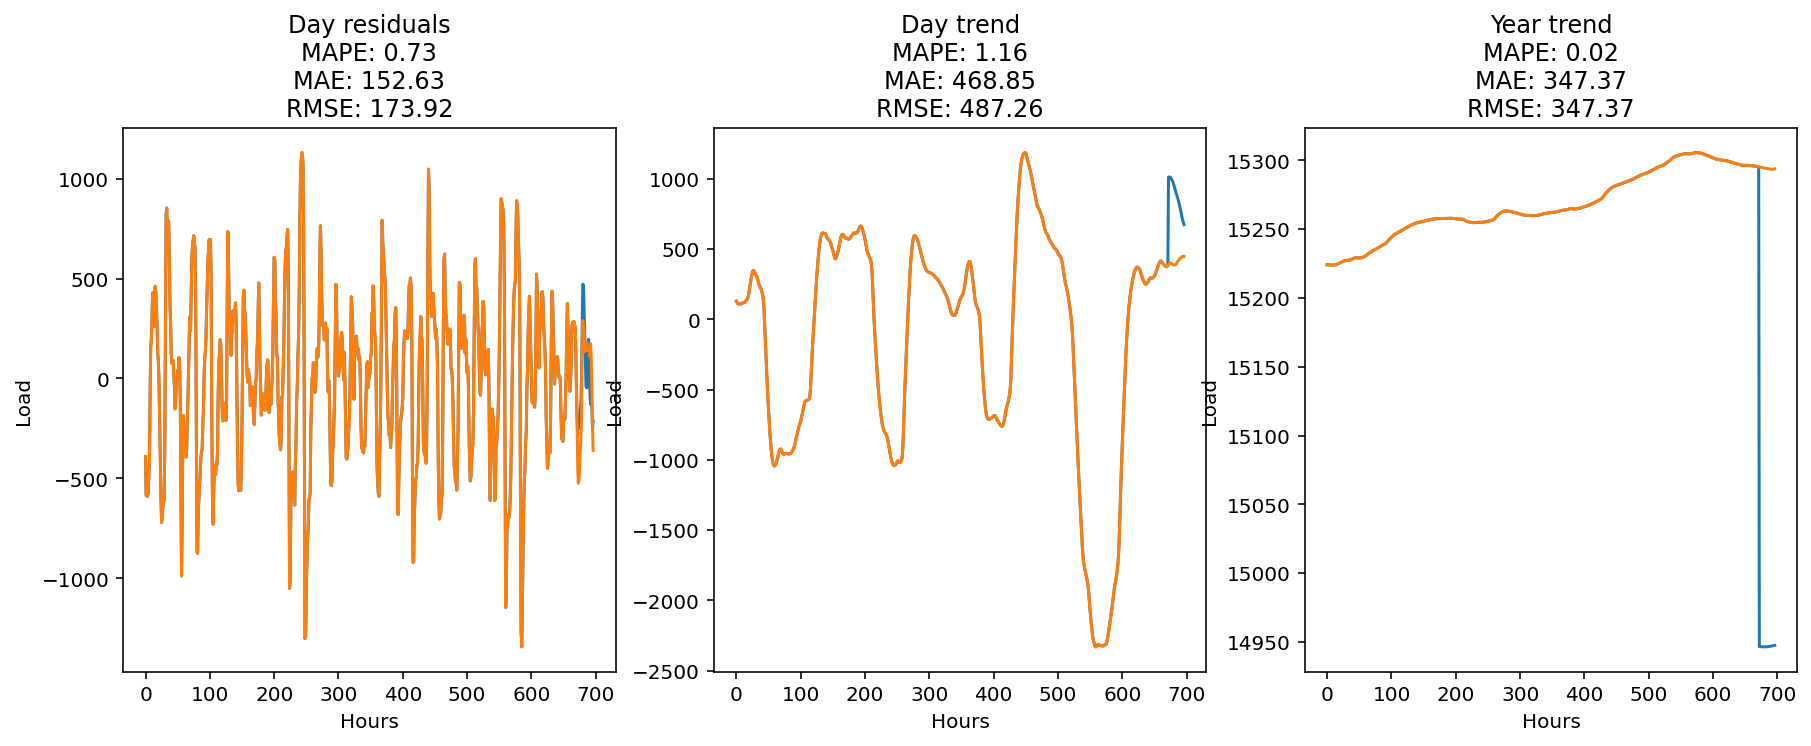

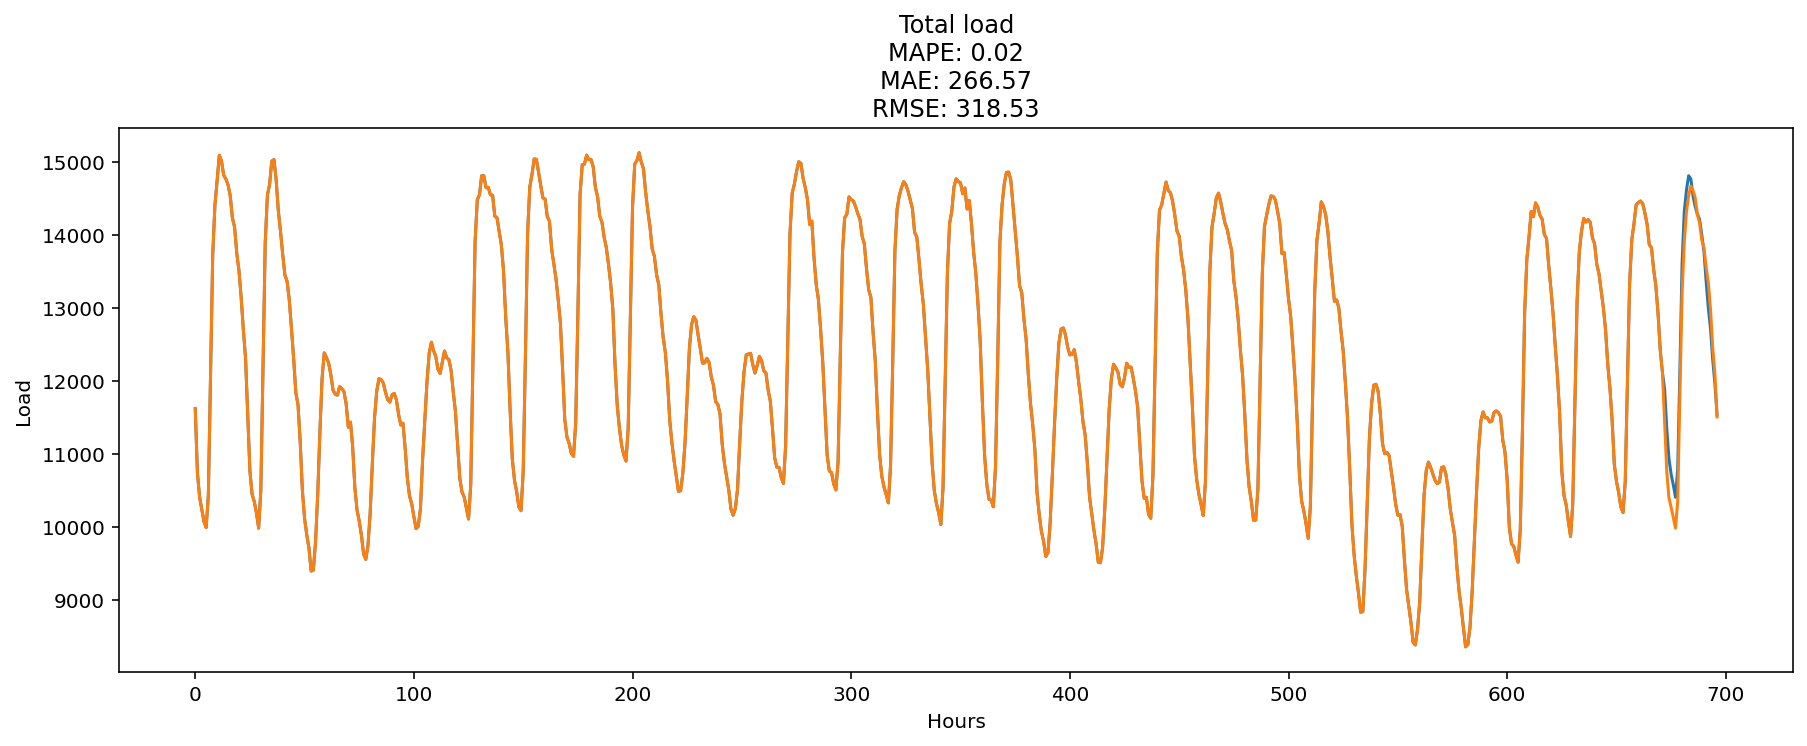

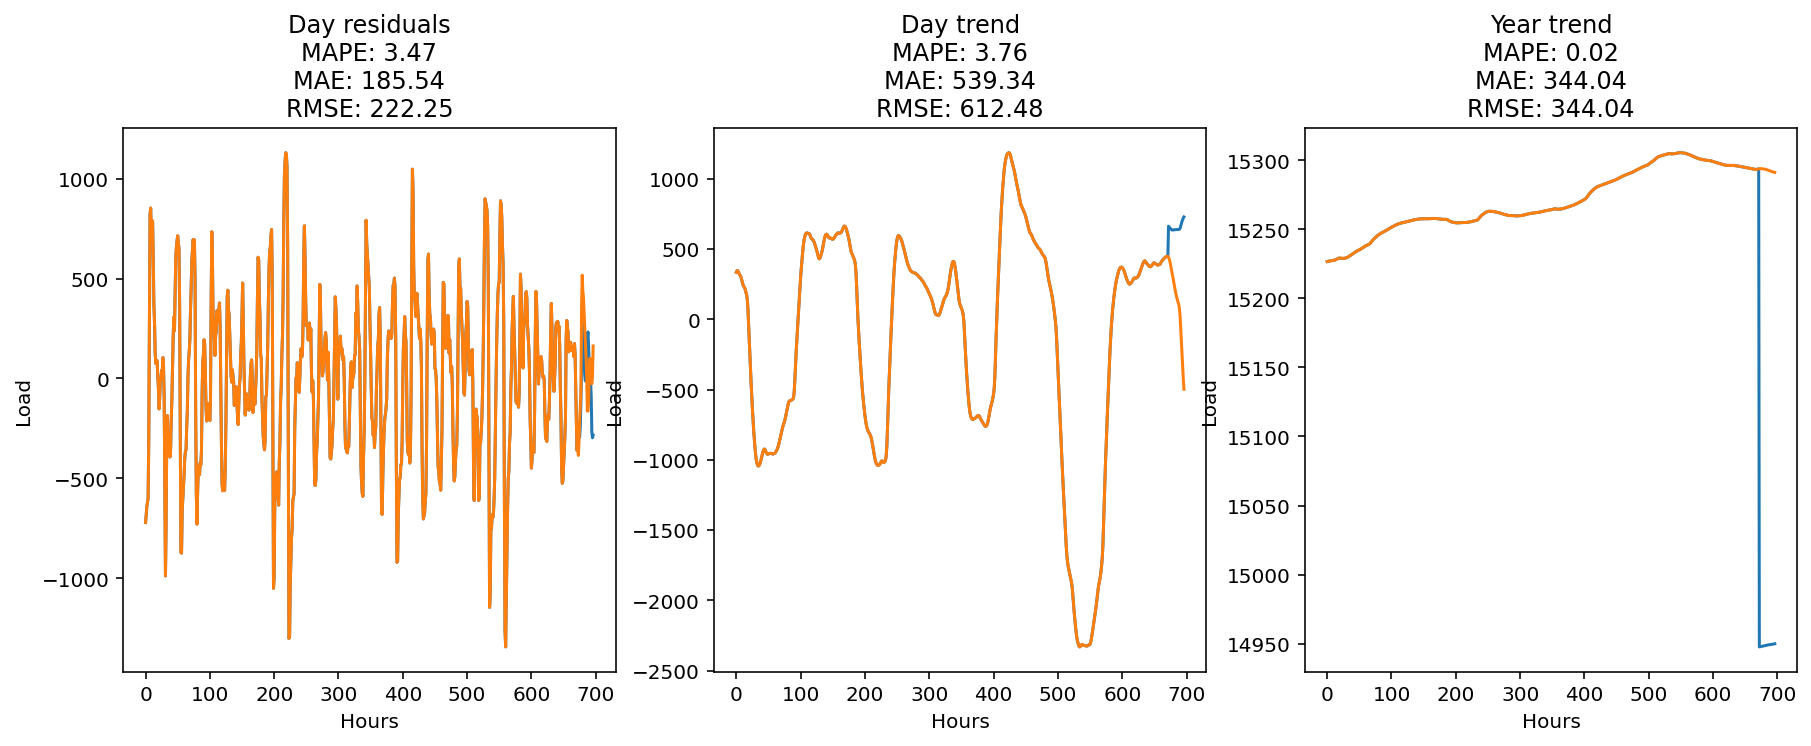

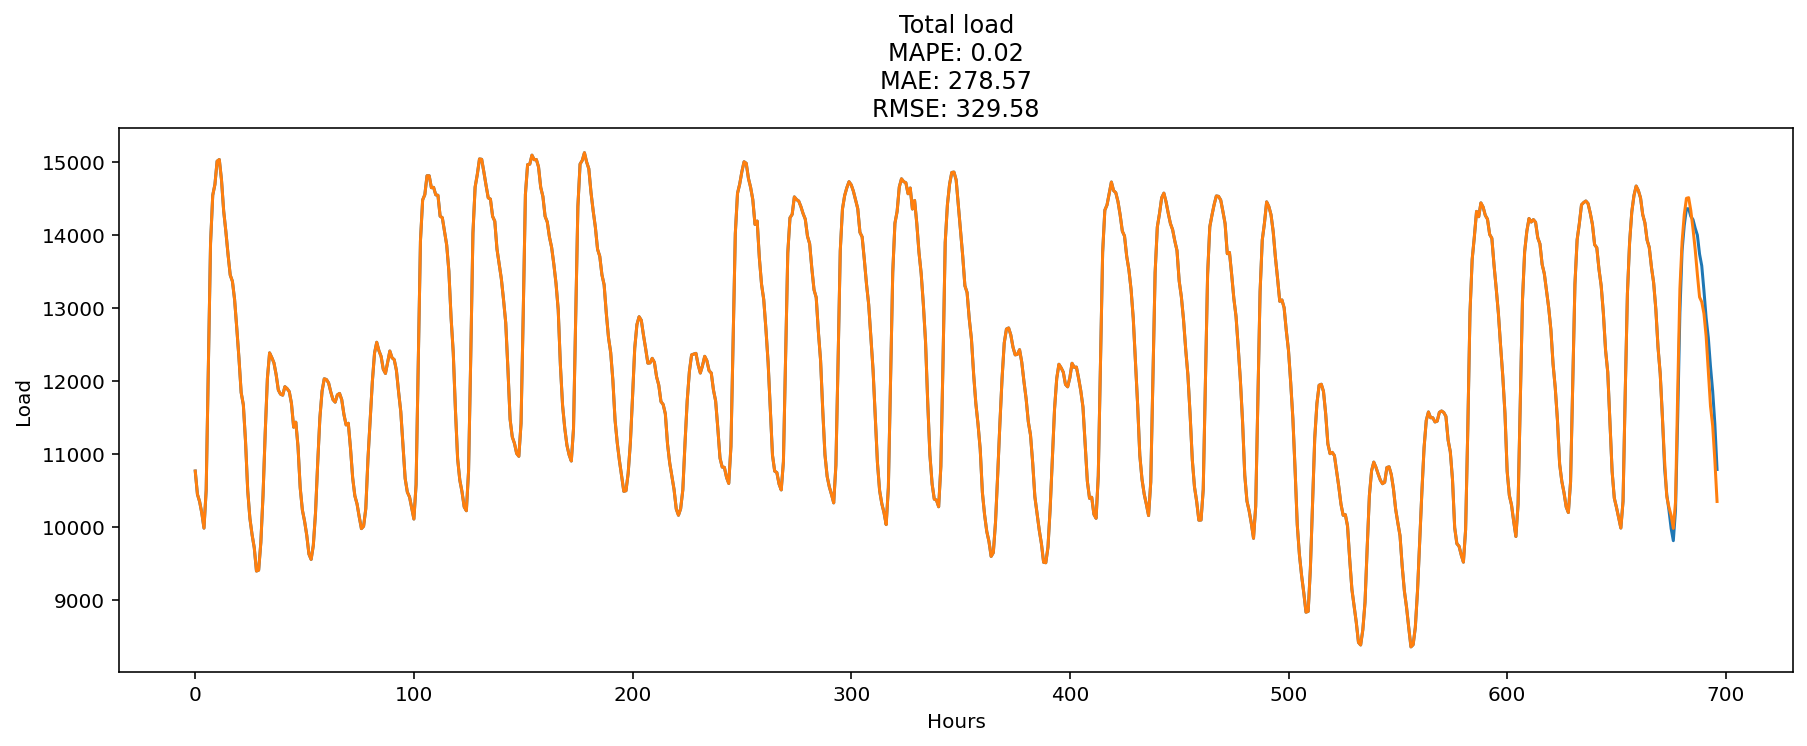

In [131]:
week = 24*7
day = 24
tscv = TimeSeriesSplit(max_train_size=4*week, n_splits=4, test_size=day+1)
ts = day_res
for train_indeces, val_indeces in tscv.split(ts[train_test_indeces]):
    fig, axs = plt.subplots(1, 3, sharex=True)
    
    predicted_day_r = day_res[val_indeces-365*24].values
    rmse = mean_squared_error(day_res[val_indeces], predicted_day_r, squared=False)
    mae = mean_absolute_error(day_res[val_indeces], predicted_day_r)
    mape = mean_absolute_percentage_error(day_res[val_indeces], predicted_day_r)
    plot_predicted(day_res, predicted_day_r, train_indeces, val_indeces, axs[0], f'Day residuals\nMAPE: {mape:.2f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}')
    
    predicted_day_t = day_trend[val_indeces-365*24].values
    mape = mean_absolute_percentage_error(day_trend[val_indeces], predicted_day_t)
    mae = mean_absolute_error(day_trend[val_indeces], predicted_day_t)
    rmse = mean_squared_error(day_trend[val_indeces], predicted_day_t, squared=False)
    plot_predicted(day_trend, predicted_day_t, train_indeces, val_indeces, axs[1], f'Day trend\nMAPE: {mape:.2f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}')
    
    predicted_year_t = year_trend[val_indeces-365*24].values
    mape = mean_absolute_percentage_error(year_trend[val_indeces], predicted_year_t)
    mae = mean_absolute_error(year_trend[val_indeces], predicted_year_t)
    rmse = mean_squared_error(year_trend[val_indeces], predicted_year_t, squared=False)
    plot_predicted(year_trend, predicted_year_t, train_indeces, val_indeces, axs[2], f'Year trend\nMAPE: {mape:.2f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}')
    
    plt.show()
   
    
    fig, ax = plt.subplots()
    
    #total
    total = year_seasonal + year_trend + day_seasonal + day_trend + day_res
    predicted_t = year_seasonal[val_indeces] + predicted_year_t + day_seasonal[val_indeces] + predicted_day_t + predicted_day_r
    mape = mean_absolute_percentage_error(total[val_indeces], predicted_t)
    mae = mean_absolute_error(total[val_indeces], predicted_t)
    rmse = mean_squared_error(total[val_indeces], predicted_t, squared=False)
    plot_predicted(total, predicted_t, train_indeces, val_indeces, ax, f'Total load\nMAPE: {mape:.2f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}')
    
    plt.show()

### Using same value from previous day

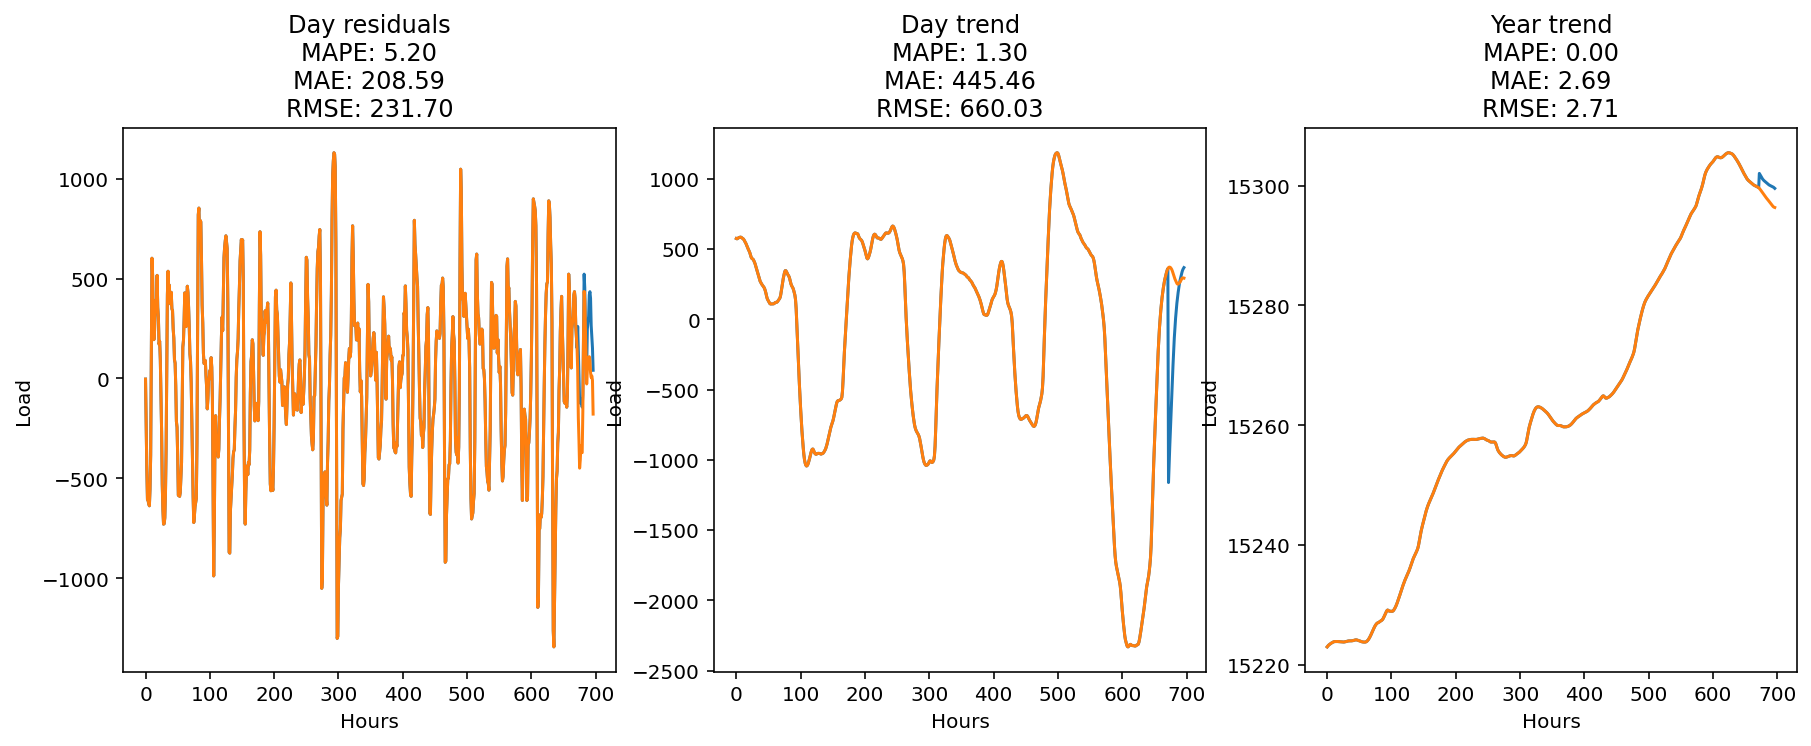

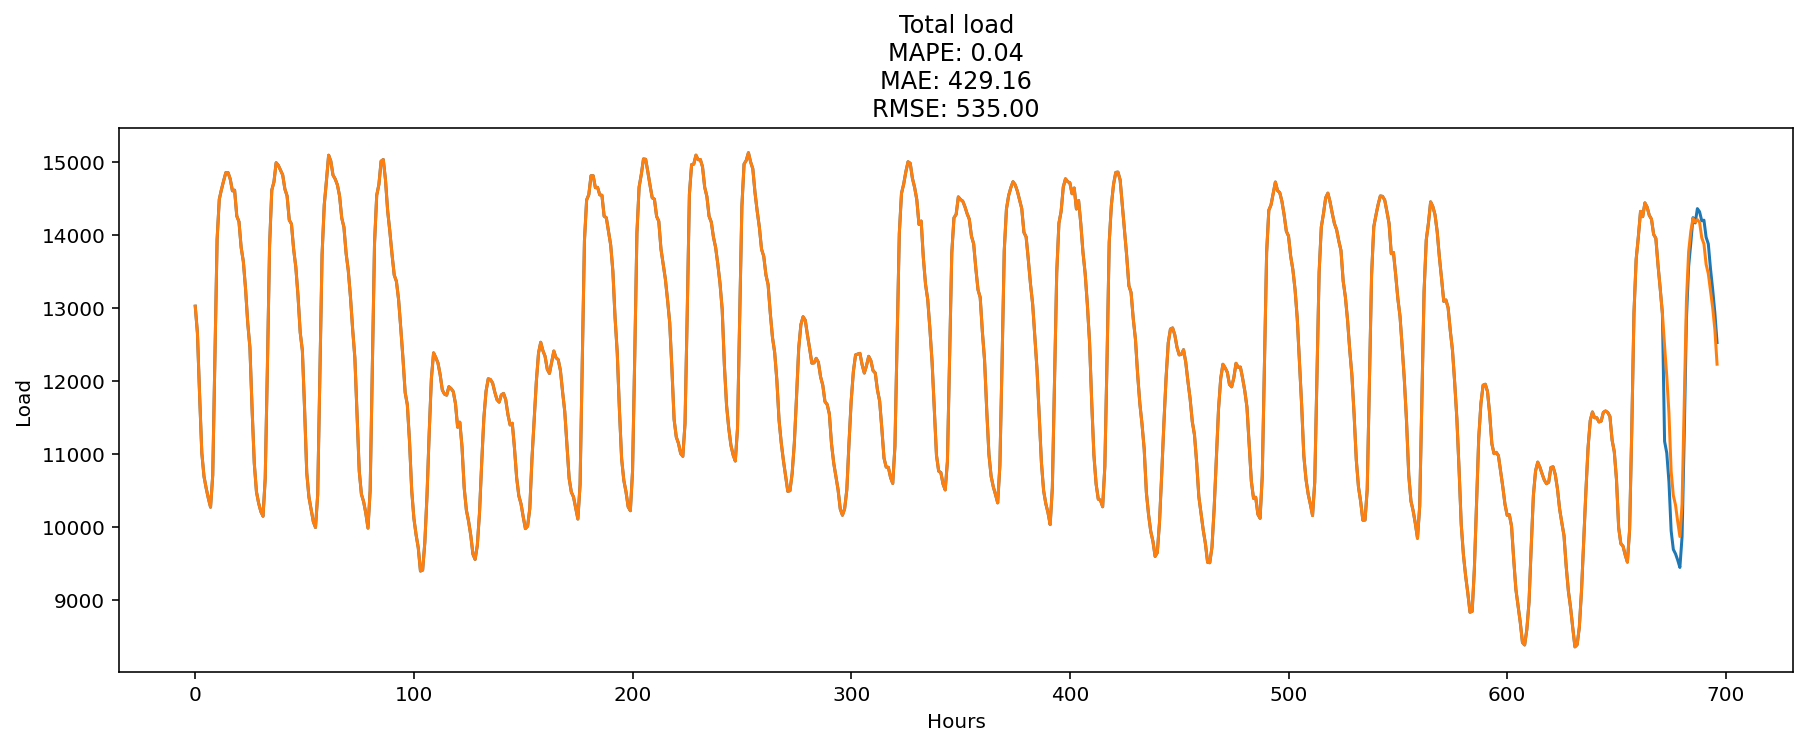

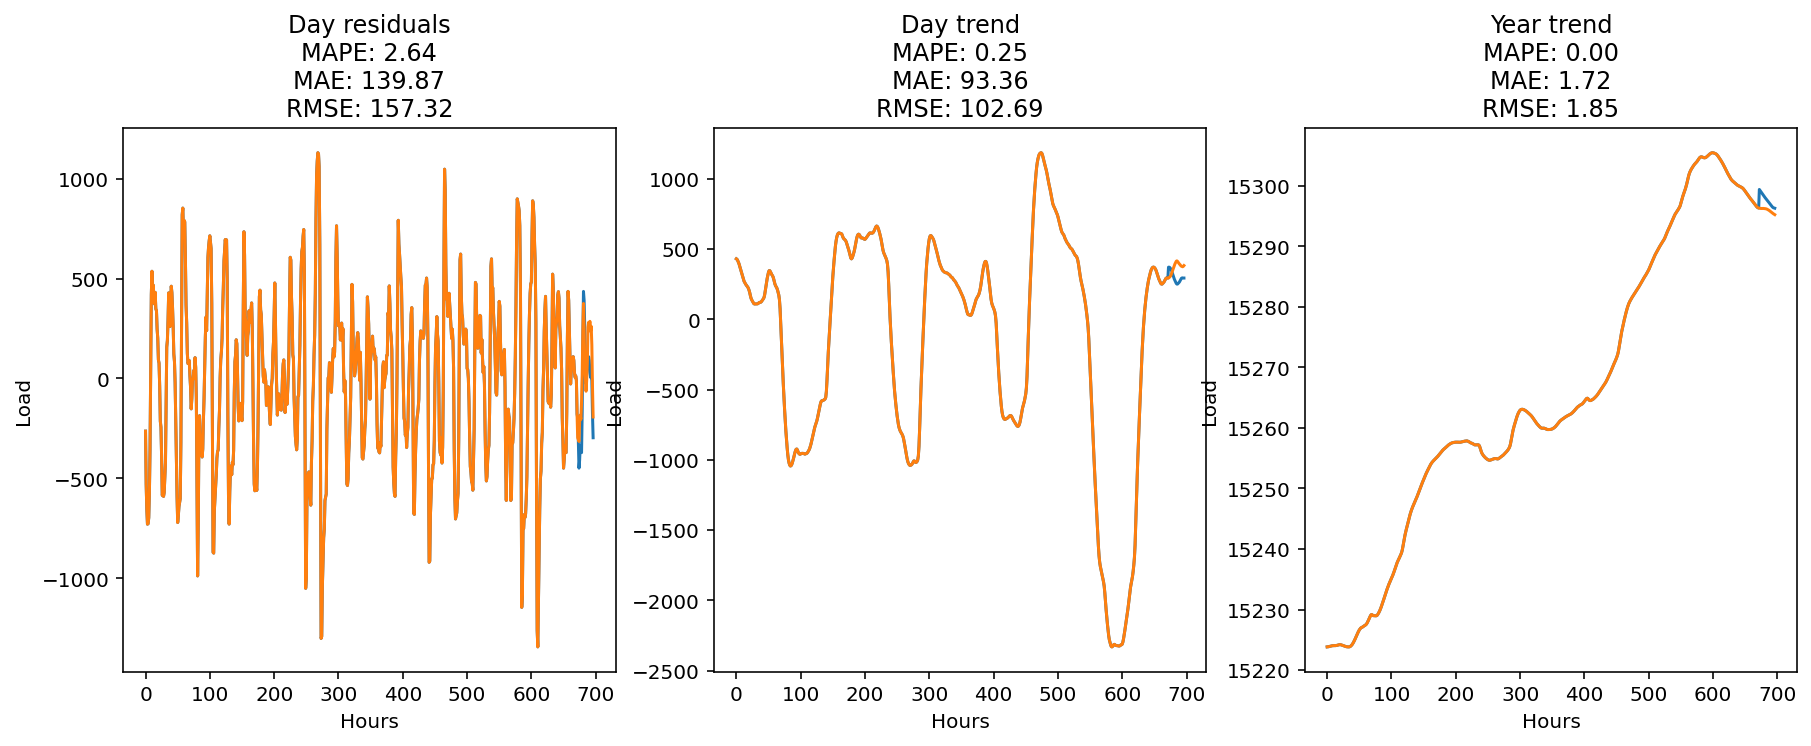

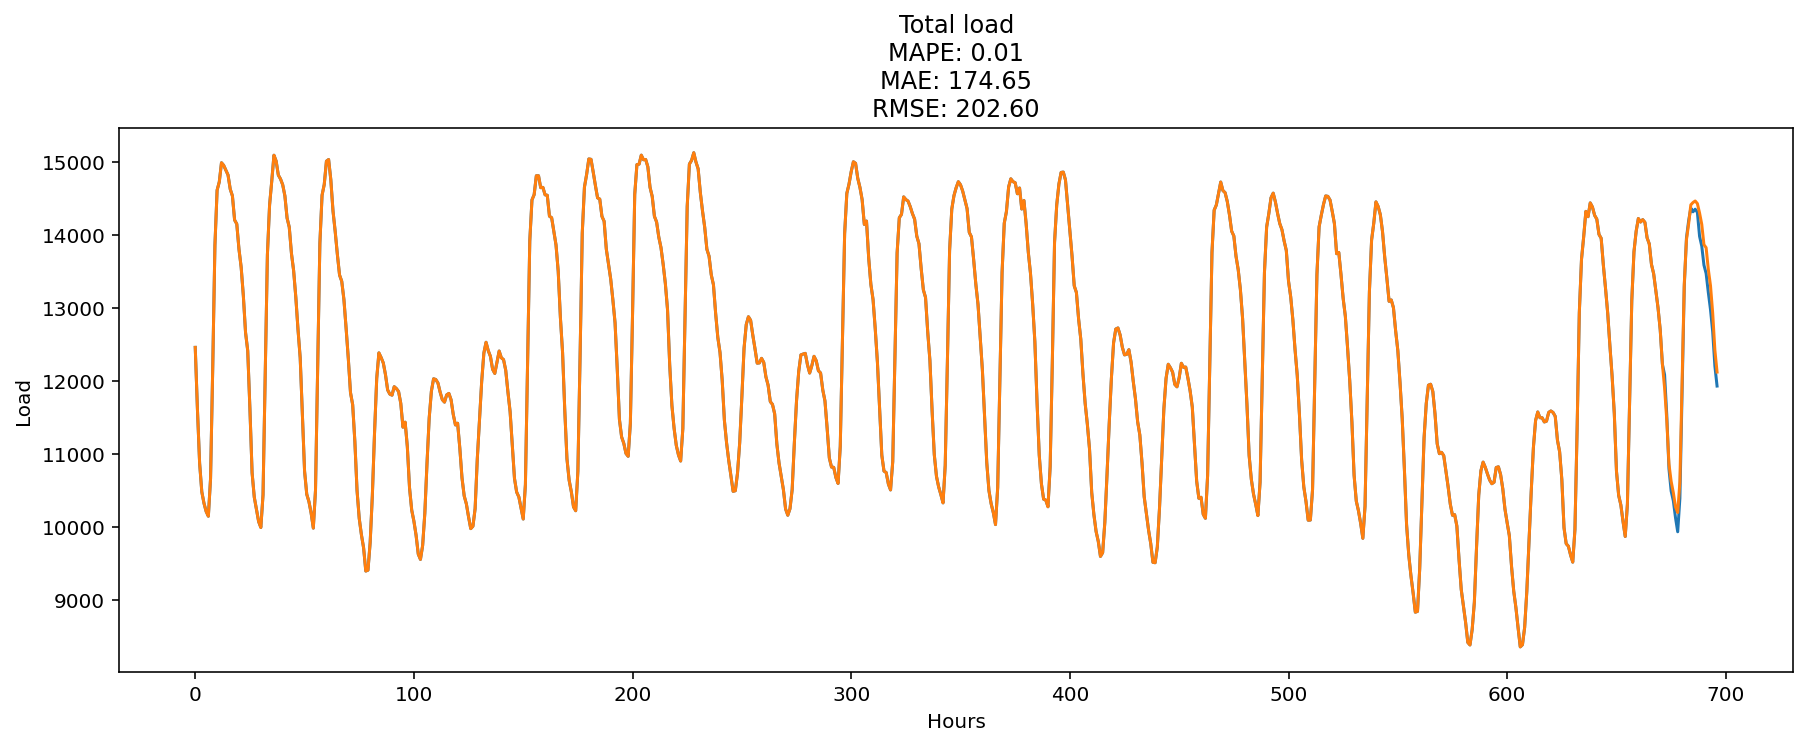

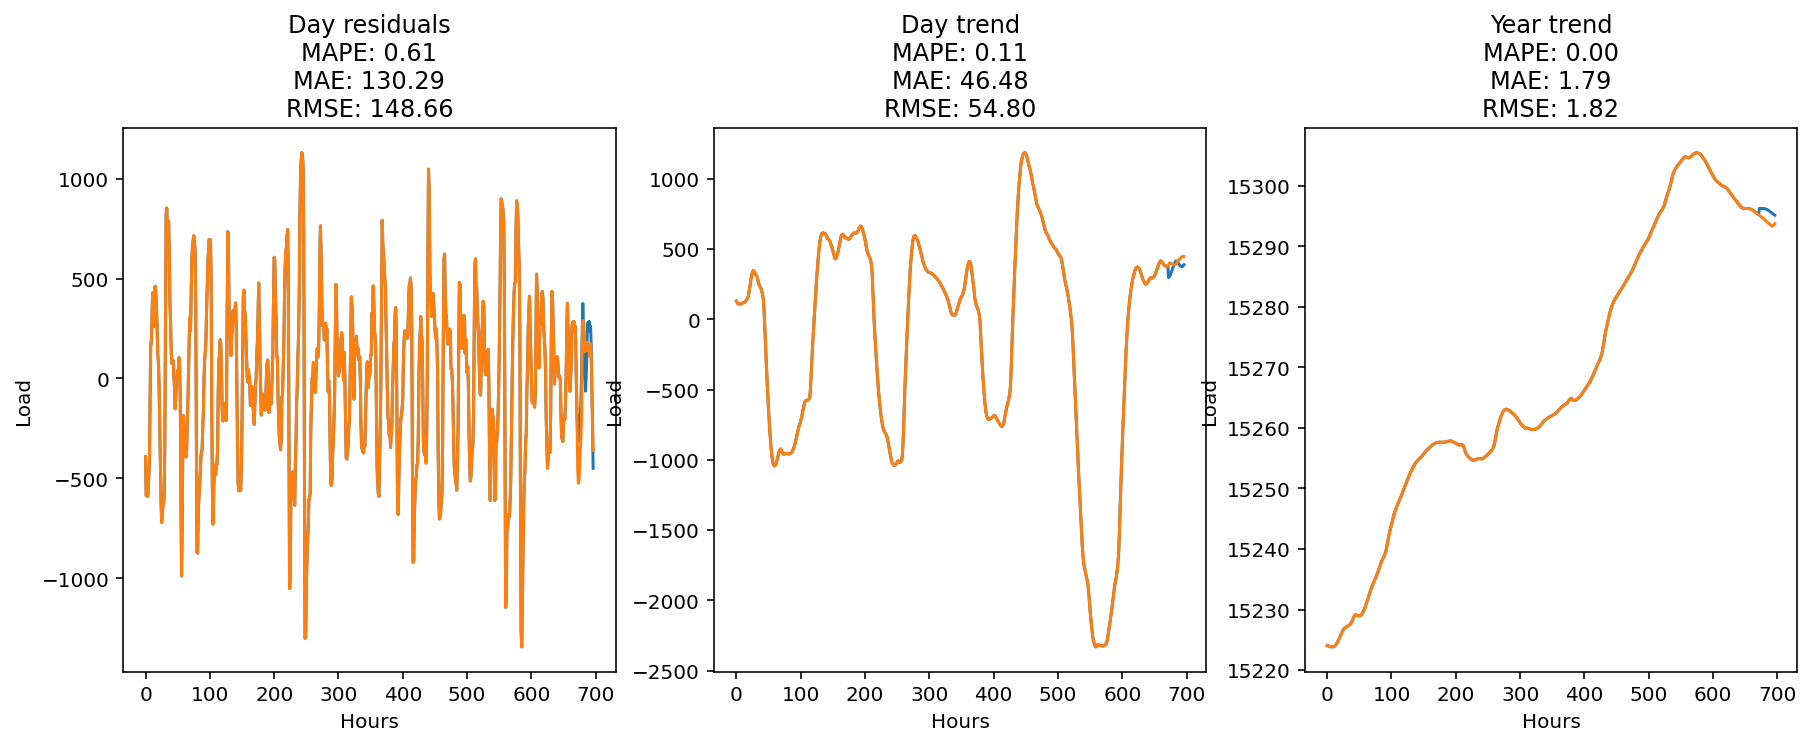

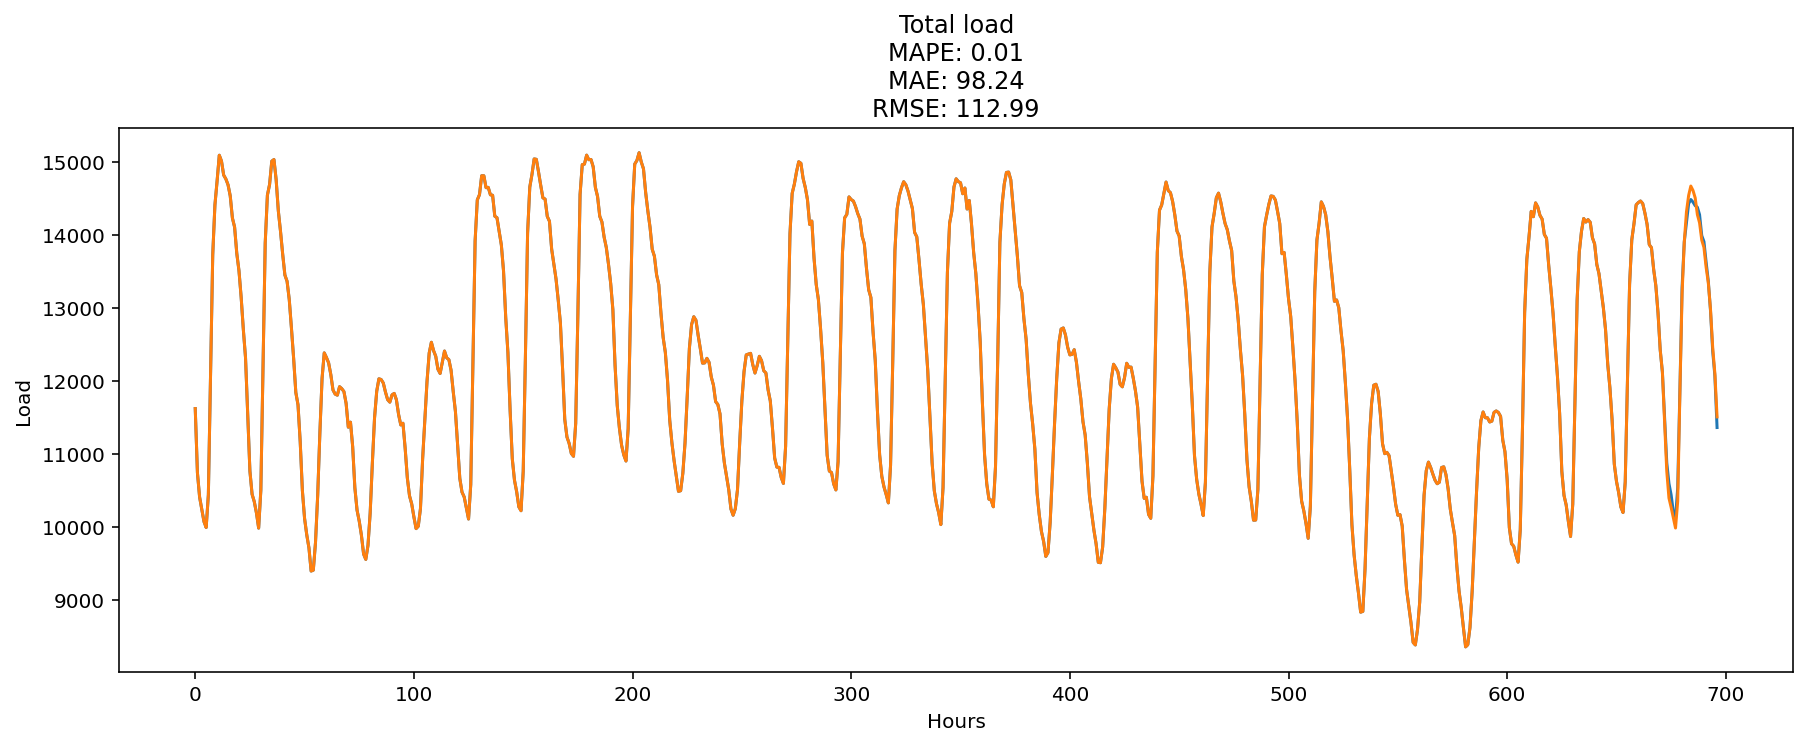

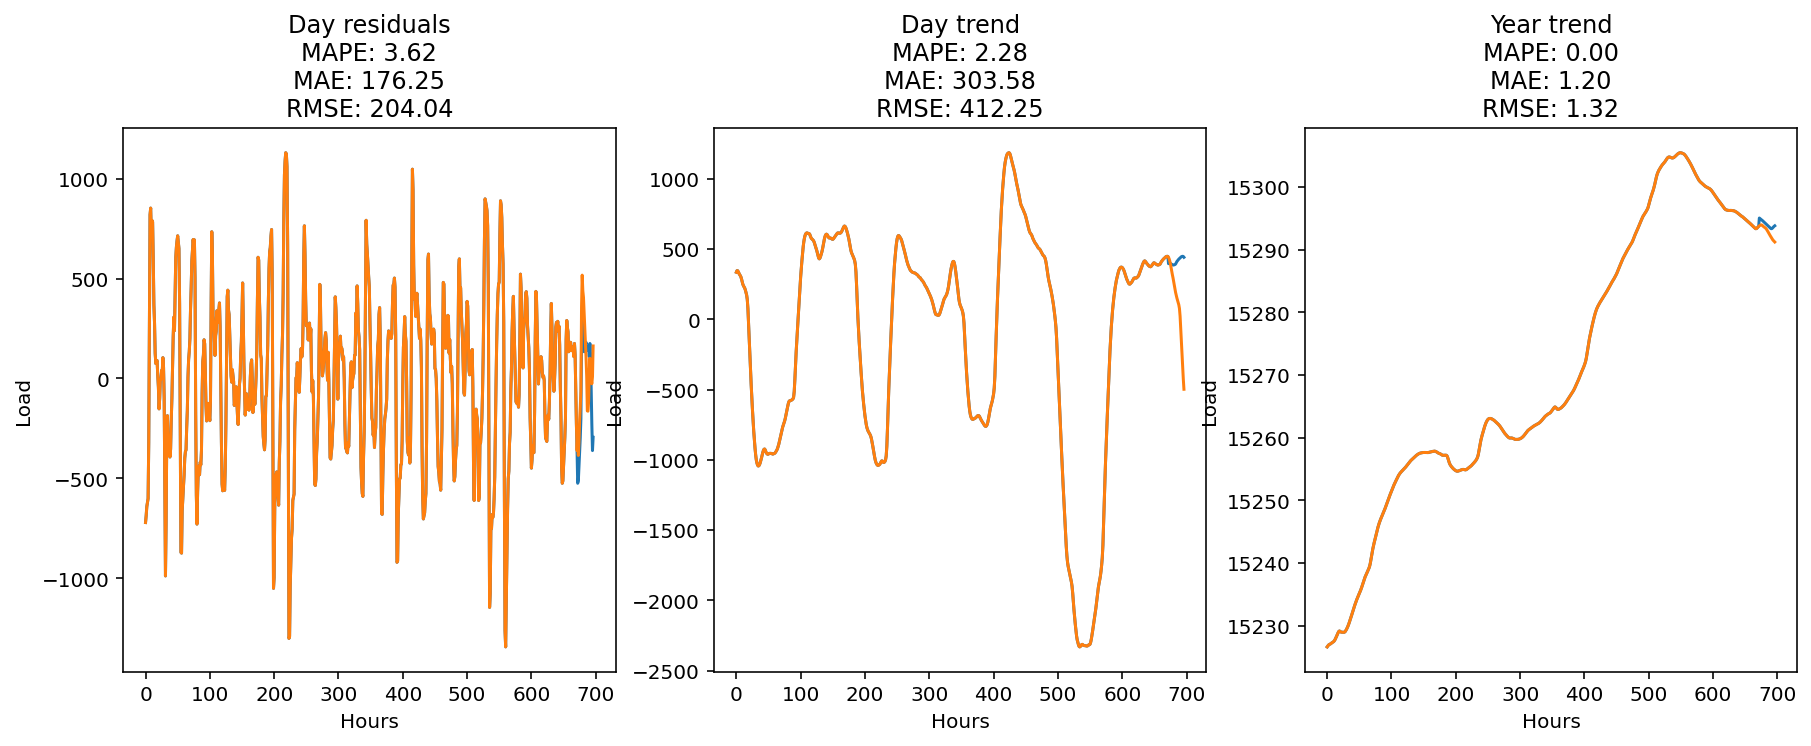

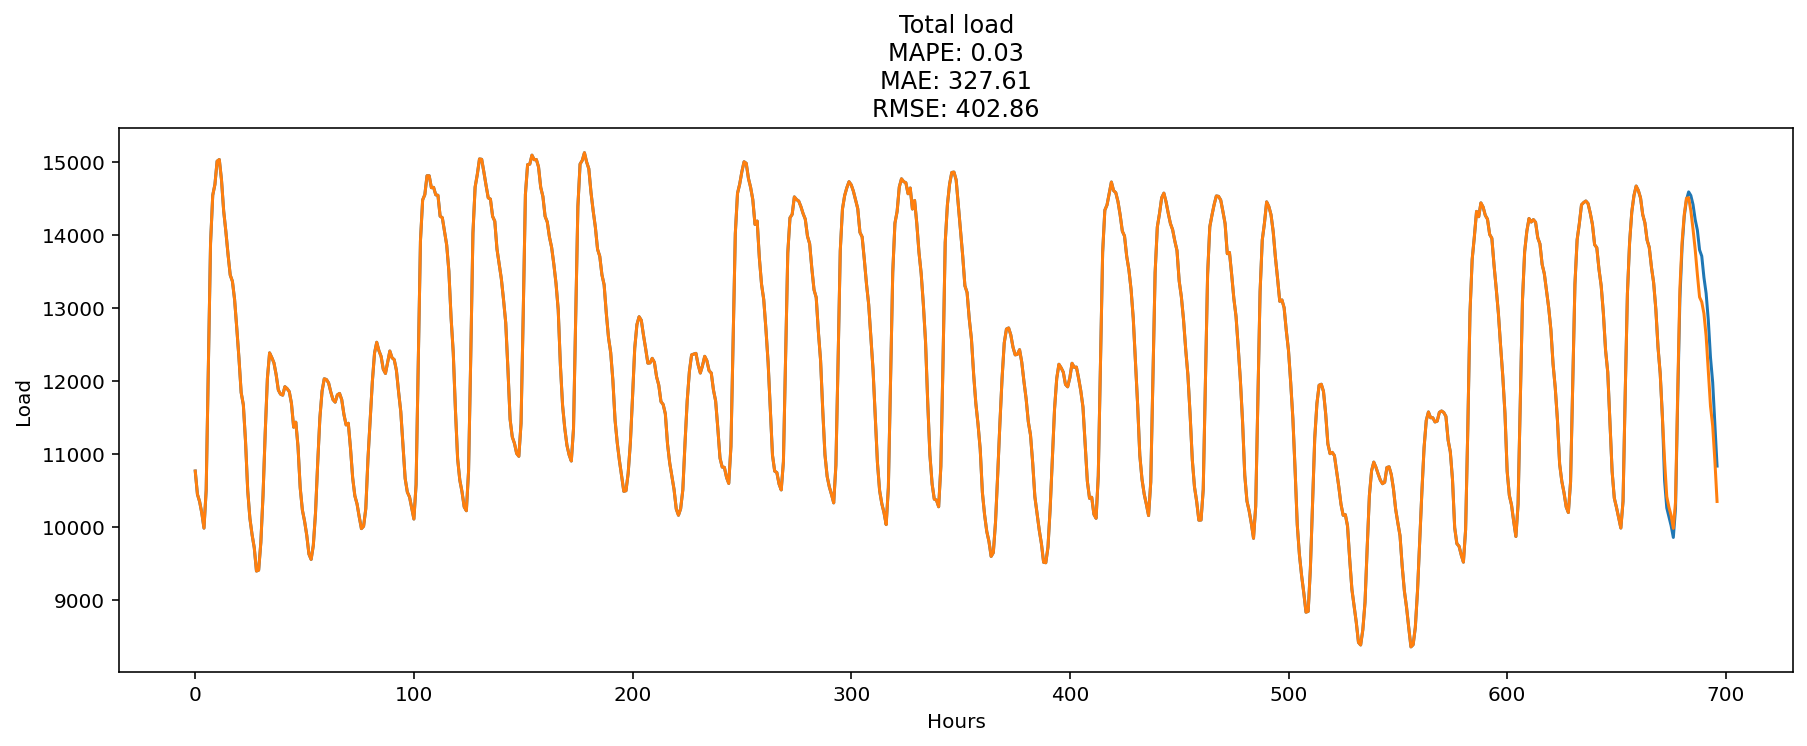

In [132]:
week = 24*7
day = 24
tscv = TimeSeriesSplit(max_train_size=4*week, n_splits=4, test_size=day+1)
ts = day_res
for train_indeces, val_indeces in tscv.split(ts[train_test_indeces]):
    fig, axs = plt.subplots(1, 3, sharex=True)
    
    predicted_day_r = day_res[val_indeces-24].values
    rmse = mean_squared_error(day_res[val_indeces], predicted_day_r, squared=False)
    mae = mean_absolute_error(day_res[val_indeces], predicted_day_r)
    mape = mean_absolute_percentage_error(day_res[val_indeces], predicted_day_r)
    plot_predicted(day_res, predicted_day_r, train_indeces, val_indeces, axs[0], f'Day residuals\nMAPE: {mape:.2f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}')
    
    predicted_day_t = day_trend[val_indeces-24].values
    mape = mean_absolute_percentage_error(day_trend[val_indeces], predicted_day_t)
    mae = mean_absolute_error(day_trend[val_indeces], predicted_day_t)
    rmse = mean_squared_error(day_trend[val_indeces], predicted_day_t, squared=False)
    plot_predicted(day_trend, predicted_day_t, train_indeces, val_indeces, axs[1], f'Day trend\nMAPE: {mape:.2f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}')
    
    predicted_year_t = year_trend[val_indeces-24].values
    mape = mean_absolute_percentage_error(year_trend[val_indeces], predicted_year_t)
    mae = mean_absolute_error(year_trend[val_indeces], predicted_year_t)
    rmse = mean_squared_error(year_trend[val_indeces], predicted_year_t, squared=False)
    plot_predicted(year_trend, predicted_year_t, train_indeces, val_indeces, axs[2], f'Year trend\nMAPE: {mape:.2f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}')
    
    plt.show()
   
    
    fig, ax = plt.subplots()
    
    #total
    total = year_seasonal + year_trend + day_seasonal + day_trend + day_res
    predicted_t = year_seasonal[val_indeces] + predicted_year_t + day_seasonal[val_indeces] + predicted_day_t + predicted_day_r
    mape = mean_absolute_percentage_error(total[val_indeces], predicted_t)
    mae = mean_absolute_error(total[val_indeces], predicted_t)
    rmse = mean_squared_error(total[val_indeces], predicted_t, squared=False)
    plot_predicted(total, predicted_t, train_indeces, val_indeces, ax, f'Total load\nMAPE: {mape:.2f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}')
    
    plt.show()

## Finding reference signal

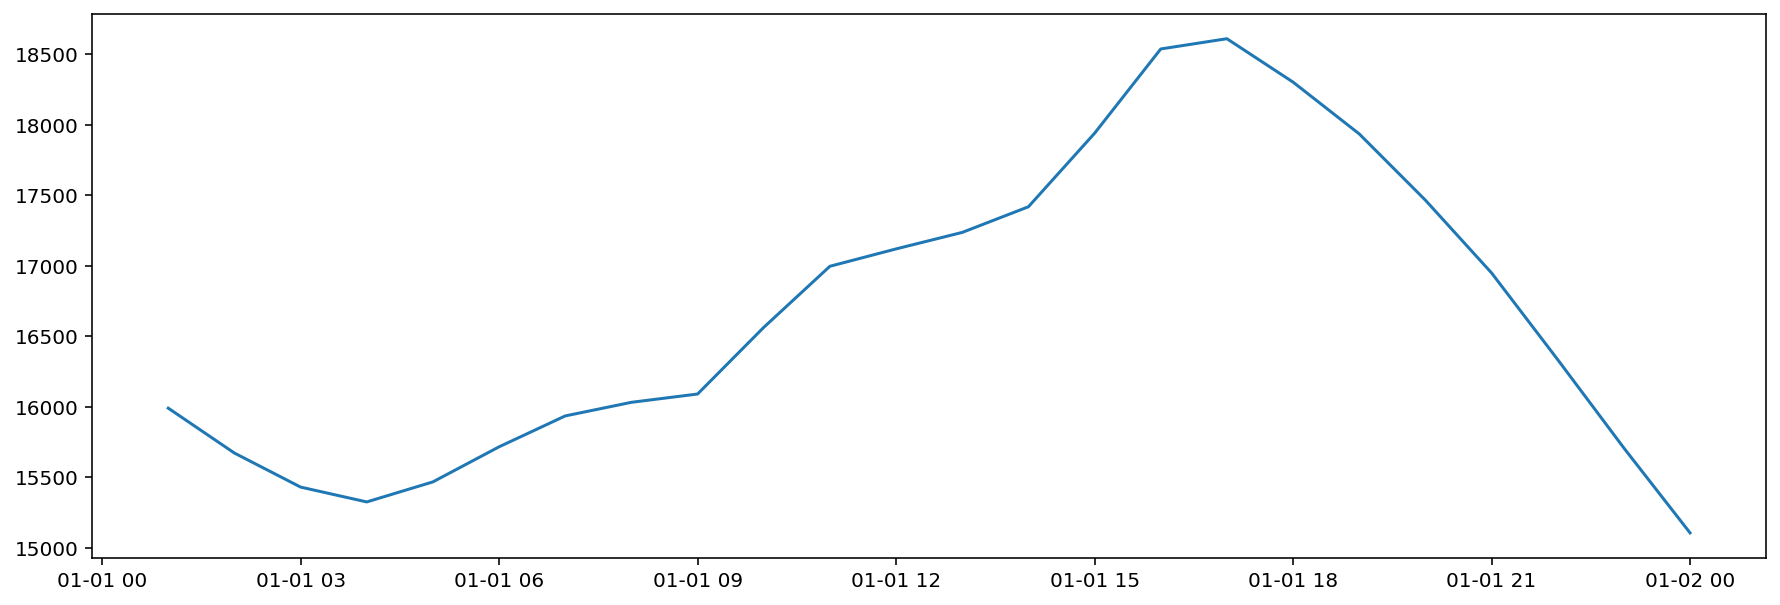

In [4]:
plt.plot(df[:24])

In [5]:
import operator

def _local_extremum(arr, min_: bool):
    mask = np.empty_like(arr, dtype=bool)
    mask[0] = True
    mask[1:] = arr[:-1] != arr[1:]
    arr_filtered = arr[mask]
    idx_to_orig = mask.nonzero()[0]
    
    if not min_:
        idx_maximum = np.logical_and(arr_filtered[:-2] < arr_filtered[1:-1], arr_filtered[1:-1] >= arr_filtered[2:])
    else:
        idx_maximum = np.logical_and(arr_filtered[:-2] > arr_filtered[1:-1], arr_filtered[1:-1] <= arr_filtered[2:])
        
    idx_maximum = idx_to_orig[1:-1][idx_maximum]

    return idx_maximum

def local_maximum(arr):
    return _local_extremum(arr, min_=False)
    
def local_minimum(arr):
    return _local_extremum(arr, min_=True)


In [6]:
def _per_day_extremum(arr, min_: bool):
    if min_:
        maxs = local_minimum(arr)
    else:
        maxs = local_maximum(arr)
    max_st = 0
    per_day_maxs = []
    for i in range(24, len(df), 24):
        curr_max_st = max_st
        day_maxs = []
        while maxs[curr_max_st] < i:
            day_maxs.append(maxs[curr_max_st])
            curr_max_st += 1

        max_st = curr_max_st

        if len(day_maxs) == 1:
            per_day_maxs.append(day_maxs[0])
            continue
        elif len(day_maxs) == 0:
            continue

        if min_:
            per_day_maxs.append(day_maxs[np.argmin(df.iloc[day_maxs])])
        else:
            per_day_maxs.append(day_maxs[np.argmax(df.iloc[day_maxs])])

    return np.array(per_day_maxs)
    
def per_day_minimum(arr):
    return _per_day_extremum(arr, min_=True)

def per_day_maximum(arr):
    return _per_day_extremum(arr, min_=False)

In [ ]:
maxs = per_day_maximum(df.values)
mins = per_day_minimum(df.values)

In [8]:
start_of_day = []
offset_from_max = []

mins_st = 0
maxs_st = 0
while maxs_st < len(maxs) and mins_st < len(mins):
    if mins[mins_st] < maxs[maxs_st]:
        mins_st += 1
        continue
    
    start_of_day.append(maxs[maxs_st] + (mins[mins_st] - maxs[maxs_st])//2 )
    offset_from_max.append((mins[mins_st] - maxs[maxs_st])//5*2)
    maxs_st += 1
    
    while maxs_st + 1 < len(maxs) and maxs[maxs_st+1] < mins[mins_st]:
        maxs_st += 1
        
start_of_day = np.array(start_of_day)
offset_from_max = np.array(offset_from_max)

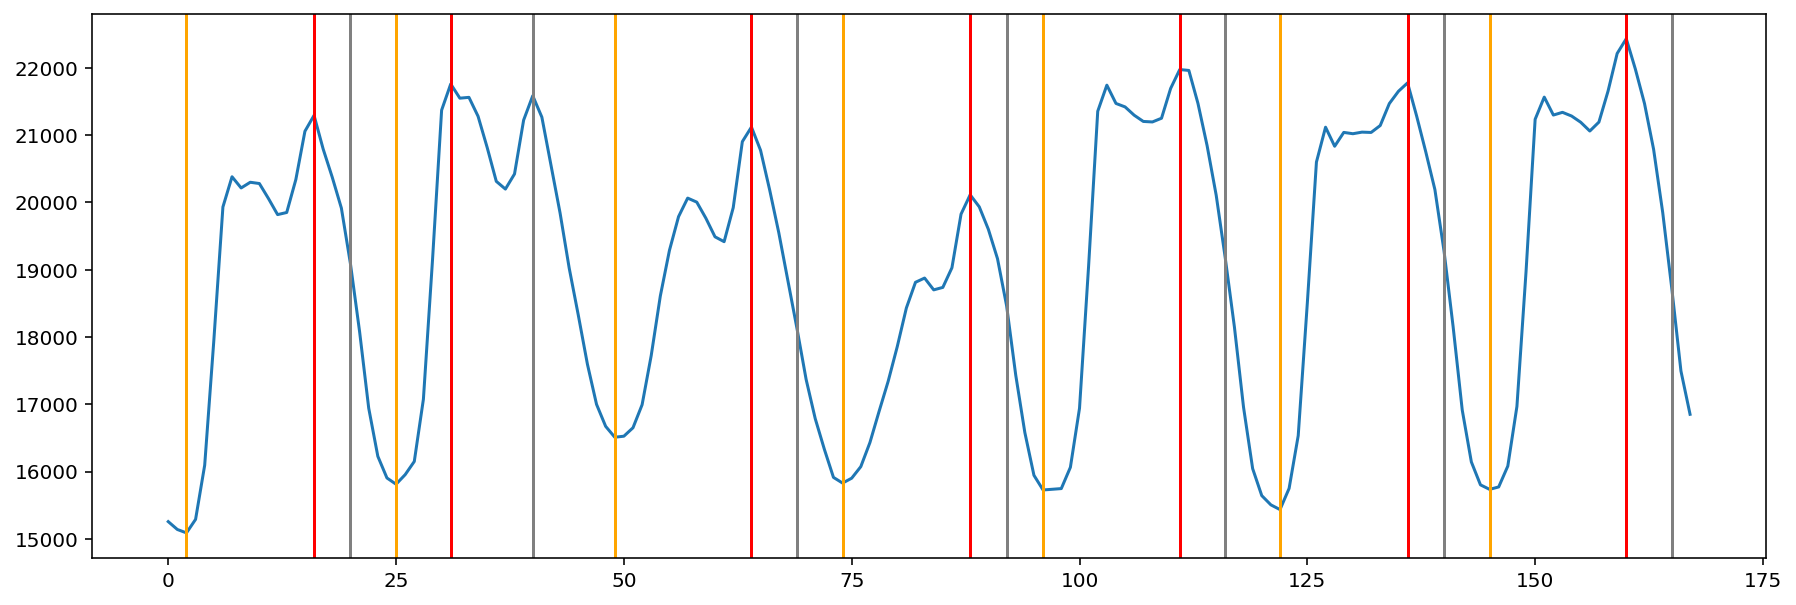

In [9]:
min_step = 12
max_step = 19
plt.plot(df.values[min_step*24:max_step*24])
for x in maxs[(min_step*24 < maxs) & (maxs < max_step*24)]:
    plt.axvline(x-min_step*24, color='red')
for x in mins[(min_step*24 < mins) & (mins < max_step*24)]:
    plt.axvline(x-min_step*24, color='orange')
    
for x in start_of_day[(min_step*24 < start_of_day) & (start_of_day < max_step*24)]:
    plt.axvline(x-min_step*24, color='grey')

In [16]:
maxs + np.mean(offset_from_max)

array([2.06443321e+01, 4.46443321e+01, 6.76443321e+01, ...,
       1.13875644e+05, 1.13900644e+05, 1.13924644e+05])

In [110]:
(start_of_day % 25).mean()

11.994521702486304

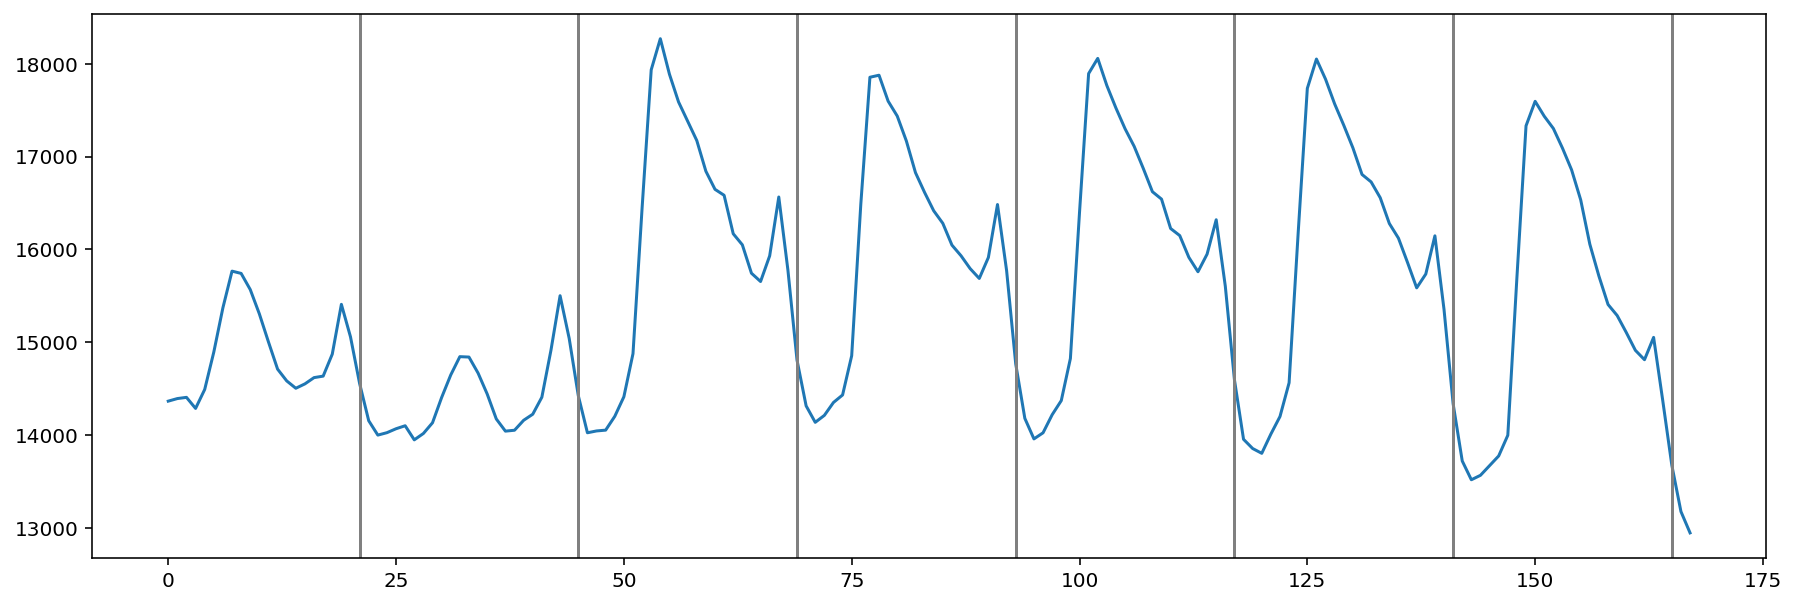

In [109]:
min_step = 112
max_step = 119
plt.plot(df.values[min_step*24:max_step*24])
    
for x in range(min_step*24 + 21, max_step*24, 24):
    plt.axvline(x-min_step*24, color='grey')

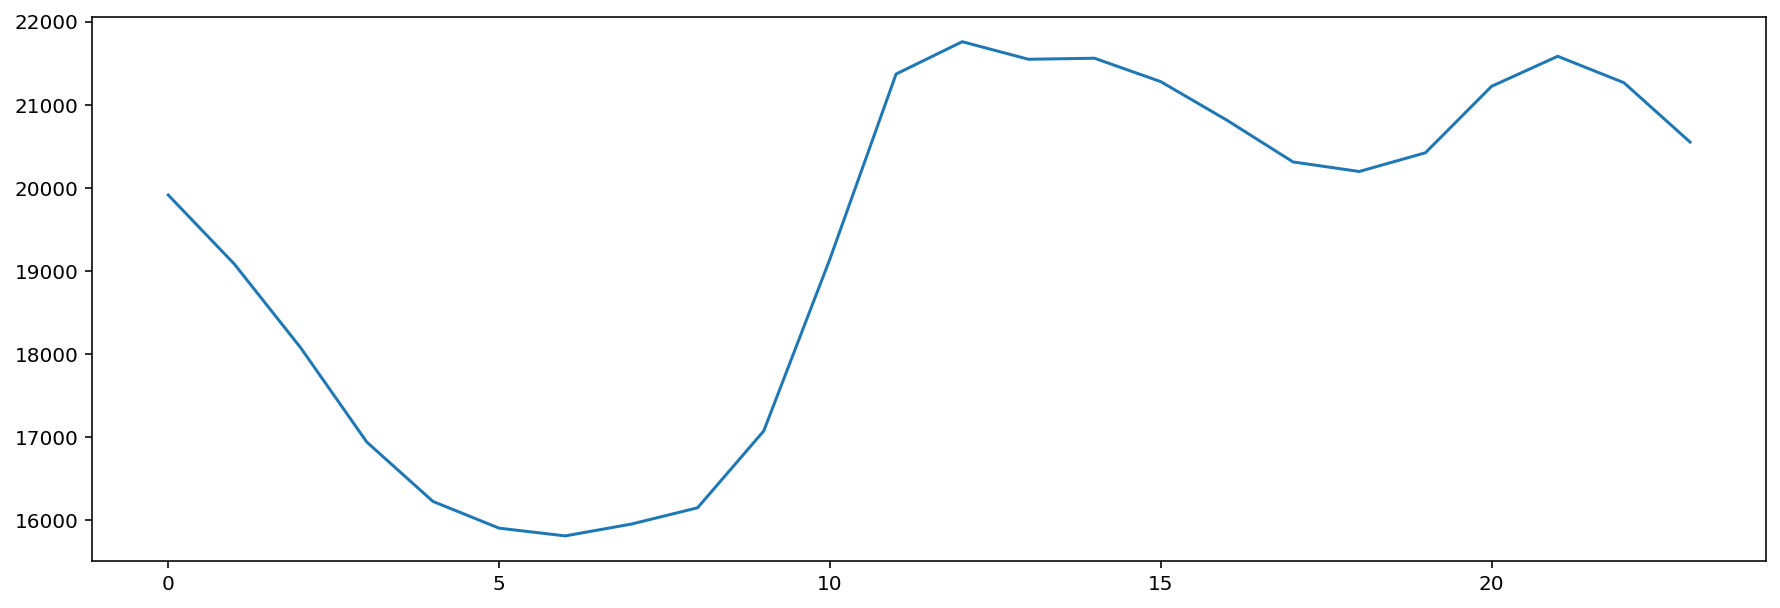

In [92]:
discharging_bound = 21000
charging_bound = 17000

st = 12*24 + 15 + int(np.mean(offset_from_max))
load = df.values[st:st+24].flatten()
discharging_load = np.minimum(load, discharging_bound)
charging_load = np.maximum(load, charging_bound)

plt.plot(load)

### Optimization problem

$$ \theta = [\theta_{min}, \theta_{max}]- ?$$ 
$$ f(x) - \text{load for given time x} $$
$$ \text{battery_used($\theta$)} = \int min(f(x), \theta_{max}) $$
$$ \text{battery_used($\theta$)} \rightarrow max $$
For next conditions:

- Amount of battery used for charge and discharge should be the same:
$$ \int min(f(x), \theta_{max})dx + \int max(f(x), \theta_{min}) dx = 2 \cdot \int f(x) dx$$
- Amount of battery used should not exceed its capacity
$$ \text{battery_used($\theta$)} < \text{battery_capacity}$$
- $\theta$  should be in bound of load
$$ [min(f(x)), min(f(x)] < \theta < [max(f(x)), max(f(x)] $$

In [90]:
from functools import partial

from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint

# bounds
bounds = ((load.min(), load.max()), (load.min(), load.max()))

# constraints
def power_amount(load):
    return np.trapz(load)


def battery_used(x, load):
    min_val, max_val = x

    total_power = power_amount(load)

    discharging_load = np.minimum(load, max_val)
    charging_load = np.maximum(load, min_val)

    return (power_amount(charging_load) - total_power, total_power - power_amount(discharging_load))

def charge_discharge_power(x, load):
    min_val, max_val = x

    total_power = power_amount(load)

    discharging_load = np.minimum(load, max_val)
    charging_load = np.maximum(load, min_val)

    return power_amount(charging_load) + power_amount(discharging_load)

battery_capacity = 7_000

total_battery_usage = NonlinearConstraint(fun=partial(
    battery_used, load=load), lb=(0, 0), ub=(battery_capacity, battery_capacity))

charge_discharge_equivalency = NonlinearConstraint(fun=partial(
    charge_discharge_power, load=load), lb=power_amount(load), ub=2*power_amount(load)
)

constraints = [total_battery_usage, charge_discharge_equivalency]

# optimization
def peak_diff(x, load):
    return -battery_used(x, load)[0]
#     return (max_val - min_val)**2


x0 = np.ones(2)*np.mean(load)
res = minimize(fun=partial(peak_diff, load=load), x0=x0, bounds=bounds, constraints=constraints)

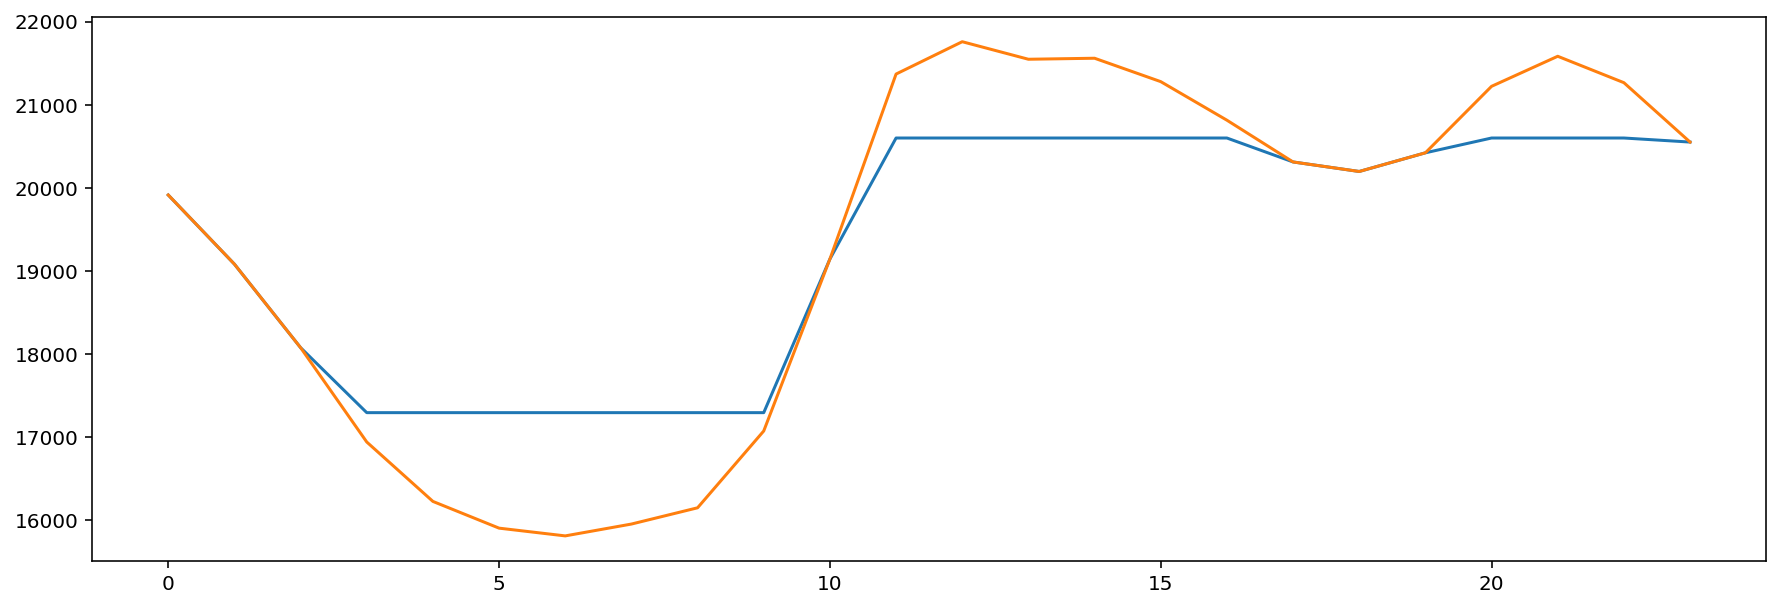

In [91]:
charging_bound, discharging_bound = res.x

st = 12*24 + 15 + int(np.mean(offset_from_max))
load = df.values[st:st+24].flatten()
discharging_load = np.minimum(load, discharging_bound)
ref_load = np.maximum(discharging_load, charging_bound)

plt.plot(ref_load)
plt.plot(load)